In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch
import os
import random

%matplotlib inline
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [2]:
def train_model(model, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=500):
    X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)
    max_length_train = X_train_padded.size(1)
    X_train_padded = X_train_padded.view(-1, max_length_train, 1)
    X_test_padded = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)
    max_length_test = X_test_padded.size(1)
    X_test_padded = X_test_padded.view(-1, max_length_test, 1)
    train_accuracy = []
    test_accuracy = []
    train_batch_size = len(X_train_lengths)
    for i in range(epochs):
        params = list(model.named_parameters())
        model.zero_grad()
        hidden = model.init_hidden(train_batch_size).float()
        output = model(X_train_padded, hidden, X_train_lengths)
        print(output, Y_train)
        loss = F.cross_entropy(output, Y_train)
        loss.backward()
        optimizer.step()
        for param_name, param in params:
            print(param_name, np.linalg.norm(param.grad.to("cpu").numpy()))
        optimizer.zero_grad()
        tr_accuracy = test_model(model, X_train, X_train_lengths, Y_train)
        train_accuracy.append(tr_accuracy)
        tst_accuracy = test_model(model, X_test, X_test_lengths, Y_test)
        test_accuracy.append(tst_accuracy)
    
    return model.eval(), train_accuracy, test_accuracy

In [3]:
def test_model(model, X_samp, X_samp_lengths, Y_samp):
    batch_size = len(X_samp_lengths)
    hidden = model.init_hidden(batch_size).float()
    X_samp_padded = torch.nn.utils.rnn.pad_sequence(X_samp, batch_first=True)
    max_length_samp = X_samp_padded.size(1)
    X_samp_padded = X_samp_padded.view(-1, max_length_samp, 1)
    output_test = model(X_samp_padded, hidden, X_samp_lengths)
    total = 0
    correct = 0
    for i, out_t in enumerate(output_test):
        if int(torch.argmax(out_t)) - int(Y_samp[i]) == 0:
            correct = correct + 1
        total = total + 1

    return (correct/total)

In [4]:
class ModelOne(nn.Module):
    
    def __init__(self):
        super(ModelOne, self).__init__()
        self.rnn = nn.RNN(1, 128, 15, nonlinearity="relu", dropout=0.25, batch_first=True)
        self.dense = nn.Linear(128, 18)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(15, batch_size, 128).to(device)

        return hidden
    
    def forward(self, x, hidden, x_lengths):
        batch_size = x.size(0)
        max_sequence_size = x.size(1)
        # hidden = self.init_hidden(batch_size).float()
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
        out, hidden = self.rnn(x, hidden)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = out.contiguous()
        out = out.view(-1, 128)
        out = self.dense(out)
        out = out.view(batch_size, max_sequence_size, 18)
        
        indexes = torch.tensor(x_lengths) - 1
        out = out[torch.arange(batch_size), indexes, :]
        
        return F.softmax(out, dim=1)

In [5]:
model_one = ModelOne().to(device)

In [6]:
t = np.arange(0, 10, 0.1)

In [7]:
y = np.sin(t)

In [6]:
X = []
Y = []
freq = list(range(1, 19))

for i in freq:
    for n in range(100):
        limit = random.randint(10, 20)
        t = np.arange(0, limit, 0.1)
        x = np.sin(i * t)
        X.append(x)
        Y.append(i-1)

In [7]:
data = {}
for i in Y:
    if i not in data:
        data[i] = [X[i]]
    else:
        data[i].append(X[i])


In [8]:
X_train = []
Y_train = []
X_test = []
Y_test = []
for i , sequences in data.items():
    for training_seq in sequences[:int(0.8 * len(sequences))]:
        X_train.append(training_seq)
        Y_train.append(i)
    for testing_seq in sequences[int(0.8 * len(sequences)):]:
        X_test.append(testing_seq)
        Y_test.append(i)

train_set = list(zip(X_train, Y_train))
train_set = sorted(train_set, key=lambda t: len(t[0]), reverse=True)
test_set = list(zip(X_test, Y_test))
test_set = sorted(test_set, key=lambda t: len(t[0]), reverse=True)

In [9]:
X_train = []
X_train_lengths = []
Y_train = []
X_test = []
X_test_lengths = []
Y_test = []
for x, y in train_set:
    X_train.append(torch.tensor(x).float().to(device))
    X_train_lengths.append(len(x))
    Y_train.append(torch.tensor(y))

Y_train = torch.tensor(Y_train).to(device)

for x, y in test_set:
    X_test.append(torch.tensor(x).float().to(device))
    X_test_lengths.append(len(x))
    Y_test.append(torch.tensor(y))

Y_test = torch.tensor(Y_test).to(device)

In [12]:
X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)

In [13]:
X_train_padded.size()

torch.Size([1440, 200])

In [14]:
train_batch_size = X_train_padded.size(0)
hidden = model_one.init_hidden(train_batch_size).float()

In [10]:
optimizer = optim.Adam(model_one.parameters(), lr=0.0001)
model_one, train_accuracy, test_accuracy = train_model(model_one, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=1000)

tensor([[0.0548, 0.0629, 0.0490,  ..., 0.0610, 0.0530, 0.0557],
        [0.0563, 0.0632, 0.0492,  ..., 0.0594, 0.0534, 0.0573],
        [0.0558, 0.0628, 0.0494,  ..., 0.0586, 0.0541, 0.0570],
        ...,
        [0.0561, 0.0637, 0.0494,  ..., 0.0597, 0.0534, 0.0565],
        [0.0551, 0.0631, 0.0487,  ..., 0.0594, 0.0540, 0.0564],
        [0.0556, 0.0635, 0.0489,  ..., 0.0590, 0.0534, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.026739e-08
rnn.weight_hh_l0 3.8675005e-08
rnn.bias_ih_l0 5.9171715e-08
rnn.bias_hh_l0 5.9171715e-08
rnn.weight_ih_l1 9.662883e-08
rnn.weight_hh_l1 1.0173585e-07
rnn.bias_ih_l1 1.3056236e-07
rnn.bias_hh_l1 1.3056236e-07
rnn.weight_ih_l2 1.9311351e-07
rnn.weight_hh_l2 1.483411e-07
rnn.bias_ih_l2 2.1005046e-07
rnn.bias_hh_l2 2.1005046e-07
rnn.weight_ih_l3 3.4936238e-07
rnn.weight_hh_l3 3.390176e-07
rnn.bias_ih_l3 4.290515e-07
rnn.bias_hh_l3 4.290515e-07
rnn.weight_ih_l4 6.456556e-

tensor([[0.0566, 0.0631, 0.0489,  ..., 0.0594, 0.0527, 0.0573],
        [0.0564, 0.0640, 0.0496,  ..., 0.0602, 0.0527, 0.0570],
        [0.0559, 0.0624, 0.0490,  ..., 0.0601, 0.0524, 0.0567],
        ...,
        [0.0559, 0.0632, 0.0500,  ..., 0.0604, 0.0529, 0.0570],
        [0.0559, 0.0627, 0.0493,  ..., 0.0602, 0.0538, 0.0564],
        [0.0559, 0.0630, 0.0493,  ..., 0.0608, 0.0536, 0.0573]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.36766e-08
rnn.weight_hh_l0 3.3806263e-08
rnn.bias_ih_l0 5.0169927e-08
rnn.bias_hh_l0 5.0169927e-08
rnn.weight_ih_l1 8.465259e-08
rnn.weight_hh_l1 8.3621394e-08
rnn.bias_ih_l1 1.054158e-07
rnn.bias_hh_l1 1.054158e-07
rnn.weight_ih_l2 2.0017958e-07
rnn.weight_hh_l2 1.5342972e-07
rnn.bias_ih_l2 2.1706046e-07
rnn.bias_hh_l2 2.1706046e-07
rnn.weight_ih_l3 3.6519333e-07
rnn.weight_hh_l3 3.5750173e-07
rnn.bias_ih_l3 4.5717215e-07
rnn.bias_hh_l3 4.5717215e-07
rnn.weight_ih_l4 7.276256e

tensor([[0.0560, 0.0633, 0.0489,  ..., 0.0602, 0.0532, 0.0578],
        [0.0558, 0.0633, 0.0495,  ..., 0.0593, 0.0531, 0.0559],
        [0.0564, 0.0628, 0.0499,  ..., 0.0598, 0.0534, 0.0571],
        ...,
        [0.0552, 0.0621, 0.0485,  ..., 0.0606, 0.0534, 0.0560],
        [0.0567, 0.0637, 0.0496,  ..., 0.0606, 0.0541, 0.0582],
        [0.0556, 0.0627, 0.0496,  ..., 0.0605, 0.0533, 0.0575]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.921351e-08
rnn.weight_hh_l0 3.7363215e-08
rnn.bias_ih_l0 5.7815363e-08
rnn.bias_hh_l0 5.7815363e-08
rnn.weight_ih_l1 9.0674874e-08
rnn.weight_hh_l1 9.5738635e-08
rnn.bias_ih_l1 1.2131932e-07
rnn.bias_hh_l1 1.2131932e-07
rnn.weight_ih_l2 2.082892e-07
rnn.weight_hh_l2 1.6431592e-07
rnn.bias_ih_l2 2.3474902e-07
rnn.bias_hh_l2 2.3474902e-07
rnn.weight_ih_l3 4.1840366e-07
rnn.weight_hh_l3 4.220161e-07
rnn.bias_ih_l3 5.388031e-07
rnn.bias_hh_l3 5.388031e-07
rnn.weight_ih_l4 8.3017824

tensor([[0.0554, 0.0640, 0.0501,  ..., 0.0600, 0.0522, 0.0567],
        [0.0566, 0.0634, 0.0491,  ..., 0.0583, 0.0543, 0.0573],
        [0.0558, 0.0630, 0.0494,  ..., 0.0586, 0.0530, 0.0564],
        ...,
        [0.0560, 0.0633, 0.0492,  ..., 0.0593, 0.0532, 0.0570],
        [0.0556, 0.0628, 0.0498,  ..., 0.0592, 0.0533, 0.0565],
        [0.0555, 0.0629, 0.0494,  ..., 0.0591, 0.0531, 0.0568]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.6956405e-08
rnn.weight_hh_l0 4.723074e-08
rnn.bias_ih_l0 7.337763e-08
rnn.bias_hh_l0 7.337763e-08
rnn.weight_ih_l1 1.0901114e-07
rnn.weight_hh_l1 1.2269199e-07
rnn.bias_ih_l1 1.55242e-07
rnn.bias_hh_l1 1.55242e-07
rnn.weight_ih_l2 2.220779e-07
rnn.weight_hh_l2 1.8358735e-07
rnn.bias_ih_l2 2.6214275e-07
rnn.bias_hh_l2 2.6214275e-07
rnn.weight_ih_l3 3.8719574e-07
rnn.weight_hh_l3 3.895911e-07
rnn.bias_ih_l3 5.015144e-07
rnn.bias_hh_l3 5.015144e-07
rnn.weight_ih_l4 6.845924e-07
rn

tensor([[0.0564, 0.0628, 0.0493,  ..., 0.0584, 0.0531, 0.0568],
        [0.0572, 0.0630, 0.0499,  ..., 0.0593, 0.0536, 0.0580],
        [0.0563, 0.0633, 0.0495,  ..., 0.0595, 0.0540, 0.0566],
        ...,
        [0.0558, 0.0624, 0.0491,  ..., 0.0596, 0.0531, 0.0567],
        [0.0565, 0.0623, 0.0498,  ..., 0.0601, 0.0527, 0.0570],
        [0.0560, 0.0627, 0.0504,  ..., 0.0592, 0.0533, 0.0577]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.0626777e-08
rnn.weight_hh_l0 3.5926874e-08
rnn.bias_ih_l0 5.4623982e-08
rnn.bias_hh_l0 5.4623982e-08
rnn.weight_ih_l1 8.8703246e-08
rnn.weight_hh_l1 9.4205184e-08
rnn.bias_ih_l1 1.1930904e-07
rnn.bias_hh_l1 1.1930904e-07
rnn.weight_ih_l2 2.0595553e-07
rnn.weight_hh_l2 1.6348e-07
rnn.bias_ih_l2 2.3176106e-07
rnn.bias_hh_l2 2.3176106e-07
rnn.weight_ih_l3 3.1040324e-07
rnn.weight_hh_l3 2.8572484e-07
rnn.bias_ih_l3 3.5434178e-07
rnn.bias_hh_l3 3.5434178e-07
rnn.weight_ih_l4 6.37187

tensor([[0.0549, 0.0630, 0.0497,  ..., 0.0600, 0.0533, 0.0559],
        [0.0568, 0.0633, 0.0506,  ..., 0.0590, 0.0538, 0.0571],
        [0.0569, 0.0620, 0.0498,  ..., 0.0591, 0.0534, 0.0571],
        ...,
        [0.0551, 0.0622, 0.0494,  ..., 0.0606, 0.0533, 0.0564],
        [0.0559, 0.0615, 0.0491,  ..., 0.0615, 0.0530, 0.0572],
        [0.0554, 0.0635, 0.0493,  ..., 0.0599, 0.0535, 0.0567]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.782342e-08
rnn.weight_hh_l0 3.6713953e-08
rnn.bias_ih_l0 5.646587e-08
rnn.bias_hh_l0 5.646587e-08
rnn.weight_ih_l1 9.6387645e-08
rnn.weight_hh_l1 1.0304134e-07
rnn.bias_ih_l1 1.3252287e-07
rnn.bias_hh_l1 1.3252287e-07
rnn.weight_ih_l2 1.9994454e-07
rnn.weight_hh_l2 1.6409338e-07
rnn.bias_ih_l2 2.326852e-07
rnn.bias_hh_l2 2.326852e-07
rnn.weight_ih_l3 3.640171e-07
rnn.weight_hh_l3 3.6395954e-07
rnn.bias_ih_l3 4.5925228e-07
rnn.bias_hh_l3 4.5925228e-07
rnn.weight_ih_l4 7.173677e-

tensor([[0.0565, 0.0617, 0.0488,  ..., 0.0592, 0.0535, 0.0567],
        [0.0561, 0.0631, 0.0493,  ..., 0.0593, 0.0546, 0.0570],
        [0.0559, 0.0622, 0.0494,  ..., 0.0586, 0.0539, 0.0570],
        ...,
        [0.0562, 0.0626, 0.0497,  ..., 0.0596, 0.0534, 0.0575],
        [0.0551, 0.0624, 0.0500,  ..., 0.0589, 0.0531, 0.0566],
        [0.0553, 0.0633, 0.0500,  ..., 0.0584, 0.0533, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.1578467e-08
rnn.weight_hh_l0 3.3291116e-08
rnn.bias_ih_l0 4.9955002e-08
rnn.bias_hh_l0 4.9955002e-08
rnn.weight_ih_l1 8.651355e-08
rnn.weight_hh_l1 9.067972e-08
rnn.bias_ih_l1 1.15074194e-07
rnn.bias_hh_l1 1.15074194e-07
rnn.weight_ih_l2 1.8623508e-07
rnn.weight_hh_l2 1.4494255e-07
rnn.bias_ih_l2 2.0544357e-07
rnn.bias_hh_l2 2.0544357e-07
rnn.weight_ih_l3 2.87168e-07
rnn.weight_hh_l3 2.6952145e-07
rnn.bias_ih_l3 3.321187e-07
rnn.bias_hh_l3 3.321187e-07
rnn.weight_ih_l4 6.123349

tensor([[0.0561, 0.0629, 0.0506,  ..., 0.0599, 0.0530, 0.0577],
        [0.0565, 0.0624, 0.0496,  ..., 0.0587, 0.0534, 0.0560],
        [0.0564, 0.0620, 0.0494,  ..., 0.0597, 0.0538, 0.0569],
        ...,
        [0.0572, 0.0618, 0.0504,  ..., 0.0588, 0.0537, 0.0578],
        [0.0560, 0.0626, 0.0495,  ..., 0.0601, 0.0533, 0.0568],
        [0.0566, 0.0625, 0.0504,  ..., 0.0605, 0.0522, 0.0572]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.0287873e-08
rnn.weight_hh_l0 3.7786442e-08
rnn.bias_ih_l0 5.768055e-08
rnn.bias_hh_l0 5.768055e-08
rnn.weight_ih_l1 8.452952e-08
rnn.weight_hh_l1 8.906509e-08
rnn.bias_ih_l1 1.1393854e-07
rnn.bias_hh_l1 1.1393854e-07
rnn.weight_ih_l2 1.7477909e-07
rnn.weight_hh_l2 1.3399567e-07
rnn.bias_ih_l2 1.8815713e-07
rnn.bias_hh_l2 1.8815713e-07
rnn.weight_ih_l3 3.1714993e-07
rnn.weight_hh_l3 3.0032348e-07
rnn.bias_ih_l3 3.826653e-07
rnn.bias_hh_l3 3.826653e-07
rnn.weight_ih_l4 6.2033286e

tensor([[0.0569, 0.0613, 0.0501,  ..., 0.0589, 0.0533, 0.0574],
        [0.0558, 0.0628, 0.0500,  ..., 0.0607, 0.0540, 0.0573],
        [0.0561, 0.0626, 0.0499,  ..., 0.0597, 0.0536, 0.0570],
        ...,
        [0.0553, 0.0618, 0.0505,  ..., 0.0580, 0.0540, 0.0572],
        [0.0555, 0.0625, 0.0499,  ..., 0.0595, 0.0532, 0.0576],
        [0.0563, 0.0628, 0.0495,  ..., 0.0596, 0.0537, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.873785e-08
rnn.weight_hh_l0 3.4147185e-08
rnn.bias_ih_l0 5.1685443e-08
rnn.bias_hh_l0 5.1685443e-08
rnn.weight_ih_l1 7.122592e-08
rnn.weight_hh_l1 7.006723e-08
rnn.bias_ih_l1 8.7415394e-08
rnn.bias_hh_l1 8.7415394e-08
rnn.weight_ih_l2 1.533471e-07
rnn.weight_hh_l2 1.11956645e-07
rnn.bias_ih_l2 1.5535385e-07
rnn.bias_hh_l2 1.5535385e-07
rnn.weight_ih_l3 3.1101496e-07
rnn.weight_hh_l3 2.9335442e-07
rnn.bias_ih_l3 3.704534e-07
rnn.bias_hh_l3 3.704534e-07
rnn.weight_ih_l4 5.885958e

tensor([[0.0560, 0.0624, 0.0497,  ..., 0.0606, 0.0533, 0.0566],
        [0.0562, 0.0623, 0.0503,  ..., 0.0593, 0.0536, 0.0575],
        [0.0550, 0.0622, 0.0499,  ..., 0.0591, 0.0536, 0.0564],
        ...,
        [0.0564, 0.0620, 0.0501,  ..., 0.0600, 0.0532, 0.0569],
        [0.0558, 0.0613, 0.0496,  ..., 0.0595, 0.0538, 0.0567],
        [0.0562, 0.0615, 0.0494,  ..., 0.0589, 0.0533, 0.0570]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.5142893e-08
rnn.weight_hh_l0 3.3409787e-08
rnn.bias_ih_l0 5.1074487e-08
rnn.bias_hh_l0 5.1074487e-08
rnn.weight_ih_l1 7.604281e-08
rnn.weight_hh_l1 7.83595e-08
rnn.bias_ih_l1 9.893298e-08
rnn.bias_hh_l1 9.893298e-08
rnn.weight_ih_l2 1.4959076e-07
rnn.weight_hh_l2 1.08517e-07
rnn.bias_ih_l2 1.5092698e-07
rnn.bias_hh_l2 1.5092698e-07
rnn.weight_ih_l3 3.080424e-07
rnn.weight_hh_l3 2.9414088e-07
rnn.bias_ih_l3 3.736961e-07
rnn.bias_hh_l3 3.736961e-07
rnn.weight_ih_l4 6.920616e-07
r

tensor([[0.0557, 0.0620, 0.0500,  ..., 0.0590, 0.0529, 0.0565],
        [0.0560, 0.0618, 0.0499,  ..., 0.0579, 0.0539, 0.0570],
        [0.0562, 0.0624, 0.0507,  ..., 0.0598, 0.0530, 0.0566],
        ...,
        [0.0568, 0.0622, 0.0505,  ..., 0.0590, 0.0537, 0.0582],
        [0.0554, 0.0621, 0.0497,  ..., 0.0598, 0.0530, 0.0567],
        [0.0558, 0.0618, 0.0487,  ..., 0.0595, 0.0541, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.6186935e-08
rnn.weight_hh_l0 4.5296222e-08
rnn.bias_ih_l0 6.439052e-08
rnn.bias_hh_l0 6.439052e-08
rnn.weight_ih_l1 8.6144595e-08
rnn.weight_hh_l1 8.554349e-08
rnn.bias_ih_l1 1.080707e-07
rnn.bias_hh_l1 1.080707e-07
rnn.weight_ih_l2 1.642453e-07
rnn.weight_hh_l2 1.2578803e-07
rnn.bias_ih_l2 1.7368436e-07
rnn.bias_hh_l2 1.7368436e-07
rnn.weight_ih_l3 2.761717e-07
rnn.weight_hh_l3 2.5648328e-07
rnn.bias_ih_l3 3.1780485e-07
rnn.bias_hh_l3 3.1780485e-07
rnn.weight_ih_l4 5.7520606e-

tensor([[0.0570, 0.0625, 0.0502,  ..., 0.0591, 0.0534, 0.0573],
        [0.0555, 0.0622, 0.0509,  ..., 0.0598, 0.0543, 0.0574],
        [0.0563, 0.0618, 0.0501,  ..., 0.0588, 0.0542, 0.0570],
        ...,
        [0.0563, 0.0617, 0.0497,  ..., 0.0595, 0.0537, 0.0570],
        [0.0557, 0.0620, 0.0505,  ..., 0.0588, 0.0535, 0.0563],
        [0.0569, 0.0610, 0.0497,  ..., 0.0595, 0.0537, 0.0573]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.6441677e-08
rnn.weight_hh_l0 3.824239e-08
rnn.bias_ih_l0 5.725244e-08
rnn.bias_hh_l0 5.725244e-08
rnn.weight_ih_l1 8.0863224e-08
rnn.weight_hh_l1 8.3377586e-08
rnn.bias_ih_l1 1.0582418e-07
rnn.bias_hh_l1 1.0582418e-07
rnn.weight_ih_l2 1.7220225e-07
rnn.weight_hh_l2 1.3064913e-07
rnn.bias_ih_l2 1.8246558e-07
rnn.bias_hh_l2 1.8246558e-07
rnn.weight_ih_l3 3.1028515e-07
rnn.weight_hh_l3 2.966583e-07
rnn.bias_ih_l3 3.7119062e-07
rnn.bias_hh_l3 3.7119062e-07
rnn.weight_ih_l4 6.580293

tensor([[0.0552, 0.0635, 0.0504,  ..., 0.0596, 0.0529, 0.0562],
        [0.0568, 0.0617, 0.0495,  ..., 0.0592, 0.0531, 0.0564],
        [0.0561, 0.0619, 0.0503,  ..., 0.0589, 0.0537, 0.0572],
        ...,
        [0.0558, 0.0616, 0.0492,  ..., 0.0596, 0.0538, 0.0557],
        [0.0569, 0.0622, 0.0498,  ..., 0.0588, 0.0542, 0.0566],
        [0.0562, 0.0621, 0.0501,  ..., 0.0595, 0.0532, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.351804e-08
rnn.weight_hh_l0 2.7872572e-08
rnn.bias_ih_l0 4.1921215e-08
rnn.bias_hh_l0 4.1921215e-08
rnn.weight_ih_l1 6.629071e-08
rnn.weight_hh_l1 5.995487e-08
rnn.bias_ih_l1 7.4668186e-08
rnn.bias_hh_l1 7.4668186e-08
rnn.weight_ih_l2 1.698586e-07
rnn.weight_hh_l2 1.2460535e-07
rnn.bias_ih_l2 1.7357591e-07
rnn.bias_hh_l2 1.7357591e-07
rnn.weight_ih_l3 3.0167703e-07
rnn.weight_hh_l3 2.8760024e-07
rnn.bias_ih_l3 3.6207217e-07
rnn.bias_hh_l3 3.6207217e-07
rnn.weight_ih_l4 5.654993

tensor([[0.0563, 0.0622, 0.0505,  ..., 0.0587, 0.0537, 0.0572],
        [0.0559, 0.0622, 0.0497,  ..., 0.0588, 0.0540, 0.0561],
        [0.0565, 0.0617, 0.0505,  ..., 0.0579, 0.0544, 0.0575],
        ...,
        [0.0559, 0.0610, 0.0505,  ..., 0.0586, 0.0530, 0.0564],
        [0.0559, 0.0624, 0.0504,  ..., 0.0587, 0.0533, 0.0575],
        [0.0557, 0.0622, 0.0497,  ..., 0.0595, 0.0540, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.0049727e-08
rnn.weight_hh_l0 3.28015e-08
rnn.bias_ih_l0 4.858376e-08
rnn.bias_hh_l0 4.858376e-08
rnn.weight_ih_l1 8.6429615e-08
rnn.weight_hh_l1 9.253878e-08
rnn.bias_ih_l1 1.18619155e-07
rnn.bias_hh_l1 1.18619155e-07
rnn.weight_ih_l2 1.7307363e-07
rnn.weight_hh_l2 1.349223e-07
rnn.bias_ih_l2 1.9078608e-07
rnn.bias_hh_l2 1.9078608e-07
rnn.weight_ih_l3 2.6860852e-07
rnn.weight_hh_l3 2.5729383e-07
rnn.bias_ih_l3 3.1929804e-07
rnn.bias_hh_l3 3.1929804e-07
rnn.weight_ih_l4 5.616833

tensor([[0.0560, 0.0616, 0.0500,  ..., 0.0593, 0.0535, 0.0566],
        [0.0568, 0.0621, 0.0498,  ..., 0.0583, 0.0535, 0.0571],
        [0.0571, 0.0603, 0.0494,  ..., 0.0588, 0.0539, 0.0569],
        ...,
        [0.0565, 0.0621, 0.0500,  ..., 0.0597, 0.0530, 0.0565],
        [0.0570, 0.0615, 0.0499,  ..., 0.0581, 0.0545, 0.0570],
        [0.0564, 0.0628, 0.0509,  ..., 0.0588, 0.0532, 0.0569]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.2901216e-08
rnn.weight_hh_l0 3.1025124e-08
rnn.bias_ih_l0 4.7383907e-08
rnn.bias_hh_l0 4.7383907e-08
rnn.weight_ih_l1 8.481095e-08
rnn.weight_hh_l1 8.8725216e-08
rnn.bias_ih_l1 1.12671465e-07
rnn.bias_hh_l1 1.12671465e-07
rnn.weight_ih_l2 1.7184615e-07
rnn.weight_hh_l2 1.3431392e-07
rnn.bias_ih_l2 1.8675298e-07
rnn.bias_hh_l2 1.8675298e-07
rnn.weight_ih_l3 3.199237e-07
rnn.weight_hh_l3 3.1328247e-07
rnn.bias_ih_l3 3.9826574e-07
rnn.bias_hh_l3 3.9826574e-07
rnn.weight_ih_l4 6.19

tensor([[0.0563, 0.0613, 0.0502,  ..., 0.0590, 0.0546, 0.0575],
        [0.0556, 0.0618, 0.0495,  ..., 0.0601, 0.0535, 0.0566],
        [0.0564, 0.0616, 0.0511,  ..., 0.0596, 0.0532, 0.0571],
        ...,
        [0.0563, 0.0615, 0.0500,  ..., 0.0585, 0.0545, 0.0569],
        [0.0564, 0.0620, 0.0506,  ..., 0.0598, 0.0526, 0.0567],
        [0.0569, 0.0618, 0.0507,  ..., 0.0594, 0.0547, 0.0573]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.2650295e-08
rnn.weight_hh_l0 3.042526e-08
rnn.bias_ih_l0 4.6783256e-08
rnn.bias_hh_l0 4.6783256e-08
rnn.weight_ih_l1 7.049196e-08
rnn.weight_hh_l1 6.838432e-08
rnn.bias_ih_l1 8.5167834e-08
rnn.bias_hh_l1 8.5167834e-08
rnn.weight_ih_l2 1.7872068e-07
rnn.weight_hh_l2 1.4130839e-07
rnn.bias_ih_l2 1.9728394e-07
rnn.bias_hh_l2 1.9728394e-07
rnn.weight_ih_l3 3.0242438e-07
rnn.weight_hh_l3 2.9528428e-07
rnn.bias_ih_l3 3.707094e-07
rnn.bias_hh_l3 3.707094e-07
rnn.weight_ih_l4 6.060271e

tensor([[0.0559, 0.0617, 0.0497,  ..., 0.0596, 0.0540, 0.0566],
        [0.0556, 0.0615, 0.0498,  ..., 0.0591, 0.0536, 0.0558],
        [0.0560, 0.0612, 0.0501,  ..., 0.0595, 0.0543, 0.0570],
        ...,
        [0.0565, 0.0611, 0.0499,  ..., 0.0609, 0.0530, 0.0572],
        [0.0559, 0.0618, 0.0504,  ..., 0.0588, 0.0532, 0.0574],
        [0.0569, 0.0611, 0.0504,  ..., 0.0579, 0.0544, 0.0572]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.8619177e-08
rnn.weight_hh_l0 2.698014e-08
rnn.bias_ih_l0 3.8529002e-08
rnn.bias_hh_l0 3.8529002e-08
rnn.weight_ih_l1 7.2000006e-08
rnn.weight_hh_l1 7.149064e-08
rnn.bias_ih_l1 8.949078e-08
rnn.bias_hh_l1 8.949078e-08
rnn.weight_ih_l2 1.8144269e-07
rnn.weight_hh_l2 1.4194461e-07
rnn.bias_ih_l2 2.0147749e-07
rnn.bias_hh_l2 2.0147749e-07
rnn.weight_ih_l3 3.528531e-07
rnn.weight_hh_l3 3.4748712e-07
rnn.bias_ih_l3 4.4418937e-07
rnn.bias_hh_l3 4.4418937e-07
rnn.weight_ih_l4 6.862371e

tensor([[0.0563, 0.0616, 0.0497,  ..., 0.0588, 0.0533, 0.0555],
        [0.0549, 0.0621, 0.0501,  ..., 0.0579, 0.0543, 0.0568],
        [0.0562, 0.0612, 0.0497,  ..., 0.0593, 0.0535, 0.0558],
        ...,
        [0.0557, 0.0618, 0.0503,  ..., 0.0588, 0.0541, 0.0562],
        [0.0556, 0.0624, 0.0503,  ..., 0.0597, 0.0536, 0.0560],
        [0.0548, 0.0608, 0.0496,  ..., 0.0581, 0.0530, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.4221276e-08
rnn.weight_hh_l0 3.5085826e-08
rnn.bias_ih_l0 5.4581612e-08
rnn.bias_hh_l0 5.4581612e-08
rnn.weight_ih_l1 7.695463e-08
rnn.weight_hh_l1 8.055215e-08
rnn.bias_ih_l1 1.03391194e-07
rnn.bias_hh_l1 1.03391194e-07
rnn.weight_ih_l2 1.826399e-07
rnn.weight_hh_l2 1.466526e-07
rnn.bias_ih_l2 2.06516e-07
rnn.bias_hh_l2 2.06516e-07
rnn.weight_ih_l3 2.9969388e-07
rnn.weight_hh_l3 2.9070196e-07
rnn.bias_ih_l3 3.6101073e-07
rnn.bias_hh_l3 3.6101073e-07
rnn.weight_ih_l4 5.909957e-

tensor([[0.0560, 0.0614, 0.0500,  ..., 0.0586, 0.0543, 0.0571],
        [0.0560, 0.0612, 0.0500,  ..., 0.0598, 0.0537, 0.0569],
        [0.0563, 0.0613, 0.0487,  ..., 0.0591, 0.0537, 0.0564],
        ...,
        [0.0560, 0.0617, 0.0499,  ..., 0.0585, 0.0547, 0.0573],
        [0.0551, 0.0605, 0.0498,  ..., 0.0596, 0.0537, 0.0552],
        [0.0567, 0.0620, 0.0508,  ..., 0.0589, 0.0537, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.231929e-08
rnn.weight_hh_l0 3.6013237e-08
rnn.bias_ih_l0 5.6597074e-08
rnn.bias_hh_l0 5.6597074e-08
rnn.weight_ih_l1 7.121272e-08
rnn.weight_hh_l1 7.081038e-08
rnn.bias_ih_l1 8.932122e-08
rnn.bias_hh_l1 8.932122e-08
rnn.weight_ih_l2 1.5685504e-07
rnn.weight_hh_l2 1.1819066e-07
rnn.bias_ih_l2 1.656757e-07
rnn.bias_hh_l2 1.656757e-07
rnn.weight_ih_l3 3.014563e-07
rnn.weight_hh_l3 2.929398e-07
rnn.bias_ih_l3 3.6666174e-07
rnn.bias_hh_l3 3.6666174e-07
rnn.weight_ih_l4 6.098869e-07


tensor([[0.0557, 0.0619, 0.0497,  ..., 0.0584, 0.0547, 0.0566],
        [0.0563, 0.0615, 0.0512,  ..., 0.0595, 0.0539, 0.0572],
        [0.0562, 0.0617, 0.0511,  ..., 0.0588, 0.0535, 0.0563],
        ...,
        [0.0566, 0.0619, 0.0501,  ..., 0.0588, 0.0544, 0.0564],
        [0.0558, 0.0620, 0.0498,  ..., 0.0586, 0.0543, 0.0564],
        [0.0558, 0.0614, 0.0507,  ..., 0.0585, 0.0538, 0.0568]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.4655148e-08
rnn.weight_hh_l0 3.2674233e-08
rnn.bias_ih_l0 5.0284555e-08
rnn.bias_hh_l0 5.0284555e-08
rnn.weight_ih_l1 8.0959104e-08
rnn.weight_hh_l1 8.625906e-08
rnn.bias_ih_l1 1.10029305e-07
rnn.bias_hh_l1 1.10029305e-07
rnn.weight_ih_l2 1.7120607e-07
rnn.weight_hh_l2 1.339063e-07
rnn.bias_ih_l2 1.8917257e-07
rnn.bias_hh_l2 1.8917257e-07
rnn.weight_ih_l3 3.0443965e-07
rnn.weight_hh_l3 2.8861155e-07
rnn.bias_ih_l3 3.6562557e-07
rnn.bias_hh_l3 3.6562557e-07
rnn.weight_ih_l4 6.45

tensor([[0.0562, 0.0617, 0.0500,  ..., 0.0583, 0.0531, 0.0571],
        [0.0560, 0.0610, 0.0501,  ..., 0.0588, 0.0532, 0.0564],
        [0.0558, 0.0612, 0.0504,  ..., 0.0593, 0.0533, 0.0573],
        ...,
        [0.0549, 0.0617, 0.0503,  ..., 0.0586, 0.0540, 0.0564],
        [0.0558, 0.0609, 0.0497,  ..., 0.0590, 0.0540, 0.0558],
        [0.0573, 0.0615, 0.0501,  ..., 0.0580, 0.0536, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.3799027e-08
rnn.weight_hh_l0 3.1929613e-08
rnn.bias_ih_l0 4.248343e-08
rnn.bias_hh_l0 4.248343e-08
rnn.weight_ih_l1 7.229775e-08
rnn.weight_hh_l1 6.9844745e-08
rnn.bias_ih_l1 8.701093e-08
rnn.bias_hh_l1 8.701093e-08
rnn.weight_ih_l2 1.4871844e-07
rnn.weight_hh_l2 1.1000706e-07
rnn.bias_ih_l2 1.4833829e-07
rnn.bias_hh_l2 1.4833829e-07
rnn.weight_ih_l3 3.1200125e-07
rnn.weight_hh_l3 3.0582012e-07
rnn.bias_ih_l3 3.8588857e-07
rnn.bias_hh_l3 3.8588857e-07
rnn.weight_ih_l4 5.9105406

tensor([[0.0567, 0.0609, 0.0503,  ..., 0.0577, 0.0538, 0.0564],
        [0.0561, 0.0614, 0.0501,  ..., 0.0591, 0.0533, 0.0563],
        [0.0560, 0.0615, 0.0505,  ..., 0.0594, 0.0535, 0.0564],
        ...,
        [0.0560, 0.0609, 0.0502,  ..., 0.0592, 0.0534, 0.0569],
        [0.0560, 0.0612, 0.0495,  ..., 0.0581, 0.0538, 0.0564],
        [0.0560, 0.0614, 0.0506,  ..., 0.0584, 0.0537, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.9728825e-08
rnn.weight_hh_l0 3.7820495e-08
rnn.bias_ih_l0 5.8387148e-08
rnn.bias_hh_l0 5.8387148e-08
rnn.weight_ih_l1 8.3064236e-08
rnn.weight_hh_l1 9.1257206e-08
rnn.bias_ih_l1 1.1706761e-07
rnn.bias_hh_l1 1.1706761e-07
rnn.weight_ih_l2 1.8515222e-07
rnn.weight_hh_l2 1.4508831e-07
rnn.bias_ih_l2 2.0702142e-07
rnn.bias_hh_l2 2.0702142e-07
rnn.weight_ih_l3 3.4607004e-07
rnn.weight_hh_l3 3.522035e-07
rnn.bias_ih_l3 4.495279e-07
rnn.bias_hh_l3 4.495279e-07
rnn.weight_ih_l4 5.96002

tensor([[0.0558, 0.0604, 0.0507,  ..., 0.0586, 0.0537, 0.0559],
        [0.0564, 0.0608, 0.0499,  ..., 0.0586, 0.0534, 0.0561],
        [0.0562, 0.0610, 0.0504,  ..., 0.0583, 0.0534, 0.0566],
        ...,
        [0.0558, 0.0613, 0.0506,  ..., 0.0589, 0.0538, 0.0570],
        [0.0566, 0.0616, 0.0500,  ..., 0.0582, 0.0541, 0.0562],
        [0.0558, 0.0605, 0.0505,  ..., 0.0586, 0.0540, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.0106126e-08
rnn.weight_hh_l0 3.1430286e-08
rnn.bias_ih_l0 4.886991e-08
rnn.bias_hh_l0 4.886991e-08
rnn.weight_ih_l1 8.2251e-08
rnn.weight_hh_l1 8.965985e-08
rnn.bias_ih_l1 1.1441895e-07
rnn.bias_hh_l1 1.1441895e-07
rnn.weight_ih_l2 1.7381322e-07
rnn.weight_hh_l2 1.3770725e-07
rnn.bias_ih_l2 1.9251124e-07
rnn.bias_hh_l2 1.9251124e-07
rnn.weight_ih_l3 3.0986465e-07
rnn.weight_hh_l3 3.0476141e-07
rnn.bias_ih_l3 3.8392903e-07
rnn.bias_hh_l3 3.8392903e-07
rnn.weight_ih_l4 6.1346475e

tensor([[0.0559, 0.0600, 0.0501,  ..., 0.0580, 0.0536, 0.0561],
        [0.0563, 0.0618, 0.0512,  ..., 0.0585, 0.0546, 0.0574],
        [0.0561, 0.0605, 0.0509,  ..., 0.0576, 0.0537, 0.0567],
        ...,
        [0.0556, 0.0611, 0.0502,  ..., 0.0581, 0.0535, 0.0554],
        [0.0559, 0.0613, 0.0508,  ..., 0.0596, 0.0539, 0.0566],
        [0.0567, 0.0602, 0.0505,  ..., 0.0589, 0.0538, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.2343967e-08
rnn.weight_hh_l0 3.29641e-08
rnn.bias_ih_l0 4.916276e-08
rnn.bias_hh_l0 4.916276e-08
rnn.weight_ih_l1 8.0628624e-08
rnn.weight_hh_l1 8.317993e-08
rnn.bias_ih_l1 1.0556212e-07
rnn.bias_hh_l1 1.0556212e-07
rnn.weight_ih_l2 1.6171371e-07
rnn.weight_hh_l2 1.2558e-07
rnn.bias_ih_l2 1.7521424e-07
rnn.bias_hh_l2 1.7521424e-07
rnn.weight_ih_l3 2.8468e-07
rnn.weight_hh_l3 2.6824873e-07
rnn.bias_ih_l3 3.4006723e-07
rnn.bias_hh_l3 3.4006723e-07
rnn.weight_ih_l4 5.9278653e-07
r

tensor([[0.0561, 0.0606, 0.0500,  ..., 0.0579, 0.0530, 0.0561],
        [0.0561, 0.0606, 0.0506,  ..., 0.0577, 0.0533, 0.0569],
        [0.0552, 0.0607, 0.0507,  ..., 0.0586, 0.0537, 0.0560],
        ...,
        [0.0564, 0.0614, 0.0505,  ..., 0.0571, 0.0540, 0.0564],
        [0.0570, 0.0615, 0.0500,  ..., 0.0570, 0.0546, 0.0572],
        [0.0557, 0.0605, 0.0505,  ..., 0.0593, 0.0541, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.4138843e-08
rnn.weight_hh_l0 3.204459e-08
rnn.bias_ih_l0 4.8959173e-08
rnn.bias_hh_l0 4.8959173e-08
rnn.weight_ih_l1 8.121387e-08
rnn.weight_hh_l1 8.541607e-08
rnn.bias_ih_l1 1.0830789e-07
rnn.bias_hh_l1 1.0830789e-07
rnn.weight_ih_l2 1.8062904e-07
rnn.weight_hh_l2 1.4656246e-07
rnn.bias_ih_l2 2.058008e-07
rnn.bias_hh_l2 2.058008e-07
rnn.weight_ih_l3 3.2893848e-07
rnn.weight_hh_l3 3.3423362e-07
rnn.bias_ih_l3 4.2354262e-07
rnn.bias_hh_l3 4.2354262e-07
rnn.weight_ih_l4 7.1188157

tensor([[0.0568, 0.0609, 0.0505,  ..., 0.0573, 0.0543, 0.0565],
        [0.0562, 0.0612, 0.0506,  ..., 0.0587, 0.0538, 0.0568],
        [0.0558, 0.0605, 0.0499,  ..., 0.0592, 0.0534, 0.0562],
        ...,
        [0.0554, 0.0612, 0.0515,  ..., 0.0582, 0.0542, 0.0562],
        [0.0558, 0.0613, 0.0504,  ..., 0.0582, 0.0535, 0.0565],
        [0.0557, 0.0613, 0.0509,  ..., 0.0590, 0.0538, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.406257e-08
rnn.weight_hh_l0 3.4251272e-08
rnn.bias_ih_l0 5.1136563e-08
rnn.bias_hh_l0 5.1136563e-08
rnn.weight_ih_l1 7.7475214e-08
rnn.weight_hh_l1 7.861729e-08
rnn.bias_ih_l1 9.913958e-08
rnn.bias_hh_l1 9.913958e-08
rnn.weight_ih_l2 1.6216511e-07
rnn.weight_hh_l2 1.2442415e-07
rnn.bias_ih_l2 1.7425052e-07
rnn.bias_hh_l2 1.7425052e-07
rnn.weight_ih_l3 2.7744431e-07
rnn.weight_hh_l3 2.5196022e-07
rnn.bias_ih_l3 3.12764e-07
rnn.bias_hh_l3 3.12764e-07
rnn.weight_ih_l4 5.3589e-07
r

tensor([[0.0561, 0.0612, 0.0504,  ..., 0.0578, 0.0546, 0.0565],
        [0.0564, 0.0616, 0.0502,  ..., 0.0589, 0.0542, 0.0569],
        [0.0561, 0.0613, 0.0512,  ..., 0.0594, 0.0535, 0.0568],
        ...,
        [0.0564, 0.0607, 0.0503,  ..., 0.0586, 0.0536, 0.0564],
        [0.0570, 0.0605, 0.0506,  ..., 0.0583, 0.0535, 0.0571],
        [0.0560, 0.0610, 0.0510,  ..., 0.0582, 0.0539, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.2012505e-08
rnn.weight_hh_l0 3.3864282e-08
rnn.bias_ih_l0 5.083601e-08
rnn.bias_hh_l0 5.083601e-08
rnn.weight_ih_l1 7.856384e-08
rnn.weight_hh_l1 7.980477e-08
rnn.bias_ih_l1 1.0079394e-07
rnn.bias_hh_l1 1.0079394e-07
rnn.weight_ih_l2 1.652066e-07
rnn.weight_hh_l2 1.3071099e-07
rnn.bias_ih_l2 1.7950491e-07
rnn.bias_hh_l2 1.7950491e-07
rnn.weight_ih_l3 3.069805e-07
rnn.weight_hh_l3 2.9479088e-07
rnn.bias_ih_l3 3.7402745e-07
rnn.bias_hh_l3 3.7402745e-07
rnn.weight_ih_l4 5.74206e-0

tensor([[0.0563, 0.0606, 0.0503,  ..., 0.0583, 0.0539, 0.0566],
        [0.0565, 0.0602, 0.0503,  ..., 0.0592, 0.0526, 0.0561],
        [0.0555, 0.0612, 0.0512,  ..., 0.0605, 0.0540, 0.0567],
        ...,
        [0.0554, 0.0613, 0.0503,  ..., 0.0584, 0.0533, 0.0560],
        [0.0563, 0.0606, 0.0504,  ..., 0.0578, 0.0540, 0.0560],
        [0.0560, 0.0616, 0.0510,  ..., 0.0590, 0.0542, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.9257912e-08
rnn.weight_hh_l0 3.4844078e-08
rnn.bias_ih_l0 5.3060102e-08
rnn.bias_hh_l0 5.3060102e-08
rnn.weight_ih_l1 6.9258526e-08
rnn.weight_hh_l1 7.2164255e-08
rnn.bias_ih_l1 9.1628685e-08
rnn.bias_hh_l1 9.1628685e-08
rnn.weight_ih_l2 1.8547249e-07
rnn.weight_hh_l2 1.4431924e-07
rnn.bias_ih_l2 2.0582705e-07
rnn.bias_hh_l2 2.0582705e-07
rnn.weight_ih_l3 2.93991e-07
rnn.weight_hh_l3 2.7937708e-07
rnn.bias_ih_l3 3.5344792e-07
rnn.bias_hh_l3 3.5344792e-07
rnn.weight_ih_l4 6.1354

tensor([[0.0564, 0.0600, 0.0508,  ..., 0.0575, 0.0543, 0.0565],
        [0.0565, 0.0618, 0.0513,  ..., 0.0581, 0.0539, 0.0560],
        [0.0558, 0.0604, 0.0511,  ..., 0.0592, 0.0544, 0.0561],
        ...,
        [0.0569, 0.0610, 0.0506,  ..., 0.0582, 0.0532, 0.0568],
        [0.0561, 0.0606, 0.0499,  ..., 0.0575, 0.0546, 0.0566],
        [0.0567, 0.0604, 0.0511,  ..., 0.0584, 0.0547, 0.0569]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.71551e-08
rnn.weight_hh_l0 2.9527149e-08
rnn.bias_ih_l0 4.4280895e-08
rnn.bias_hh_l0 4.4280895e-08
rnn.weight_ih_l1 6.829347e-08
rnn.weight_hh_l1 6.915828e-08
rnn.bias_ih_l1 8.8204125e-08
rnn.bias_hh_l1 8.8204125e-08
rnn.weight_ih_l2 1.6784291e-07
rnn.weight_hh_l2 1.3452039e-07
rnn.bias_ih_l2 1.8814575e-07
rnn.bias_hh_l2 1.8814575e-07
rnn.weight_ih_l3 2.8718458e-07
rnn.weight_hh_l3 2.7194162e-07
rnn.bias_ih_l3 3.409357e-07
rnn.bias_hh_l3 3.409357e-07
rnn.weight_ih_l4 5.5850194e

tensor([[0.0558, 0.0607, 0.0510,  ..., 0.0571, 0.0542, 0.0565],
        [0.0553, 0.0612, 0.0512,  ..., 0.0589, 0.0541, 0.0567],
        [0.0563, 0.0605, 0.0503,  ..., 0.0579, 0.0541, 0.0560],
        ...,
        [0.0564, 0.0608, 0.0508,  ..., 0.0572, 0.0550, 0.0566],
        [0.0562, 0.0608, 0.0504,  ..., 0.0589, 0.0533, 0.0558],
        [0.0558, 0.0601, 0.0505,  ..., 0.0578, 0.0543, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.0634443e-08
rnn.weight_hh_l0 3.167567e-08
rnn.bias_ih_l0 4.9605006e-08
rnn.bias_hh_l0 4.9605006e-08
rnn.weight_ih_l1 7.778609e-08
rnn.weight_hh_l1 7.969867e-08
rnn.bias_ih_l1 1.0114108e-07
rnn.bias_hh_l1 1.0114108e-07
rnn.weight_ih_l2 1.5877724e-07
rnn.weight_hh_l2 1.2239835e-07
rnn.bias_ih_l2 1.7056546e-07
rnn.bias_hh_l2 1.7056546e-07
rnn.weight_ih_l3 2.7210217e-07
rnn.weight_hh_l3 2.5333006e-07
rnn.bias_ih_l3 3.1521648e-07
rnn.bias_hh_l3 3.1521648e-07
rnn.weight_ih_l4 5.47475

tensor([[0.0571, 0.0612, 0.0512,  ..., 0.0572, 0.0546, 0.0570],
        [0.0563, 0.0599, 0.0505,  ..., 0.0578, 0.0544, 0.0567],
        [0.0563, 0.0604, 0.0507,  ..., 0.0581, 0.0552, 0.0562],
        ...,
        [0.0560, 0.0609, 0.0505,  ..., 0.0585, 0.0536, 0.0559],
        [0.0557, 0.0605, 0.0505,  ..., 0.0587, 0.0543, 0.0558],
        [0.0559, 0.0605, 0.0511,  ..., 0.0592, 0.0528, 0.0556]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.3361243e-08
rnn.weight_hh_l0 2.9683864e-08
rnn.bias_ih_l0 4.2748123e-08
rnn.bias_hh_l0 4.2748123e-08
rnn.weight_ih_l1 7.175881e-08
rnn.weight_hh_l1 7.206156e-08
rnn.bias_ih_l1 9.131024e-08
rnn.bias_hh_l1 9.131024e-08
rnn.weight_ih_l2 1.5322098e-07
rnn.weight_hh_l2 1.17473576e-07
rnn.bias_ih_l2 1.6334592e-07
rnn.bias_hh_l2 1.6334592e-07
rnn.weight_ih_l3 2.7709774e-07
rnn.weight_hh_l3 2.55104e-07
rnn.bias_ih_l3 3.213939e-07
rnn.bias_hh_l3 3.213939e-07
rnn.weight_ih_l4 6.0593453e-

tensor([[0.0567, 0.0604, 0.0510,  ..., 0.0588, 0.0542, 0.0571],
        [0.0561, 0.0601, 0.0498,  ..., 0.0586, 0.0544, 0.0560],
        [0.0557, 0.0604, 0.0513,  ..., 0.0579, 0.0539, 0.0566],
        ...,
        [0.0570, 0.0610, 0.0508,  ..., 0.0580, 0.0533, 0.0560],
        [0.0568, 0.0604, 0.0505,  ..., 0.0571, 0.0551, 0.0567],
        [0.0555, 0.0616, 0.0507,  ..., 0.0587, 0.0547, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.4916972e-08
rnn.weight_hh_l0 3.05792e-08
rnn.bias_ih_l0 4.651363e-08
rnn.bias_hh_l0 4.651363e-08
rnn.weight_ih_l1 6.789318e-08
rnn.weight_hh_l1 6.6409015e-08
rnn.bias_ih_l1 8.197016e-08
rnn.bias_hh_l1 8.197016e-08
rnn.weight_ih_l2 1.579569e-07
rnn.weight_hh_l2 1.2439172e-07
rnn.bias_ih_l2 1.7141066e-07
rnn.bias_hh_l2 1.7141066e-07
rnn.weight_ih_l3 3.4037876e-07
rnn.weight_hh_l3 3.4523188e-07
rnn.bias_ih_l3 4.3908463e-07
rnn.bias_hh_l3 4.3908463e-07
rnn.weight_ih_l4 6.6303573e-0

tensor([[0.0551, 0.0605, 0.0510,  ..., 0.0581, 0.0544, 0.0555],
        [0.0557, 0.0607, 0.0503,  ..., 0.0568, 0.0546, 0.0560],
        [0.0558, 0.0603, 0.0507,  ..., 0.0591, 0.0538, 0.0569],
        ...,
        [0.0555, 0.0609, 0.0509,  ..., 0.0581, 0.0546, 0.0561],
        [0.0551, 0.0608, 0.0504,  ..., 0.0587, 0.0541, 0.0550],
        [0.0562, 0.0602, 0.0509,  ..., 0.0572, 0.0543, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.815766e-08
rnn.weight_hh_l0 3.3192244e-08
rnn.bias_ih_l0 4.767949e-08
rnn.bias_hh_l0 4.767949e-08
rnn.weight_ih_l1 7.564515e-08
rnn.weight_hh_l1 7.1280354e-08
rnn.bias_ih_l1 8.9864194e-08
rnn.bias_hh_l1 8.9864194e-08
rnn.weight_ih_l2 1.4993849e-07
rnn.weight_hh_l2 1.1288717e-07
rnn.bias_ih_l2 1.5384799e-07
rnn.bias_hh_l2 1.5384799e-07
rnn.weight_ih_l3 2.7353957e-07
rnn.weight_hh_l3 2.4612004e-07
rnn.bias_ih_l3 3.0182372e-07
rnn.bias_hh_l3 3.0182372e-07
rnn.weight_ih_l4 5.870031

tensor([[0.0558, 0.0603, 0.0511,  ..., 0.0585, 0.0542, 0.0567],
        [0.0559, 0.0599, 0.0505,  ..., 0.0585, 0.0540, 0.0562],
        [0.0543, 0.0606, 0.0509,  ..., 0.0588, 0.0541, 0.0559],
        ...,
        [0.0556, 0.0605, 0.0509,  ..., 0.0585, 0.0540, 0.0555],
        [0.0562, 0.0603, 0.0503,  ..., 0.0574, 0.0545, 0.0563],
        [0.0562, 0.0612, 0.0508,  ..., 0.0584, 0.0540, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.9982837e-08
rnn.weight_hh_l0 3.8846398e-08
rnn.bias_ih_l0 5.800087e-08
rnn.bias_hh_l0 5.800087e-08
rnn.weight_ih_l1 7.5443594e-08
rnn.weight_hh_l1 7.279448e-08
rnn.bias_ih_l1 9.1658684e-08
rnn.bias_hh_l1 9.1658684e-08
rnn.weight_ih_l2 1.6108568e-07
rnn.weight_hh_l2 1.2315321e-07
rnn.bias_ih_l2 1.687236e-07
rnn.bias_hh_l2 1.687236e-07
rnn.weight_ih_l3 2.7634633e-07
rnn.weight_hh_l3 2.4501e-07
rnn.bias_ih_l3 2.987596e-07
rnn.bias_hh_l3 2.987596e-07
rnn.weight_ih_l4 5.853311e-07
r

tensor([[0.0561, 0.0609, 0.0515,  ..., 0.0575, 0.0549, 0.0563],
        [0.0567, 0.0612, 0.0507,  ..., 0.0578, 0.0545, 0.0569],
        [0.0548, 0.0612, 0.0512,  ..., 0.0584, 0.0539, 0.0561],
        ...,
        [0.0562, 0.0612, 0.0513,  ..., 0.0580, 0.0540, 0.0563],
        [0.0564, 0.0605, 0.0508,  ..., 0.0583, 0.0537, 0.0555],
        [0.0560, 0.0606, 0.0511,  ..., 0.0568, 0.0545, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.66094e-08
rnn.weight_hh_l0 2.9548465e-08
rnn.bias_ih_l0 4.389109e-08
rnn.bias_hh_l0 4.389109e-08
rnn.weight_ih_l1 7.3907515e-08
rnn.weight_hh_l1 7.344553e-08
rnn.bias_ih_l1 9.20158e-08
rnn.bias_hh_l1 9.20158e-08
rnn.weight_ih_l2 1.8036019e-07
rnn.weight_hh_l2 1.4674782e-07
rnn.bias_ih_l2 2.0709147e-07
rnn.bias_hh_l2 2.0709147e-07
rnn.weight_ih_l3 3.136823e-07
rnn.weight_hh_l3 3.0480084e-07
rnn.bias_ih_l3 3.882742e-07
rnn.bias_hh_l3 3.882742e-07
rnn.weight_ih_l4 5.792254e-07
rnn

tensor([[0.0562, 0.0596, 0.0509,  ..., 0.0572, 0.0540, 0.0564],
        [0.0557, 0.0608, 0.0505,  ..., 0.0575, 0.0541, 0.0558],
        [0.0560, 0.0605, 0.0509,  ..., 0.0574, 0.0542, 0.0561],
        ...,
        [0.0560, 0.0609, 0.0513,  ..., 0.0579, 0.0547, 0.0561],
        [0.0562, 0.0606, 0.0511,  ..., 0.0568, 0.0545, 0.0565],
        [0.0556, 0.0599, 0.0505,  ..., 0.0600, 0.0537, 0.0567]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.0845677e-08
rnn.weight_hh_l0 3.1832478e-08
rnn.bias_ih_l0 4.76108e-08
rnn.bias_hh_l0 4.76108e-08
rnn.weight_ih_l1 7.347958e-08
rnn.weight_hh_l1 7.6128714e-08
rnn.bias_ih_l1 9.583792e-08
rnn.bias_hh_l1 9.583792e-08
rnn.weight_ih_l2 1.5978299e-07
rnn.weight_hh_l2 1.169807e-07
rnn.bias_ih_l2 1.6224391e-07
rnn.bias_hh_l2 1.6224391e-07
rnn.weight_ih_l3 2.7824905e-07
rnn.weight_hh_l3 2.6105664e-07
rnn.bias_ih_l3 3.2678344e-07
rnn.bias_hh_l3 3.2678344e-07
rnn.weight_ih_l4 5.6532616e-0

tensor([[0.0562, 0.0593, 0.0512,  ..., 0.0587, 0.0546, 0.0563],
        [0.0563, 0.0606, 0.0511,  ..., 0.0579, 0.0544, 0.0566],
        [0.0553, 0.0603, 0.0506,  ..., 0.0583, 0.0551, 0.0556],
        ...,
        [0.0555, 0.0603, 0.0501,  ..., 0.0584, 0.0544, 0.0561],
        [0.0557, 0.0606, 0.0512,  ..., 0.0582, 0.0540, 0.0560],
        [0.0567, 0.0606, 0.0509,  ..., 0.0574, 0.0545, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.5473462e-08
rnn.weight_hh_l0 3.0049172e-08
rnn.bias_ih_l0 4.5024596e-08
rnn.bias_hh_l0 4.5024596e-08
rnn.weight_ih_l1 7.833351e-08
rnn.weight_hh_l1 8.443826e-08
rnn.bias_ih_l1 1.0866242e-07
rnn.bias_hh_l1 1.0866242e-07
rnn.weight_ih_l2 1.7400666e-07
rnn.weight_hh_l2 1.3874129e-07
rnn.bias_ih_l2 1.9495789e-07
rnn.bias_hh_l2 1.9495789e-07
rnn.weight_ih_l3 3.165345e-07
rnn.weight_hh_l3 3.099236e-07
rnn.bias_ih_l3 3.9001864e-07
rnn.bias_hh_l3 3.9001864e-07
rnn.weight_ih_l4 5.802852

tensor([[0.0561, 0.0598, 0.0507,  ..., 0.0585, 0.0545, 0.0563],
        [0.0569, 0.0602, 0.0513,  ..., 0.0587, 0.0540, 0.0562],
        [0.0569, 0.0599, 0.0502,  ..., 0.0573, 0.0552, 0.0566],
        ...,
        [0.0557, 0.0600, 0.0513,  ..., 0.0591, 0.0543, 0.0560],
        [0.0561, 0.0603, 0.0508,  ..., 0.0584, 0.0541, 0.0566],
        [0.0572, 0.0606, 0.0512,  ..., 0.0583, 0.0547, 0.0568]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.567773e-08
rnn.weight_hh_l0 3.2956695e-08
rnn.bias_ih_l0 5.1216382e-08
rnn.bias_hh_l0 5.1216382e-08
rnn.weight_ih_l1 7.942895e-08
rnn.weight_hh_l1 8.1371034e-08
rnn.bias_ih_l1 1.04754356e-07
rnn.bias_hh_l1 1.04754356e-07
rnn.weight_ih_l2 1.8605614e-07
rnn.weight_hh_l2 1.4815792e-07
rnn.bias_ih_l2 2.1106392e-07
rnn.bias_hh_l2 2.1106392e-07
rnn.weight_ih_l3 3.4595735e-07
rnn.weight_hh_l3 3.39635e-07
rnn.bias_ih_l3 4.31336e-07
rnn.bias_hh_l3 4.31336e-07
rnn.weight_ih_l4 5.9600364e

tensor([[0.0558, 0.0593, 0.0517,  ..., 0.0570, 0.0550, 0.0565],
        [0.0557, 0.0592, 0.0516,  ..., 0.0576, 0.0548, 0.0567],
        [0.0562, 0.0601, 0.0511,  ..., 0.0595, 0.0542, 0.0567],
        ...,
        [0.0555, 0.0596, 0.0518,  ..., 0.0580, 0.0538, 0.0566],
        [0.0559, 0.0592, 0.0509,  ..., 0.0574, 0.0546, 0.0563],
        [0.0569, 0.0597, 0.0512,  ..., 0.0572, 0.0544, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.192094e-08
rnn.weight_hh_l0 3.551252e-08
rnn.bias_ih_l0 5.386568e-08
rnn.bias_hh_l0 5.386568e-08
rnn.weight_ih_l1 7.93614e-08
rnn.weight_hh_l1 8.2335866e-08
rnn.bias_ih_l1 1.04072825e-07
rnn.bias_hh_l1 1.04072825e-07
rnn.weight_ih_l2 1.812817e-07
rnn.weight_hh_l2 1.4472486e-07
rnn.bias_ih_l2 2.0362454e-07
rnn.bias_hh_l2 2.0362454e-07
rnn.weight_ih_l3 3.0389143e-07
rnn.weight_hh_l3 3.0305e-07
rnn.bias_ih_l3 3.8016452e-07
rnn.bias_hh_l3 3.8016452e-07
rnn.weight_ih_l4 6.5881585e-0

tensor([[0.0559, 0.0603, 0.0516,  ..., 0.0575, 0.0539, 0.0564],
        [0.0560, 0.0610, 0.0513,  ..., 0.0575, 0.0553, 0.0570],
        [0.0557, 0.0603, 0.0516,  ..., 0.0572, 0.0546, 0.0567],
        ...,
        [0.0570, 0.0598, 0.0504,  ..., 0.0573, 0.0550, 0.0560],
        [0.0558, 0.0601, 0.0508,  ..., 0.0577, 0.0541, 0.0555],
        [0.0560, 0.0606, 0.0513,  ..., 0.0565, 0.0544, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.4476937e-08
rnn.weight_hh_l0 3.333583e-08
rnn.bias_ih_l0 5.109649e-08
rnn.bias_hh_l0 5.109649e-08
rnn.weight_ih_l1 7.6930895e-08
rnn.weight_hh_l1 7.992214e-08
rnn.bias_ih_l1 1.0202214e-07
rnn.bias_hh_l1 1.0202214e-07
rnn.weight_ih_l2 1.826915e-07
rnn.weight_hh_l2 1.4552263e-07
rnn.bias_ih_l2 2.0714256e-07
rnn.bias_hh_l2 2.0714256e-07
rnn.weight_ih_l3 3.1303708e-07
rnn.weight_hh_l3 3.0669835e-07
rnn.bias_ih_l3 3.8310907e-07
rnn.bias_hh_l3 3.8310907e-07
rnn.weight_ih_l4 6.2522594

tensor([[0.0559, 0.0600, 0.0510,  ..., 0.0569, 0.0544, 0.0556],
        [0.0571, 0.0597, 0.0510,  ..., 0.0572, 0.0544, 0.0570],
        [0.0568, 0.0594, 0.0513,  ..., 0.0569, 0.0537, 0.0565],
        ...,
        [0.0559, 0.0602, 0.0514,  ..., 0.0578, 0.0541, 0.0562],
        [0.0558, 0.0590, 0.0505,  ..., 0.0573, 0.0552, 0.0565],
        [0.0562, 0.0607, 0.0520,  ..., 0.0587, 0.0550, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.6294434e-08
rnn.weight_hh_l0 3.1741504e-08
rnn.bias_ih_l0 4.8252375e-08
rnn.bias_hh_l0 4.8252375e-08
rnn.weight_ih_l1 7.587936e-08
rnn.weight_hh_l1 7.733491e-08
rnn.bias_ih_l1 9.679706e-08
rnn.bias_hh_l1 9.679706e-08
rnn.weight_ih_l2 1.5914269e-07
rnn.weight_hh_l2 1.219104e-07
rnn.bias_ih_l2 1.6850409e-07
rnn.bias_hh_l2 1.6850409e-07
rnn.weight_ih_l3 2.7055867e-07
rnn.weight_hh_l3 2.5680993e-07
rnn.bias_ih_l3 3.1225608e-07
rnn.bias_hh_l3 3.1225608e-07
rnn.weight_ih_l4 6.0223636

tensor([[0.0570, 0.0603, 0.0517,  ..., 0.0568, 0.0558, 0.0566],
        [0.0558, 0.0612, 0.0516,  ..., 0.0581, 0.0543, 0.0556],
        [0.0566, 0.0604, 0.0512,  ..., 0.0566, 0.0564, 0.0567],
        ...,
        [0.0559, 0.0602, 0.0508,  ..., 0.0575, 0.0545, 0.0560],
        [0.0557, 0.0605, 0.0511,  ..., 0.0565, 0.0546, 0.0558],
        [0.0564, 0.0597, 0.0511,  ..., 0.0577, 0.0545, 0.0567]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.0359208e-08
rnn.weight_hh_l0 3.0793295e-08
rnn.bias_ih_l0 4.556492e-08
rnn.bias_hh_l0 4.556492e-08
rnn.weight_ih_l1 7.92394e-08
rnn.weight_hh_l1 8.2497124e-08
rnn.bias_ih_l1 1.0474165e-07
rnn.bias_hh_l1 1.0474165e-07
rnn.weight_ih_l2 1.6806328e-07
rnn.weight_hh_l2 1.304156e-07
rnn.bias_ih_l2 1.8039262e-07
rnn.bias_hh_l2 1.8039262e-07
rnn.weight_ih_l3 2.9171704e-07
rnn.weight_hh_l3 2.785428e-07
rnn.bias_ih_l3 3.4959209e-07
rnn.bias_hh_l3 3.4959209e-07
rnn.weight_ih_l4 5.3535285e

tensor([[0.0564, 0.0596, 0.0513,  ..., 0.0576, 0.0550, 0.0568],
        [0.0565, 0.0593, 0.0510,  ..., 0.0574, 0.0546, 0.0576],
        [0.0564, 0.0600, 0.0509,  ..., 0.0581, 0.0543, 0.0564],
        ...,
        [0.0564, 0.0595, 0.0516,  ..., 0.0574, 0.0547, 0.0564],
        [0.0563, 0.0600, 0.0513,  ..., 0.0573, 0.0550, 0.0561],
        [0.0564, 0.0593, 0.0512,  ..., 0.0569, 0.0540, 0.0555]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.705361e-08
rnn.weight_hh_l0 3.25662e-08
rnn.bias_ih_l0 4.944896e-08
rnn.bias_hh_l0 4.944896e-08
rnn.weight_ih_l1 7.2683314e-08
rnn.weight_hh_l1 6.844911e-08
rnn.bias_ih_l1 8.4704645e-08
rnn.bias_hh_l1 8.4704645e-08
rnn.weight_ih_l2 1.514121e-07
rnn.weight_hh_l2 1.1187245e-07
rnn.bias_ih_l2 1.5206844e-07
rnn.bias_hh_l2 1.5206844e-07
rnn.weight_ih_l3 3.182085e-07
rnn.weight_hh_l3 3.1070329e-07
rnn.bias_ih_l3 3.8716513e-07
rnn.bias_hh_l3 3.8716513e-07
rnn.weight_ih_l4 5.781361e-07

tensor([[0.0563, 0.0597, 0.0505,  ..., 0.0577, 0.0553, 0.0561],
        [0.0570, 0.0603, 0.0518,  ..., 0.0574, 0.0544, 0.0563],
        [0.0557, 0.0604, 0.0517,  ..., 0.0585, 0.0548, 0.0564],
        ...,
        [0.0571, 0.0600, 0.0506,  ..., 0.0583, 0.0544, 0.0559],
        [0.0562, 0.0595, 0.0519,  ..., 0.0576, 0.0554, 0.0569],
        [0.0568, 0.0596, 0.0519,  ..., 0.0573, 0.0547, 0.0571]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.2953203e-08
rnn.weight_hh_l0 3.598119e-08
rnn.bias_ih_l0 5.6417772e-08
rnn.bias_hh_l0 5.6417772e-08
rnn.weight_ih_l1 8.354369e-08
rnn.weight_hh_l1 8.9961716e-08
rnn.bias_ih_l1 1.1598289e-07
rnn.bias_hh_l1 1.1598289e-07
rnn.weight_ih_l2 1.7878517e-07
rnn.weight_hh_l2 1.4573062e-07
rnn.bias_ih_l2 2.0703564e-07
rnn.bias_hh_l2 2.0703564e-07
rnn.weight_ih_l3 3.0300106e-07
rnn.weight_hh_l3 2.9430413e-07
rnn.bias_ih_l3 3.6943e-07
rnn.bias_hh_l3 3.6943e-07
rnn.weight_ih_l4 5.719882e-07

tensor([[0.0560, 0.0598, 0.0508,  ..., 0.0574, 0.0539, 0.0556],
        [0.0563, 0.0603, 0.0518,  ..., 0.0559, 0.0545, 0.0565],
        [0.0554, 0.0597, 0.0510,  ..., 0.0577, 0.0547, 0.0560],
        ...,
        [0.0563, 0.0592, 0.0515,  ..., 0.0574, 0.0552, 0.0567],
        [0.0564, 0.0596, 0.0514,  ..., 0.0568, 0.0541, 0.0558],
        [0.0555, 0.0607, 0.0523,  ..., 0.0566, 0.0548, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.6585377e-08
rnn.weight_hh_l0 2.610037e-08
rnn.bias_ih_l0 3.810571e-08
rnn.bias_hh_l0 3.810571e-08
rnn.weight_ih_l1 7.371187e-08
rnn.weight_hh_l1 7.3922536e-08
rnn.bias_ih_l1 9.4042534e-08
rnn.bias_hh_l1 9.4042534e-08
rnn.weight_ih_l2 1.6320288e-07
rnn.weight_hh_l2 1.2931987e-07
rnn.bias_ih_l2 1.8239723e-07
rnn.bias_hh_l2 1.8239723e-07
rnn.weight_ih_l3 3.0721105e-07
rnn.weight_hh_l3 3.0637747e-07
rnn.bias_ih_l3 3.8423042e-07
rnn.bias_hh_l3 3.8423042e-07
rnn.weight_ih_l4 5.636854

tensor([[0.0557, 0.0600, 0.0516,  ..., 0.0567, 0.0548, 0.0563],
        [0.0567, 0.0598, 0.0517,  ..., 0.0582, 0.0543, 0.0565],
        [0.0559, 0.0599, 0.0518,  ..., 0.0572, 0.0560, 0.0568],
        ...,
        [0.0571, 0.0605, 0.0516,  ..., 0.0560, 0.0551, 0.0572],
        [0.0570, 0.0584, 0.0509,  ..., 0.0577, 0.0546, 0.0562],
        [0.0561, 0.0595, 0.0508,  ..., 0.0578, 0.0544, 0.0568]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.397333e-08
rnn.weight_hh_l0 4.0156365e-08
rnn.bias_ih_l0 6.142725e-08
rnn.bias_hh_l0 6.142725e-08
rnn.weight_ih_l1 8.351328e-08
rnn.weight_hh_l1 8.357269e-08
rnn.bias_ih_l1 1.0546502e-07
rnn.bias_hh_l1 1.0546502e-07
rnn.weight_ih_l2 1.8254443e-07
rnn.weight_hh_l2 1.4529813e-07
rnn.bias_ih_l2 2.0443987e-07
rnn.bias_hh_l2 2.0443987e-07
rnn.weight_ih_l3 3.5479553e-07
rnn.weight_hh_l3 3.4984126e-07
rnn.bias_ih_l3 4.3990727e-07
rnn.bias_hh_l3 4.3990727e-07
rnn.weight_ih_l4 6.4410017

tensor([[0.0556, 0.0597, 0.0520,  ..., 0.0583, 0.0545, 0.0563],
        [0.0565, 0.0611, 0.0512,  ..., 0.0566, 0.0555, 0.0563],
        [0.0571, 0.0594, 0.0511,  ..., 0.0575, 0.0554, 0.0575],
        ...,
        [0.0562, 0.0593, 0.0515,  ..., 0.0580, 0.0546, 0.0556],
        [0.0563, 0.0593, 0.0518,  ..., 0.0570, 0.0544, 0.0558],
        [0.0559, 0.0604, 0.0515,  ..., 0.0572, 0.0557, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.9709904e-08
rnn.weight_hh_l0 3.5257177e-08
rnn.bias_ih_l0 5.0800157e-08
rnn.bias_hh_l0 5.0800157e-08
rnn.weight_ih_l1 7.067046e-08
rnn.weight_hh_l1 6.55312e-08
rnn.bias_ih_l1 8.045434e-08
rnn.bias_hh_l1 8.045434e-08
rnn.weight_ih_l2 1.397074e-07
rnn.weight_hh_l2 1.05423176e-07
rnn.bias_ih_l2 1.4237561e-07
rnn.bias_hh_l2 1.4237561e-07
rnn.weight_ih_l3 2.6681505e-07
rnn.weight_hh_l3 2.4881948e-07
rnn.bias_ih_l3 3.0923627e-07
rnn.bias_hh_l3 3.0923627e-07
rnn.weight_ih_l4 5.345415e

tensor([[0.0558, 0.0594, 0.0508,  ..., 0.0580, 0.0534, 0.0554],
        [0.0565, 0.0601, 0.0511,  ..., 0.0576, 0.0557, 0.0562],
        [0.0558, 0.0599, 0.0515,  ..., 0.0574, 0.0544, 0.0550],
        ...,
        [0.0572, 0.0602, 0.0524,  ..., 0.0567, 0.0551, 0.0570],
        [0.0557, 0.0589, 0.0510,  ..., 0.0569, 0.0544, 0.0559],
        [0.0572, 0.0596, 0.0513,  ..., 0.0584, 0.0542, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.1137933e-08
rnn.weight_hh_l0 3.426036e-08
rnn.bias_ih_l0 5.373283e-08
rnn.bias_hh_l0 5.373283e-08
rnn.weight_ih_l1 7.5286714e-08
rnn.weight_hh_l1 7.98845e-08
rnn.bias_ih_l1 1.0219324e-07
rnn.bias_hh_l1 1.0219324e-07
rnn.weight_ih_l2 1.6465391e-07
rnn.weight_hh_l2 1.2685919e-07
rnn.bias_ih_l2 1.7888058e-07
rnn.bias_hh_l2 1.7888058e-07
rnn.weight_ih_l3 3.0019342e-07
rnn.weight_hh_l3 2.9135927e-07
rnn.bias_ih_l3 3.6478102e-07
rnn.bias_hh_l3 3.6478102e-07
rnn.weight_ih_l4 5.5339933

tensor([[0.0561, 0.0605, 0.0511,  ..., 0.0575, 0.0555, 0.0560],
        [0.0563, 0.0596, 0.0516,  ..., 0.0579, 0.0541, 0.0558],
        [0.0567, 0.0593, 0.0514,  ..., 0.0567, 0.0555, 0.0567],
        ...,
        [0.0562, 0.0594, 0.0512,  ..., 0.0575, 0.0549, 0.0563],
        [0.0567, 0.0594, 0.0519,  ..., 0.0572, 0.0552, 0.0575],
        [0.0560, 0.0593, 0.0518,  ..., 0.0570, 0.0547, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.6064844e-08
rnn.weight_hh_l0 2.8691554e-08
rnn.bias_ih_l0 4.2647628e-08
rnn.bias_hh_l0 4.2647628e-08
rnn.weight_ih_l1 6.843811e-08
rnn.weight_hh_l1 6.7042784e-08
rnn.bias_ih_l1 8.341979e-08
rnn.bias_hh_l1 8.341979e-08
rnn.weight_ih_l2 1.5292638e-07
rnn.weight_hh_l2 1.1342187e-07
rnn.bias_ih_l2 1.5687975e-07
rnn.bias_hh_l2 1.5687975e-07
rnn.weight_ih_l3 2.88878e-07
rnn.weight_hh_l3 2.816102e-07
rnn.bias_ih_l3 3.508263e-07
rnn.bias_hh_l3 3.508263e-07
rnn.weight_ih_l4 5.919742e-07

tensor([[0.0569, 0.0604, 0.0516,  ..., 0.0580, 0.0559, 0.0575],
        [0.0562, 0.0595, 0.0518,  ..., 0.0572, 0.0540, 0.0554],
        [0.0572, 0.0600, 0.0522,  ..., 0.0587, 0.0545, 0.0558],
        ...,
        [0.0549, 0.0590, 0.0517,  ..., 0.0576, 0.0534, 0.0560],
        [0.0559, 0.0605, 0.0529,  ..., 0.0575, 0.0549, 0.0567],
        [0.0559, 0.0596, 0.0511,  ..., 0.0569, 0.0554, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.2057375e-08
rnn.weight_hh_l0 2.6932804e-08
rnn.bias_ih_l0 4.0348e-08
rnn.bias_hh_l0 4.0348e-08
rnn.weight_ih_l1 6.4223386e-08
rnn.weight_hh_l1 6.380416e-08
rnn.bias_ih_l1 7.896849e-08
rnn.bias_hh_l1 7.896849e-08
rnn.weight_ih_l2 1.6333489e-07
rnn.weight_hh_l2 1.2338585e-07
rnn.bias_ih_l2 1.7260449e-07
rnn.bias_hh_l2 1.7260449e-07
rnn.weight_ih_l3 2.7446066e-07
rnn.weight_hh_l3 2.5449387e-07
rnn.bias_ih_l3 3.1964396e-07
rnn.bias_hh_l3 3.1964396e-07
rnn.weight_ih_l4 5.556336e-07


tensor([[0.0561, 0.0601, 0.0523,  ..., 0.0565, 0.0544, 0.0560],
        [0.0566, 0.0594, 0.0513,  ..., 0.0562, 0.0548, 0.0558],
        [0.0557, 0.0595, 0.0519,  ..., 0.0578, 0.0550, 0.0555],
        ...,
        [0.0561, 0.0598, 0.0509,  ..., 0.0579, 0.0541, 0.0556],
        [0.0558, 0.0602, 0.0517,  ..., 0.0569, 0.0556, 0.0567],
        [0.0567, 0.0609, 0.0524,  ..., 0.0566, 0.0554, 0.0568]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.6655088e-08
rnn.weight_hh_l0 2.5907212e-08
rnn.bias_ih_l0 3.7632205e-08
rnn.bias_hh_l0 3.7632205e-08
rnn.weight_ih_l1 6.392723e-08
rnn.weight_hh_l1 6.174453e-08
rnn.bias_ih_l1 7.7600255e-08
rnn.bias_hh_l1 7.7600255e-08
rnn.weight_ih_l2 1.5100422e-07
rnn.weight_hh_l2 1.1360014e-07
rnn.bias_ih_l2 1.5765427e-07
rnn.bias_hh_l2 1.5765427e-07
rnn.weight_ih_l3 2.783249e-07
rnn.weight_hh_l3 2.581069e-07
rnn.bias_ih_l3 3.212592e-07
rnn.bias_hh_l3 3.212592e-07
rnn.weight_ih_l4 5.7849513e

tensor([[0.0561, 0.0596, 0.0520,  ..., 0.0564, 0.0548, 0.0565],
        [0.0558, 0.0601, 0.0516,  ..., 0.0574, 0.0549, 0.0555],
        [0.0556, 0.0599, 0.0520,  ..., 0.0587, 0.0548, 0.0554],
        ...,
        [0.0572, 0.0601, 0.0523,  ..., 0.0558, 0.0555, 0.0565],
        [0.0567, 0.0601, 0.0520,  ..., 0.0571, 0.0558, 0.0564],
        [0.0568, 0.0598, 0.0521,  ..., 0.0567, 0.0555, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 2.8923308e-08
rnn.weight_hh_l0 2.5400976e-08
rnn.bias_ih_l0 3.85373e-08
rnn.bias_hh_l0 3.85373e-08
rnn.weight_ih_l1 6.656527e-08
rnn.weight_hh_l1 6.670172e-08
rnn.bias_ih_l1 8.321245e-08
rnn.bias_hh_l1 8.321245e-08
rnn.weight_ih_l2 1.5628054e-07
rnn.weight_hh_l2 1.1948416e-07
rnn.bias_ih_l2 1.627879e-07
rnn.bias_hh_l2 1.627879e-07
rnn.weight_ih_l3 2.7020562e-07
rnn.weight_hh_l3 2.4507062e-07
rnn.bias_ih_l3 3.065396e-07
rnn.bias_hh_l3 3.065396e-07
rnn.weight_ih_l4 5.78538e-07
rnn.

tensor([[0.0566, 0.0598, 0.0514,  ..., 0.0573, 0.0553, 0.0566],
        [0.0563, 0.0593, 0.0521,  ..., 0.0578, 0.0551, 0.0571],
        [0.0552, 0.0590, 0.0516,  ..., 0.0585, 0.0541, 0.0557],
        ...,
        [0.0565, 0.0598, 0.0516,  ..., 0.0563, 0.0544, 0.0560],
        [0.0562, 0.0591, 0.0518,  ..., 0.0550, 0.0551, 0.0560],
        [0.0567, 0.0589, 0.0520,  ..., 0.0559, 0.0551, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.859552e-08
rnn.weight_hh_l0 3.6625618e-08
rnn.bias_ih_l0 5.583608e-08
rnn.bias_hh_l0 5.583608e-08
rnn.weight_ih_l1 8.657497e-08
rnn.weight_hh_l1 9.259179e-08
rnn.bias_ih_l1 1.1896162e-07
rnn.bias_hh_l1 1.1896162e-07
rnn.weight_ih_l2 1.7014031e-07
rnn.weight_hh_l2 1.3474728e-07
rnn.bias_ih_l2 1.9091748e-07
rnn.bias_hh_l2 1.9091748e-07
rnn.weight_ih_l3 2.9944195e-07
rnn.weight_hh_l3 2.9217586e-07
rnn.bias_ih_l3 3.6654444e-07
rnn.bias_hh_l3 3.6654444e-07
rnn.weight_ih_l4 5.666716e

tensor([[0.0553, 0.0604, 0.0521,  ..., 0.0564, 0.0551, 0.0558],
        [0.0558, 0.0589, 0.0526,  ..., 0.0573, 0.0548, 0.0562],
        [0.0568, 0.0590, 0.0515,  ..., 0.0562, 0.0545, 0.0565],
        ...,
        [0.0559, 0.0592, 0.0517,  ..., 0.0570, 0.0548, 0.0565],
        [0.0567, 0.0592, 0.0520,  ..., 0.0567, 0.0554, 0.0562],
        [0.0555, 0.0600, 0.0522,  ..., 0.0567, 0.0553, 0.0555]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.17161e-08
rnn.weight_hh_l0 3.1079278e-08
rnn.bias_ih_l0 4.798523e-08
rnn.bias_hh_l0 4.798523e-08
rnn.weight_ih_l1 7.267109e-08
rnn.weight_hh_l1 7.0610916e-08
rnn.bias_ih_l1 8.943589e-08
rnn.bias_hh_l1 8.943589e-08
rnn.weight_ih_l2 1.584297e-07
rnn.weight_hh_l2 1.1992985e-07
rnn.bias_ih_l2 1.6722878e-07
rnn.bias_hh_l2 1.6722878e-07
rnn.weight_ih_l3 2.7093284e-07
rnn.weight_hh_l3 2.470026e-07
rnn.bias_ih_l3 3.051691e-07
rnn.bias_hh_l3 3.051691e-07
rnn.weight_ih_l4 5.508413e-07
rn

tensor([[0.0563, 0.0588, 0.0519,  ..., 0.0572, 0.0551, 0.0562],
        [0.0563, 0.0598, 0.0516,  ..., 0.0570, 0.0547, 0.0563],
        [0.0556, 0.0604, 0.0515,  ..., 0.0570, 0.0557, 0.0556],
        ...,
        [0.0564, 0.0602, 0.0526,  ..., 0.0571, 0.0552, 0.0573],
        [0.0563, 0.0592, 0.0522,  ..., 0.0566, 0.0551, 0.0566],
        [0.0565, 0.0601, 0.0523,  ..., 0.0571, 0.0558, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.7370345e-08
rnn.weight_hh_l0 3.146834e-08
rnn.bias_ih_l0 4.720353e-08
rnn.bias_hh_l0 4.720353e-08
rnn.weight_ih_l1 8.007642e-08
rnn.weight_hh_l1 7.7840056e-08
rnn.bias_ih_l1 9.8172954e-08
rnn.bias_hh_l1 9.8172954e-08
rnn.weight_ih_l2 1.6138993e-07
rnn.weight_hh_l2 1.2264171e-07
rnn.bias_ih_l2 1.7278843e-07
rnn.bias_hh_l2 1.7278843e-07
rnn.weight_ih_l3 3.0770278e-07
rnn.weight_hh_l3 2.9905354e-07
rnn.bias_ih_l3 3.7875188e-07
rnn.bias_hh_l3 3.7875188e-07
rnn.weight_ih_l4 6.478439

tensor([[0.0562, 0.0599, 0.0526,  ..., 0.0574, 0.0546, 0.0560],
        [0.0575, 0.0596, 0.0515,  ..., 0.0563, 0.0552, 0.0565],
        [0.0552, 0.0593, 0.0518,  ..., 0.0575, 0.0547, 0.0562],
        ...,
        [0.0560, 0.0594, 0.0528,  ..., 0.0568, 0.0547, 0.0563],
        [0.0565, 0.0586, 0.0523,  ..., 0.0574, 0.0553, 0.0561],
        [0.0559, 0.0603, 0.0524,  ..., 0.0575, 0.0554, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.4772505e-08
rnn.weight_hh_l0 3.2135645e-08
rnn.bias_ih_l0 4.8967934e-08
rnn.bias_hh_l0 4.8967934e-08
rnn.weight_ih_l1 8.483178e-08
rnn.weight_hh_l1 8.738551e-08
rnn.bias_ih_l1 1.1129867e-07
rnn.bias_hh_l1 1.1129867e-07
rnn.weight_ih_l2 1.7940337e-07
rnn.weight_hh_l2 1.4202016e-07
rnn.bias_ih_l2 1.9849892e-07
rnn.bias_hh_l2 1.9849892e-07
rnn.weight_ih_l3 3.230874e-07
rnn.weight_hh_l3 3.2444387e-07
rnn.bias_ih_l3 4.128446e-07
rnn.bias_hh_l3 4.128446e-07
rnn.weight_ih_l4 5.9842574

tensor([[0.0557, 0.0597, 0.0525,  ..., 0.0573, 0.0550, 0.0569],
        [0.0556, 0.0583, 0.0519,  ..., 0.0579, 0.0537, 0.0558],
        [0.0575, 0.0596, 0.0521,  ..., 0.0583, 0.0552, 0.0565],
        ...,
        [0.0568, 0.0598, 0.0516,  ..., 0.0569, 0.0553, 0.0564],
        [0.0571, 0.0591, 0.0522,  ..., 0.0577, 0.0546, 0.0562],
        [0.0555, 0.0607, 0.0520,  ..., 0.0581, 0.0554, 0.0556]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.7111747e-08
rnn.weight_hh_l0 3.7192308e-08
rnn.bias_ih_l0 5.7025794e-08
rnn.bias_hh_l0 5.7025794e-08
rnn.weight_ih_l1 7.939857e-08
rnn.weight_hh_l1 8.47108e-08
rnn.bias_ih_l1 1.07483956e-07
rnn.bias_hh_l1 1.07483956e-07
rnn.weight_ih_l2 1.5695441e-07
rnn.weight_hh_l2 1.2014428e-07
rnn.bias_ih_l2 1.694162e-07
rnn.bias_hh_l2 1.694162e-07
rnn.weight_ih_l3 3.139936e-07
rnn.weight_hh_l3 2.9840086e-07
rnn.bias_ih_l3 3.7386727e-07
rnn.bias_hh_l3 3.7386727e-07
rnn.weight_ih_l4 6.214018

tensor([[0.0561, 0.0598, 0.0520,  ..., 0.0571, 0.0557, 0.0568],
        [0.0570, 0.0597, 0.0518,  ..., 0.0568, 0.0552, 0.0569],
        [0.0570, 0.0584, 0.0517,  ..., 0.0571, 0.0544, 0.0569],
        ...,
        [0.0567, 0.0592, 0.0527,  ..., 0.0564, 0.0543, 0.0565],
        [0.0564, 0.0593, 0.0512,  ..., 0.0562, 0.0547, 0.0565],
        [0.0560, 0.0607, 0.0526,  ..., 0.0578, 0.0550, 0.0552]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.470327e-08
rnn.weight_hh_l0 3.3939262e-08
rnn.bias_ih_l0 4.8888634e-08
rnn.bias_hh_l0 4.8888634e-08
rnn.weight_ih_l1 7.944076e-08
rnn.weight_hh_l1 7.7901916e-08
rnn.bias_ih_l1 9.8063744e-08
rnn.bias_hh_l1 9.8063744e-08
rnn.weight_ih_l2 1.6555222e-07
rnn.weight_hh_l2 1.2500605e-07
rnn.bias_ih_l2 1.74201e-07
rnn.bias_hh_l2 1.74201e-07
rnn.weight_ih_l3 2.9130265e-07
rnn.weight_hh_l3 2.6981485e-07
rnn.bias_ih_l3 3.3799617e-07
rnn.bias_hh_l3 3.3799617e-07
rnn.weight_ih_l4 5.495212e-

tensor([[0.0562, 0.0597, 0.0526,  ..., 0.0581, 0.0542, 0.0555],
        [0.0566, 0.0587, 0.0508,  ..., 0.0555, 0.0563, 0.0559],
        [0.0556, 0.0597, 0.0524,  ..., 0.0575, 0.0550, 0.0561],
        ...,
        [0.0566, 0.0596, 0.0521,  ..., 0.0570, 0.0559, 0.0569],
        [0.0554, 0.0592, 0.0523,  ..., 0.0582, 0.0551, 0.0572],
        [0.0572, 0.0592, 0.0519,  ..., 0.0559, 0.0550, 0.0569]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.2046643e-08
rnn.weight_hh_l0 3.1952755e-08
rnn.bias_ih_l0 4.9151815e-08
rnn.bias_hh_l0 4.9151815e-08
rnn.weight_ih_l1 7.696292e-08
rnn.weight_hh_l1 7.650524e-08
rnn.bias_ih_l1 9.656519e-08
rnn.bias_hh_l1 9.656519e-08
rnn.weight_ih_l2 1.7948355e-07
rnn.weight_hh_l2 1.3669673e-07
rnn.bias_ih_l2 1.9260273e-07
rnn.bias_hh_l2 1.9260273e-07
rnn.weight_ih_l3 3.1505516e-07
rnn.weight_hh_l3 3.0508954e-07
rnn.bias_ih_l3 3.9122335e-07
rnn.bias_hh_l3 3.9122335e-07
rnn.weight_ih_l4 6.696978

tensor([[0.0561, 0.0591, 0.0520,  ..., 0.0568, 0.0550, 0.0561],
        [0.0566, 0.0586, 0.0514,  ..., 0.0555, 0.0561, 0.0565],
        [0.0572, 0.0595, 0.0516,  ..., 0.0547, 0.0547, 0.0560],
        ...,
        [0.0561, 0.0596, 0.0520,  ..., 0.0564, 0.0551, 0.0567],
        [0.0555, 0.0595, 0.0513,  ..., 0.0565, 0.0549, 0.0555],
        [0.0557, 0.0593, 0.0516,  ..., 0.0575, 0.0549, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.5422012e-08
rnn.weight_hh_l0 2.9258896e-08
rnn.bias_ih_l0 4.3765326e-08
rnn.bias_hh_l0 4.3765326e-08
rnn.weight_ih_l1 6.905016e-08
rnn.weight_hh_l1 6.777043e-08
rnn.bias_ih_l1 8.5808374e-08
rnn.bias_hh_l1 8.5808374e-08
rnn.weight_ih_l2 1.7968588e-07
rnn.weight_hh_l2 1.4409909e-07
rnn.bias_ih_l2 2.0329578e-07
rnn.bias_hh_l2 2.0329578e-07
rnn.weight_ih_l3 2.9144235e-07
rnn.weight_hh_l3 2.7797134e-07
rnn.bias_ih_l3 3.494956e-07
rnn.bias_hh_l3 3.494956e-07
rnn.weight_ih_l4 5.767973

tensor([[0.0555, 0.0597, 0.0521,  ..., 0.0580, 0.0547, 0.0563],
        [0.0560, 0.0588, 0.0513,  ..., 0.0567, 0.0548, 0.0563],
        [0.0556, 0.0592, 0.0522,  ..., 0.0573, 0.0545, 0.0567],
        ...,
        [0.0558, 0.0591, 0.0516,  ..., 0.0571, 0.0543, 0.0553],
        [0.0571, 0.0589, 0.0520,  ..., 0.0557, 0.0552, 0.0566],
        [0.0565, 0.0587, 0.0521,  ..., 0.0564, 0.0542, 0.0558]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.2816893e-08
rnn.weight_hh_l0 3.351118e-08
rnn.bias_ih_l0 4.9481834e-08
rnn.bias_hh_l0 4.9481834e-08
rnn.weight_ih_l1 7.9429896e-08
rnn.weight_hh_l1 7.7999154e-08
rnn.bias_ih_l1 9.9055306e-08
rnn.bias_hh_l1 9.9055306e-08
rnn.weight_ih_l2 1.5770468e-07
rnn.weight_hh_l2 1.2118956e-07
rnn.bias_ih_l2 1.672098e-07
rnn.bias_hh_l2 1.672098e-07
rnn.weight_ih_l3 2.788638e-07
rnn.weight_hh_l3 2.534804e-07
rnn.bias_ih_l3 3.2053316e-07
rnn.bias_hh_l3 3.2053316e-07
rnn.weight_ih_l4 5.3693685

tensor([[0.0567, 0.0590, 0.0524,  ..., 0.0574, 0.0550, 0.0565],
        [0.0561, 0.0584, 0.0514,  ..., 0.0563, 0.0552, 0.0562],
        [0.0560, 0.0594, 0.0517,  ..., 0.0573, 0.0551, 0.0563],
        ...,
        [0.0557, 0.0587, 0.0523,  ..., 0.0583, 0.0534, 0.0559],
        [0.0557, 0.0603, 0.0529,  ..., 0.0573, 0.0556, 0.0569],
        [0.0570, 0.0589, 0.0526,  ..., 0.0567, 0.0555, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.003253e-08
rnn.weight_hh_l0 3.186678e-08
rnn.bias_ih_l0 4.6622333e-08
rnn.bias_hh_l0 4.6622333e-08
rnn.weight_ih_l1 7.916401e-08
rnn.weight_hh_l1 8.021611e-08
rnn.bias_ih_l1 1.0184257e-07
rnn.bias_hh_l1 1.0184257e-07
rnn.weight_ih_l2 1.5556635e-07
rnn.weight_hh_l2 1.1977099e-07
rnn.bias_ih_l2 1.6611398e-07
rnn.bias_hh_l2 1.6611398e-07
rnn.weight_ih_l3 2.8124092e-07
rnn.weight_hh_l3 2.589337e-07
rnn.bias_ih_l3 3.270341e-07
rnn.bias_hh_l3 3.270341e-07
rnn.weight_ih_l4 5.803439e-0

tensor([[0.0561, 0.0596, 0.0521,  ..., 0.0573, 0.0547, 0.0566],
        [0.0555, 0.0593, 0.0527,  ..., 0.0562, 0.0545, 0.0566],
        [0.0560, 0.0597, 0.0518,  ..., 0.0568, 0.0550, 0.0552],
        ...,
        [0.0567, 0.0589, 0.0513,  ..., 0.0558, 0.0558, 0.0558],
        [0.0559, 0.0587, 0.0518,  ..., 0.0566, 0.0548, 0.0564],
        [0.0553, 0.0597, 0.0528,  ..., 0.0569, 0.0554, 0.0557]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.1512084e-08
rnn.weight_hh_l0 3.074493e-08
rnn.bias_ih_l0 4.4808594e-08
rnn.bias_hh_l0 4.4808594e-08
rnn.weight_ih_l1 7.2588655e-08
rnn.weight_hh_l1 6.5986924e-08
rnn.bias_ih_l1 8.176755e-08
rnn.bias_hh_l1 8.176755e-08
rnn.weight_ih_l2 1.4685908e-07
rnn.weight_hh_l2 1.1054883e-07
rnn.bias_ih_l2 1.5459482e-07
rnn.bias_hh_l2 1.5459482e-07
rnn.weight_ih_l3 2.5573755e-07
rnn.weight_hh_l3 2.3309724e-07
rnn.bias_ih_l3 2.9085524e-07
rnn.bias_hh_l3 2.9085524e-07
rnn.weight_ih_l4 5.66005

tensor([[0.0565, 0.0585, 0.0526,  ..., 0.0571, 0.0545, 0.0563],
        [0.0564, 0.0601, 0.0522,  ..., 0.0562, 0.0553, 0.0563],
        [0.0553, 0.0594, 0.0528,  ..., 0.0556, 0.0561, 0.0555],
        ...,
        [0.0562, 0.0591, 0.0522,  ..., 0.0569, 0.0551, 0.0570],
        [0.0560, 0.0588, 0.0517,  ..., 0.0564, 0.0558, 0.0564],
        [0.0564, 0.0587, 0.0523,  ..., 0.0573, 0.0540, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.592714e-08
rnn.weight_hh_l0 3.8010914e-08
rnn.bias_ih_l0 5.682739e-08
rnn.bias_hh_l0 5.682739e-08
rnn.weight_ih_l1 9.0406346e-08
rnn.weight_hh_l1 9.562989e-08
rnn.bias_ih_l1 1.2432604e-07
rnn.bias_hh_l1 1.2432604e-07
rnn.weight_ih_l2 1.9441173e-07
rnn.weight_hh_l2 1.6216599e-07
rnn.bias_ih_l2 2.2953955e-07
rnn.bias_hh_l2 2.2953955e-07
rnn.weight_ih_l3 3.6283336e-07
rnn.weight_hh_l3 3.614537e-07
rnn.bias_ih_l3 4.6755977e-07
rnn.bias_hh_l3 4.6755977e-07
rnn.weight_ih_l4 7.591939e

tensor([[0.0569, 0.0589, 0.0524,  ..., 0.0558, 0.0558, 0.0556],
        [0.0563, 0.0592, 0.0520,  ..., 0.0556, 0.0556, 0.0563],
        [0.0563, 0.0594, 0.0519,  ..., 0.0574, 0.0550, 0.0562],
        ...,
        [0.0563, 0.0593, 0.0522,  ..., 0.0578, 0.0550, 0.0565],
        [0.0564, 0.0581, 0.0520,  ..., 0.0570, 0.0554, 0.0566],
        [0.0555, 0.0591, 0.0527,  ..., 0.0574, 0.0547, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.1919368e-08
rnn.weight_hh_l0 3.895097e-08
rnn.bias_ih_l0 5.9524726e-08
rnn.bias_hh_l0 5.9524726e-08
rnn.weight_ih_l1 7.8123e-08
rnn.weight_hh_l1 8.049936e-08
rnn.bias_ih_l1 1.01609814e-07
rnn.bias_hh_l1 1.01609814e-07
rnn.weight_ih_l2 1.6458453e-07
rnn.weight_hh_l2 1.281037e-07
rnn.bias_ih_l2 1.7835406e-07
rnn.bias_hh_l2 1.7835406e-07
rnn.weight_ih_l3 2.778885e-07
rnn.weight_hh_l3 2.6021186e-07
rnn.bias_ih_l3 3.2900388e-07
rnn.bias_hh_l3 3.2900388e-07
rnn.weight_ih_l4 5.5168584

tensor([[0.0557, 0.0587, 0.0525,  ..., 0.0573, 0.0556, 0.0566],
        [0.0566, 0.0594, 0.0518,  ..., 0.0563, 0.0549, 0.0561],
        [0.0555, 0.0591, 0.0529,  ..., 0.0572, 0.0556, 0.0558],
        ...,
        [0.0557, 0.0579, 0.0522,  ..., 0.0557, 0.0555, 0.0562],
        [0.0557, 0.0587, 0.0521,  ..., 0.0560, 0.0549, 0.0564],
        [0.0562, 0.0597, 0.0523,  ..., 0.0567, 0.0554, 0.0558]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.4225835e-08
rnn.weight_hh_l0 3.577435e-08
rnn.bias_ih_l0 5.3025325e-08
rnn.bias_hh_l0 5.3025325e-08
rnn.weight_ih_l1 8.6223636e-08
rnn.weight_hh_l1 8.5279474e-08
rnn.bias_ih_l1 1.09160595e-07
rnn.bias_hh_l1 1.09160595e-07
rnn.weight_ih_l2 1.7006128e-07
rnn.weight_hh_l2 1.3131067e-07
rnn.bias_ih_l2 1.8482844e-07
rnn.bias_hh_l2 1.8482844e-07
rnn.weight_ih_l3 3.241912e-07
rnn.weight_hh_l3 3.1346417e-07
rnn.bias_ih_l3 4.015567e-07
rnn.bias_hh_l3 4.015567e-07
rnn.weight_ih_l4 6.3137

tensor([[0.0562, 0.0596, 0.0524,  ..., 0.0568, 0.0548, 0.0560],
        [0.0559, 0.0586, 0.0518,  ..., 0.0584, 0.0541, 0.0555],
        [0.0562, 0.0587, 0.0517,  ..., 0.0572, 0.0557, 0.0557],
        ...,
        [0.0552, 0.0601, 0.0514,  ..., 0.0570, 0.0554, 0.0552],
        [0.0555, 0.0585, 0.0524,  ..., 0.0576, 0.0551, 0.0562],
        [0.0553, 0.0592, 0.0529,  ..., 0.0574, 0.0553, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.8884448e-08
rnn.weight_hh_l0 2.98543e-08
rnn.bias_ih_l0 4.4135927e-08
rnn.bias_hh_l0 4.4135927e-08
rnn.weight_ih_l1 7.496526e-08
rnn.weight_hh_l1 7.298181e-08
rnn.bias_ih_l1 9.354791e-08
rnn.bias_hh_l1 9.354791e-08
rnn.weight_ih_l2 1.5560063e-07
rnn.weight_hh_l2 1.1612373e-07
rnn.bias_ih_l2 1.6094897e-07
rnn.bias_hh_l2 1.6094897e-07
rnn.weight_ih_l3 2.5080826e-07
rnn.weight_hh_l3 2.2565243e-07
rnn.bias_ih_l3 2.8106578e-07
rnn.bias_hh_l3 2.8106578e-07
rnn.weight_ih_l4 5.030282e-

tensor([[0.0562, 0.0595, 0.0522,  ..., 0.0558, 0.0563, 0.0561],
        [0.0564, 0.0587, 0.0525,  ..., 0.0570, 0.0552, 0.0564],
        [0.0556, 0.0589, 0.0522,  ..., 0.0569, 0.0550, 0.0558],
        ...,
        [0.0548, 0.0590, 0.0522,  ..., 0.0575, 0.0551, 0.0554],
        [0.0564, 0.0588, 0.0531,  ..., 0.0570, 0.0555, 0.0565],
        [0.0557, 0.0596, 0.0523,  ..., 0.0557, 0.0554, 0.0554]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.536553e-08
rnn.weight_hh_l0 3.5636084e-08
rnn.bias_ih_l0 5.3446964e-08
rnn.bias_hh_l0 5.3446964e-08
rnn.weight_ih_l1 8.1690544e-08
rnn.weight_hh_l1 8.511432e-08
rnn.bias_ih_l1 1.09061965e-07
rnn.bias_hh_l1 1.09061965e-07
rnn.weight_ih_l2 1.8522192e-07
rnn.weight_hh_l2 1.5007664e-07
rnn.bias_ih_l2 2.1333045e-07
rnn.bias_hh_l2 2.1333045e-07
rnn.weight_ih_l3 3.1910815e-07
rnn.weight_hh_l3 3.1892733e-07
rnn.bias_ih_l3 4.0361763e-07
rnn.bias_hh_l3 4.0361763e-07
rnn.weight_ih_l4 6.27

tensor([[0.0551, 0.0584, 0.0524,  ..., 0.0577, 0.0548, 0.0556],
        [0.0557, 0.0593, 0.0523,  ..., 0.0576, 0.0553, 0.0568],
        [0.0563, 0.0586, 0.0526,  ..., 0.0574, 0.0541, 0.0550],
        ...,
        [0.0555, 0.0591, 0.0527,  ..., 0.0570, 0.0549, 0.0560],
        [0.0559, 0.0594, 0.0528,  ..., 0.0564, 0.0560, 0.0559],
        [0.0568, 0.0585, 0.0527,  ..., 0.0571, 0.0548, 0.0556]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.904066e-08
rnn.weight_hh_l0 2.8467122e-08
rnn.bias_ih_l0 4.098694e-08
rnn.bias_hh_l0 4.098694e-08
rnn.weight_ih_l1 7.247306e-08
rnn.weight_hh_l1 7.14277e-08
rnn.bias_ih_l1 9.160851e-08
rnn.bias_hh_l1 9.160851e-08
rnn.weight_ih_l2 1.5280716e-07
rnn.weight_hh_l2 1.1871627e-07
rnn.bias_ih_l2 1.6606658e-07
rnn.bias_hh_l2 1.6606658e-07
rnn.weight_ih_l3 2.9228354e-07
rnn.weight_hh_l3 2.7653908e-07
rnn.bias_ih_l3 3.4819143e-07
rnn.bias_hh_l3 3.4819143e-07
rnn.weight_ih_l4 5.6563675e-0

tensor([[0.0550, 0.0587, 0.0528,  ..., 0.0567, 0.0546, 0.0553],
        [0.0558, 0.0590, 0.0522,  ..., 0.0561, 0.0550, 0.0558],
        [0.0558, 0.0589, 0.0520,  ..., 0.0573, 0.0546, 0.0563],
        ...,
        [0.0564, 0.0590, 0.0526,  ..., 0.0569, 0.0543, 0.0558],
        [0.0561, 0.0592, 0.0522,  ..., 0.0571, 0.0542, 0.0559],
        [0.0563, 0.0592, 0.0529,  ..., 0.0566, 0.0556, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.58442e-08
rnn.weight_hh_l0 3.2799015e-08
rnn.bias_ih_l0 4.993877e-08
rnn.bias_hh_l0 4.993877e-08
rnn.weight_ih_l1 7.4766675e-08
rnn.weight_hh_l1 7.471155e-08
rnn.bias_ih_l1 9.475624e-08
rnn.bias_hh_l1 9.475624e-08
rnn.weight_ih_l2 1.646257e-07
rnn.weight_hh_l2 1.2979173e-07
rnn.bias_ih_l2 1.7964783e-07
rnn.bias_hh_l2 1.7964783e-07
rnn.weight_ih_l3 2.7586805e-07
rnn.weight_hh_l3 2.6227647e-07
rnn.bias_ih_l3 3.319205e-07
rnn.bias_hh_l3 3.319205e-07
rnn.weight_ih_l4 5.383548e-07
r

tensor([[0.0562, 0.0586, 0.0525,  ..., 0.0564, 0.0561, 0.0567],
        [0.0560, 0.0585, 0.0517,  ..., 0.0569, 0.0549, 0.0553],
        [0.0548, 0.0596, 0.0527,  ..., 0.0572, 0.0557, 0.0559],
        ...,
        [0.0553, 0.0588, 0.0524,  ..., 0.0559, 0.0553, 0.0555],
        [0.0558, 0.0591, 0.0520,  ..., 0.0552, 0.0553, 0.0565],
        [0.0557, 0.0593, 0.0533,  ..., 0.0571, 0.0551, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.5813883e-08
rnn.weight_hh_l0 2.9877903e-08
rnn.bias_ih_l0 4.420148e-08
rnn.bias_hh_l0 4.420148e-08
rnn.weight_ih_l1 7.084905e-08
rnn.weight_hh_l1 7.0574025e-08
rnn.bias_ih_l1 9.081522e-08
rnn.bias_hh_l1 9.081522e-08
rnn.weight_ih_l2 1.6115624e-07
rnn.weight_hh_l2 1.265763e-07
rnn.bias_ih_l2 1.7711756e-07
rnn.bias_hh_l2 1.7711756e-07
rnn.weight_ih_l3 2.924036e-07
rnn.weight_hh_l3 2.6826058e-07
rnn.bias_ih_l3 3.364848e-07
rnn.bias_hh_l3 3.364848e-07
rnn.weight_ih_l4 5.25523e-07
r

tensor([[0.0554, 0.0589, 0.0533,  ..., 0.0574, 0.0550, 0.0554],
        [0.0561, 0.0587, 0.0518,  ..., 0.0565, 0.0549, 0.0559],
        [0.0556, 0.0596, 0.0530,  ..., 0.0568, 0.0548, 0.0560],
        ...,
        [0.0557, 0.0587, 0.0529,  ..., 0.0567, 0.0554, 0.0563],
        [0.0561, 0.0580, 0.0521,  ..., 0.0562, 0.0544, 0.0560],
        [0.0560, 0.0589, 0.0523,  ..., 0.0570, 0.0549, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.56552e-08
rnn.weight_hh_l0 3.056092e-08
rnn.bias_ih_l0 4.3093188e-08
rnn.bias_hh_l0 4.3093188e-08
rnn.weight_ih_l1 8.087374e-08
rnn.weight_hh_l1 7.956082e-08
rnn.bias_ih_l1 1.0063339e-07
rnn.bias_hh_l1 1.0063339e-07
rnn.weight_ih_l2 1.4403848e-07
rnn.weight_hh_l2 1.1184048e-07
rnn.bias_ih_l2 1.5393124e-07
rnn.bias_hh_l2 1.5393124e-07
rnn.weight_ih_l3 2.8926834e-07
rnn.weight_hh_l3 2.7089501e-07
rnn.bias_ih_l3 3.4040744e-07
rnn.bias_hh_l3 3.4040744e-07
rnn.weight_ih_l4 6.058335e

tensor([[0.0560, 0.0601, 0.0528,  ..., 0.0576, 0.0558, 0.0564],
        [0.0556, 0.0588, 0.0528,  ..., 0.0571, 0.0551, 0.0558],
        [0.0559, 0.0579, 0.0528,  ..., 0.0581, 0.0544, 0.0557],
        ...,
        [0.0552, 0.0591, 0.0526,  ..., 0.0576, 0.0543, 0.0549],
        [0.0553, 0.0590, 0.0528,  ..., 0.0577, 0.0549, 0.0561],
        [0.0556, 0.0593, 0.0532,  ..., 0.0563, 0.0547, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.959593e-08
rnn.weight_hh_l0 3.5367336e-08
rnn.bias_ih_l0 5.337453e-08
rnn.bias_hh_l0 5.337453e-08
rnn.weight_ih_l1 7.704846e-08
rnn.weight_hh_l1 7.940322e-08
rnn.bias_ih_l1 1.0243922e-07
rnn.bias_hh_l1 1.0243922e-07
rnn.weight_ih_l2 1.6677402e-07
rnn.weight_hh_l2 1.3511702e-07
rnn.bias_ih_l2 1.8563337e-07
rnn.bias_hh_l2 1.8563337e-07
rnn.weight_ih_l3 3.0117778e-07
rnn.weight_hh_l3 2.804567e-07
rnn.bias_ih_l3 3.5772837e-07
rnn.bias_hh_l3 3.5772837e-07
rnn.weight_ih_l4 6.2992586e

tensor([[0.0563, 0.0590, 0.0527,  ..., 0.0556, 0.0550, 0.0564],
        [0.0564, 0.0594, 0.0538,  ..., 0.0573, 0.0541, 0.0561],
        [0.0560, 0.0586, 0.0529,  ..., 0.0566, 0.0550, 0.0566],
        ...,
        [0.0561, 0.0587, 0.0530,  ..., 0.0569, 0.0545, 0.0560],
        [0.0561, 0.0592, 0.0534,  ..., 0.0565, 0.0539, 0.0565],
        [0.0555, 0.0584, 0.0522,  ..., 0.0566, 0.0542, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.028535e-08
rnn.weight_hh_l0 2.79511e-08
rnn.bias_ih_l0 3.93697e-08
rnn.bias_hh_l0 3.93697e-08
rnn.weight_ih_l1 6.85574e-08
rnn.weight_hh_l1 6.626557e-08
rnn.bias_ih_l1 8.276291e-08
rnn.bias_hh_l1 8.276291e-08
rnn.weight_ih_l2 1.544123e-07
rnn.weight_hh_l2 1.1987315e-07
rnn.bias_ih_l2 1.669469e-07
rnn.bias_hh_l2 1.669469e-07
rnn.weight_ih_l3 2.665618e-07
rnn.weight_hh_l3 2.4483893e-07
rnn.bias_ih_l3 3.0705309e-07
rnn.bias_hh_l3 3.0705309e-07
rnn.weight_ih_l4 5.397875e-07
rnn.wei

tensor([[0.0557, 0.0582, 0.0521,  ..., 0.0566, 0.0546, 0.0565],
        [0.0560, 0.0586, 0.0534,  ..., 0.0560, 0.0554, 0.0563],
        [0.0565, 0.0585, 0.0529,  ..., 0.0563, 0.0548, 0.0566],
        ...,
        [0.0564, 0.0585, 0.0516,  ..., 0.0555, 0.0550, 0.0557],
        [0.0558, 0.0583, 0.0525,  ..., 0.0574, 0.0554, 0.0565],
        [0.0555, 0.0583, 0.0525,  ..., 0.0554, 0.0550, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.5158988e-08
rnn.weight_hh_l0 3.2610743e-08
rnn.bias_ih_l0 4.7179e-08
rnn.bias_hh_l0 4.7179e-08
rnn.weight_ih_l1 8.0916536e-08
rnn.weight_hh_l1 8.3020495e-08
rnn.bias_ih_l1 1.06410525e-07
rnn.bias_hh_l1 1.06410525e-07
rnn.weight_ih_l2 1.5531896e-07
rnn.weight_hh_l2 1.21324e-07
rnn.bias_ih_l2 1.6784853e-07
rnn.bias_hh_l2 1.6784853e-07
rnn.weight_ih_l3 2.8692455e-07
rnn.weight_hh_l3 2.722326e-07
rnn.bias_ih_l3 3.4379966e-07
rnn.bias_hh_l3 3.4379966e-07
rnn.weight_ih_l4 6.193456e-0

tensor([[0.0561, 0.0583, 0.0531,  ..., 0.0560, 0.0549, 0.0561],
        [0.0555, 0.0582, 0.0532,  ..., 0.0563, 0.0554, 0.0567],
        [0.0561, 0.0585, 0.0523,  ..., 0.0567, 0.0552, 0.0557],
        ...,
        [0.0558, 0.0586, 0.0521,  ..., 0.0566, 0.0551, 0.0555],
        [0.0559, 0.0582, 0.0527,  ..., 0.0558, 0.0542, 0.0562],
        [0.0548, 0.0586, 0.0530,  ..., 0.0561, 0.0542, 0.0551]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.160944e-08
rnn.weight_hh_l0 3.2950243e-08
rnn.bias_ih_l0 4.92836e-08
rnn.bias_hh_l0 4.92836e-08
rnn.weight_ih_l1 7.28808e-08
rnn.weight_hh_l1 6.91243e-08
rnn.bias_ih_l1 8.666472e-08
rnn.bias_hh_l1 8.666472e-08
rnn.weight_ih_l2 1.6224422e-07
rnn.weight_hh_l2 1.2140015e-07
rnn.bias_ih_l2 1.6940626e-07
rnn.bias_hh_l2 1.6940626e-07
rnn.weight_ih_l3 2.6844089e-07
rnn.weight_hh_l3 2.4597634e-07
rnn.bias_ih_l3 3.0472262e-07
rnn.bias_hh_l3 3.0472262e-07
rnn.weight_ih_l4 5.4674234e-07
r

tensor([[0.0549, 0.0589, 0.0541,  ..., 0.0562, 0.0546, 0.0555],
        [0.0560, 0.0582, 0.0527,  ..., 0.0552, 0.0550, 0.0558],
        [0.0569, 0.0579, 0.0515,  ..., 0.0562, 0.0549, 0.0559],
        ...,
        [0.0563, 0.0590, 0.0528,  ..., 0.0562, 0.0568, 0.0564],
        [0.0557, 0.0586, 0.0525,  ..., 0.0578, 0.0549, 0.0561],
        [0.0559, 0.0589, 0.0526,  ..., 0.0555, 0.0559, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.2706336e-08
rnn.weight_hh_l0 3.9501987e-08
rnn.bias_ih_l0 6.077575e-08
rnn.bias_hh_l0 6.077575e-08
rnn.weight_ih_l1 7.6921204e-08
rnn.weight_hh_l1 7.756928e-08
rnn.bias_ih_l1 1.0041877e-07
rnn.bias_hh_l1 1.0041877e-07
rnn.weight_ih_l2 1.8953874e-07
rnn.weight_hh_l2 1.5759514e-07
rnn.bias_ih_l2 2.2615065e-07
rnn.bias_hh_l2 2.2615065e-07
rnn.weight_ih_l3 3.2781716e-07
rnn.weight_hh_l3 3.2921125e-07
rnn.bias_ih_l3 4.1701253e-07
rnn.bias_hh_l3 4.1701253e-07
rnn.weight_ih_l4 6.50328

tensor([[0.0556, 0.0573, 0.0527,  ..., 0.0562, 0.0547, 0.0563],
        [0.0557, 0.0590, 0.0529,  ..., 0.0563, 0.0553, 0.0565],
        [0.0555, 0.0585, 0.0522,  ..., 0.0562, 0.0554, 0.0556],
        ...,
        [0.0564, 0.0585, 0.0529,  ..., 0.0552, 0.0552, 0.0569],
        [0.0555, 0.0583, 0.0521,  ..., 0.0572, 0.0549, 0.0562],
        [0.0552, 0.0588, 0.0526,  ..., 0.0560, 0.0563, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.281986e-08
rnn.weight_hh_l0 3.4577276e-08
rnn.bias_ih_l0 5.070886e-08
rnn.bias_hh_l0 5.070886e-08
rnn.weight_ih_l1 8.3294466e-08
rnn.weight_hh_l1 8.497979e-08
rnn.bias_ih_l1 1.08998e-07
rnn.bias_hh_l1 1.08998e-07
rnn.weight_ih_l2 1.9901945e-07
rnn.weight_hh_l2 1.6895633e-07
rnn.bias_ih_l2 2.4150845e-07
rnn.bias_hh_l2 2.4150845e-07
rnn.weight_ih_l3 3.4670583e-07
rnn.weight_hh_l3 3.4177725e-07
rnn.bias_ih_l3 4.3958417e-07
rnn.bias_hh_l3 4.3958417e-07
rnn.weight_ih_l4 6.57696e-07


tensor([[0.0556, 0.0591, 0.0532,  ..., 0.0566, 0.0561, 0.0558],
        [0.0563, 0.0588, 0.0536,  ..., 0.0562, 0.0559, 0.0559],
        [0.0564, 0.0586, 0.0520,  ..., 0.0560, 0.0558, 0.0561],
        ...,
        [0.0557, 0.0583, 0.0530,  ..., 0.0565, 0.0541, 0.0561],
        [0.0558, 0.0572, 0.0524,  ..., 0.0565, 0.0554, 0.0571],
        [0.0549, 0.0584, 0.0528,  ..., 0.0580, 0.0547, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.9592335e-08
rnn.weight_hh_l0 3.500737e-08
rnn.bias_ih_l0 4.6332293e-08
rnn.bias_hh_l0 4.6332293e-08
rnn.weight_ih_l1 7.710855e-08
rnn.weight_hh_l1 7.2768884e-08
rnn.bias_ih_l1 9.109092e-08
rnn.bias_hh_l1 9.109092e-08
rnn.weight_ih_l2 1.4394526e-07
rnn.weight_hh_l2 1.08659236e-07
rnn.bias_ih_l2 1.4952076e-07
rnn.bias_hh_l2 1.4952076e-07
rnn.weight_ih_l3 2.7519343e-07
rnn.weight_hh_l3 2.5838867e-07
rnn.bias_ih_l3 3.2065182e-07
rnn.bias_hh_l3 3.2065182e-07
rnn.weight_ih_l4 5.24373

tensor([[0.0560, 0.0583, 0.0521,  ..., 0.0574, 0.0547, 0.0556],
        [0.0564, 0.0584, 0.0526,  ..., 0.0568, 0.0540, 0.0572],
        [0.0561, 0.0579, 0.0537,  ..., 0.0576, 0.0552, 0.0563],
        ...,
        [0.0557, 0.0584, 0.0533,  ..., 0.0570, 0.0555, 0.0561],
        [0.0553, 0.0582, 0.0538,  ..., 0.0560, 0.0552, 0.0570],
        [0.0555, 0.0587, 0.0523,  ..., 0.0570, 0.0550, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.9426408e-08
rnn.weight_hh_l0 3.000663e-08
rnn.bias_ih_l0 4.046825e-08
rnn.bias_hh_l0 4.046825e-08
rnn.weight_ih_l1 7.600164e-08
rnn.weight_hh_l1 6.968981e-08
rnn.bias_ih_l1 8.862743e-08
rnn.bias_hh_l1 8.862743e-08
rnn.weight_ih_l2 1.6164864e-07
rnn.weight_hh_l2 1.2307345e-07
rnn.bias_ih_l2 1.7028792e-07
rnn.bias_hh_l2 1.7028792e-07
rnn.weight_ih_l3 2.7350424e-07
rnn.weight_hh_l3 2.5973918e-07
rnn.bias_ih_l3 3.2229588e-07
rnn.bias_hh_l3 3.2229588e-07
rnn.weight_ih_l4 5.6429855e-

tensor([[0.0569, 0.0579, 0.0521,  ..., 0.0562, 0.0553, 0.0559],
        [0.0565, 0.0575, 0.0518,  ..., 0.0564, 0.0554, 0.0558],
        [0.0563, 0.0581, 0.0524,  ..., 0.0561, 0.0545, 0.0562],
        ...,
        [0.0555, 0.0573, 0.0528,  ..., 0.0561, 0.0548, 0.0569],
        [0.0561, 0.0584, 0.0529,  ..., 0.0571, 0.0546, 0.0565],
        [0.0567, 0.0577, 0.0527,  ..., 0.0573, 0.0545, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.1897263e-08
rnn.weight_hh_l0 3.5348005e-08
rnn.bias_ih_l0 5.317157e-08
rnn.bias_hh_l0 5.317157e-08
rnn.weight_ih_l1 8.036826e-08
rnn.weight_hh_l1 7.7243286e-08
rnn.bias_ih_l1 9.749294e-08
rnn.bias_hh_l1 9.749294e-08
rnn.weight_ih_l2 1.7465081e-07
rnn.weight_hh_l2 1.393279e-07
rnn.bias_ih_l2 1.9576099e-07
rnn.bias_hh_l2 1.9576099e-07
rnn.weight_ih_l3 2.9463453e-07
rnn.weight_hh_l3 2.749832e-07
rnn.bias_ih_l3 3.4503194e-07
rnn.bias_hh_l3 3.4503194e-07
rnn.weight_ih_l4 6.8879353e-

tensor([[0.0557, 0.0587, 0.0525,  ..., 0.0560, 0.0558, 0.0563],
        [0.0570, 0.0579, 0.0545,  ..., 0.0554, 0.0553, 0.0569],
        [0.0559, 0.0573, 0.0527,  ..., 0.0573, 0.0552, 0.0557],
        ...,
        [0.0575, 0.0583, 0.0525,  ..., 0.0559, 0.0556, 0.0563],
        [0.0559, 0.0582, 0.0534,  ..., 0.0566, 0.0552, 0.0566],
        [0.0557, 0.0587, 0.0524,  ..., 0.0566, 0.0551, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.2296133e-08
rnn.weight_hh_l0 3.9582986e-08
rnn.bias_ih_l0 6.010906e-08
rnn.bias_hh_l0 6.010906e-08
rnn.weight_ih_l1 8.450035e-08
rnn.weight_hh_l1 8.355566e-08
rnn.bias_ih_l1 1.05985265e-07
rnn.bias_hh_l1 1.05985265e-07
rnn.weight_ih_l2 1.7187853e-07
rnn.weight_hh_l2 1.360441e-07
rnn.bias_ih_l2 1.9172882e-07
rnn.bias_hh_l2 1.9172882e-07
rnn.weight_ih_l3 3.233336e-07
rnn.weight_hh_l3 3.1842143e-07
rnn.bias_ih_l3 4.0636672e-07
rnn.bias_hh_l3 4.0636672e-07
rnn.weight_ih_l4 6.538947

tensor([[0.0570, 0.0588, 0.0521,  ..., 0.0558, 0.0555, 0.0565],
        [0.0554, 0.0582, 0.0530,  ..., 0.0562, 0.0548, 0.0557],
        [0.0564, 0.0580, 0.0525,  ..., 0.0557, 0.0555, 0.0561],
        ...,
        [0.0571, 0.0581, 0.0532,  ..., 0.0553, 0.0546, 0.0562],
        [0.0551, 0.0586, 0.0536,  ..., 0.0578, 0.0542, 0.0559],
        [0.0558, 0.0580, 0.0532,  ..., 0.0565, 0.0558, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.232599e-08
rnn.weight_hh_l0 2.90215e-08
rnn.bias_ih_l0 4.0541465e-08
rnn.bias_hh_l0 4.0541465e-08
rnn.weight_ih_l1 6.969227e-08
rnn.weight_hh_l1 6.297535e-08
rnn.bias_ih_l1 7.897962e-08
rnn.bias_hh_l1 7.897962e-08
rnn.weight_ih_l2 1.4309406e-07
rnn.weight_hh_l2 1.071347e-07
rnn.bias_ih_l2 1.4291942e-07
rnn.bias_hh_l2 1.4291942e-07
rnn.weight_ih_l3 2.821357e-07
rnn.weight_hh_l3 2.6095466e-07
rnn.bias_ih_l3 3.2143615e-07
rnn.bias_hh_l3 3.2143615e-07
rnn.weight_ih_l4 6.468343e-07


tensor([[0.0560, 0.0587, 0.0530,  ..., 0.0558, 0.0555, 0.0556],
        [0.0554, 0.0587, 0.0523,  ..., 0.0571, 0.0550, 0.0563],
        [0.0568, 0.0572, 0.0528,  ..., 0.0565, 0.0536, 0.0554],
        ...,
        [0.0555, 0.0579, 0.0529,  ..., 0.0581, 0.0551, 0.0559],
        [0.0555, 0.0580, 0.0534,  ..., 0.0570, 0.0550, 0.0562],
        [0.0564, 0.0576, 0.0530,  ..., 0.0557, 0.0557, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.0514164e-08
rnn.weight_hh_l0 3.9500637e-08
rnn.bias_ih_l0 5.857794e-08
rnn.bias_hh_l0 5.857794e-08
rnn.weight_ih_l1 9.519172e-08
rnn.weight_hh_l1 9.613139e-08
rnn.bias_ih_l1 1.2470775e-07
rnn.bias_hh_l1 1.2470775e-07
rnn.weight_ih_l2 1.8567775e-07
rnn.weight_hh_l2 1.489825e-07
rnn.bias_ih_l2 2.0698384e-07
rnn.bias_hh_l2 2.0698384e-07
rnn.weight_ih_l3 3.5369263e-07
rnn.weight_hh_l3 3.528394e-07
rnn.bias_ih_l3 4.5063135e-07
rnn.bias_hh_l3 4.5063135e-07
rnn.weight_ih_l4 6.6689796e

tensor([[0.0571, 0.0586, 0.0527,  ..., 0.0573, 0.0540, 0.0566],
        [0.0562, 0.0581, 0.0526,  ..., 0.0554, 0.0563, 0.0559],
        [0.0559, 0.0586, 0.0530,  ..., 0.0572, 0.0549, 0.0554],
        ...,
        [0.0555, 0.0575, 0.0531,  ..., 0.0573, 0.0548, 0.0559],
        [0.0553, 0.0590, 0.0524,  ..., 0.0576, 0.0540, 0.0542],
        [0.0555, 0.0584, 0.0530,  ..., 0.0571, 0.0545, 0.0554]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.1995297e-08
rnn.weight_hh_l0 3.8318024e-08
rnn.bias_ih_l0 5.5928126e-08
rnn.bias_hh_l0 5.5928126e-08
rnn.weight_ih_l1 8.654894e-08
rnn.weight_hh_l1 8.553052e-08
rnn.bias_ih_l1 1.0836975e-07
rnn.bias_hh_l1 1.0836975e-07
rnn.weight_ih_l2 1.6128388e-07
rnn.weight_hh_l2 1.2371181e-07
rnn.bias_ih_l2 1.6883546e-07
rnn.bias_hh_l2 1.6883546e-07
rnn.weight_ih_l3 2.8184309e-07
rnn.weight_hh_l3 2.5701172e-07
rnn.bias_ih_l3 3.1570463e-07
rnn.bias_hh_l3 3.1570463e-07
rnn.weight_ih_l4 5.6265

tensor([[0.0560, 0.0588, 0.0526,  ..., 0.0557, 0.0550, 0.0555],
        [0.0556, 0.0581, 0.0529,  ..., 0.0567, 0.0543, 0.0561],
        [0.0551, 0.0583, 0.0528,  ..., 0.0563, 0.0547, 0.0560],
        ...,
        [0.0558, 0.0583, 0.0528,  ..., 0.0548, 0.0564, 0.0560],
        [0.0564, 0.0577, 0.0523,  ..., 0.0567, 0.0549, 0.0567],
        [0.0552, 0.0580, 0.0526,  ..., 0.0561, 0.0549, 0.0556]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.689742e-08
rnn.weight_hh_l0 3.790365e-08
rnn.bias_ih_l0 5.6627563e-08
rnn.bias_hh_l0 5.6627563e-08
rnn.weight_ih_l1 8.263916e-08
rnn.weight_hh_l1 8.183743e-08
rnn.bias_ih_l1 1.06317685e-07
rnn.bias_hh_l1 1.06317685e-07
rnn.weight_ih_l2 1.5737285e-07
rnn.weight_hh_l2 1.2535043e-07
rnn.bias_ih_l2 1.7472111e-07
rnn.bias_hh_l2 1.7472111e-07
rnn.weight_ih_l3 2.7380628e-07
rnn.weight_hh_l3 2.4797322e-07
rnn.bias_ih_l3 3.0252409e-07
rnn.bias_hh_l3 3.0252409e-07
rnn.weight_ih_l4 5.2319

tensor([[0.0566, 0.0574, 0.0526,  ..., 0.0569, 0.0547, 0.0553],
        [0.0563, 0.0579, 0.0538,  ..., 0.0551, 0.0551, 0.0566],
        [0.0554, 0.0585, 0.0531,  ..., 0.0555, 0.0557, 0.0567],
        ...,
        [0.0560, 0.0587, 0.0526,  ..., 0.0539, 0.0560, 0.0560],
        [0.0560, 0.0587, 0.0531,  ..., 0.0570, 0.0549, 0.0557],
        [0.0567, 0.0590, 0.0533,  ..., 0.0569, 0.0547, 0.0558]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.288171e-08
rnn.weight_hh_l0 3.75685e-08
rnn.bias_ih_l0 5.0115787e-08
rnn.bias_hh_l0 5.0115787e-08
rnn.weight_ih_l1 9.089201e-08
rnn.weight_hh_l1 8.7393346e-08
rnn.bias_ih_l1 1.12766e-07
rnn.bias_hh_l1 1.12766e-07
rnn.weight_ih_l2 1.7707896e-07
rnn.weight_hh_l2 1.3719902e-07
rnn.bias_ih_l2 1.9712047e-07
rnn.bias_hh_l2 1.9712047e-07
rnn.weight_ih_l3 3.058803e-07
rnn.weight_hh_l3 3.0015124e-07
rnn.bias_ih_l3 3.7501172e-07
rnn.bias_hh_l3 3.7501172e-07
rnn.weight_ih_l4 6.143686e-07


tensor([[0.0554, 0.0581, 0.0528,  ..., 0.0565, 0.0555, 0.0564],
        [0.0564, 0.0585, 0.0531,  ..., 0.0565, 0.0547, 0.0559],
        [0.0565, 0.0587, 0.0525,  ..., 0.0564, 0.0556, 0.0553],
        ...,
        [0.0555, 0.0580, 0.0539,  ..., 0.0561, 0.0550, 0.0555],
        [0.0565, 0.0582, 0.0535,  ..., 0.0565, 0.0550, 0.0560],
        [0.0563, 0.0572, 0.0526,  ..., 0.0564, 0.0563, 0.0571]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.193588e-08
rnn.weight_hh_l0 4.2259206e-08
rnn.bias_ih_l0 6.002021e-08
rnn.bias_hh_l0 6.002021e-08
rnn.weight_ih_l1 9.055397e-08
rnn.weight_hh_l1 9.11234e-08
rnn.bias_ih_l1 1.1976935e-07
rnn.bias_hh_l1 1.1976935e-07
rnn.weight_ih_l2 1.6552036e-07
rnn.weight_hh_l2 1.2819096e-07
rnn.bias_ih_l2 1.7654246e-07
rnn.bias_hh_l2 1.7654246e-07
rnn.weight_ih_l3 3.169937e-07
rnn.weight_hh_l3 3.0228392e-07
rnn.bias_ih_l3 3.809693e-07
rnn.bias_hh_l3 3.809693e-07
rnn.weight_ih_l4 5.690453e-07


tensor([[0.0565, 0.0580, 0.0533,  ..., 0.0565, 0.0557, 0.0564],
        [0.0561, 0.0572, 0.0528,  ..., 0.0566, 0.0555, 0.0554],
        [0.0560, 0.0596, 0.0539,  ..., 0.0566, 0.0555, 0.0559],
        ...,
        [0.0562, 0.0586, 0.0527,  ..., 0.0558, 0.0549, 0.0563],
        [0.0564, 0.0577, 0.0538,  ..., 0.0564, 0.0548, 0.0563],
        [0.0565, 0.0580, 0.0533,  ..., 0.0581, 0.0538, 0.0558]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.0732467e-08
rnn.weight_hh_l0 3.9056424e-08
rnn.bias_ih_l0 5.7678996e-08
rnn.bias_hh_l0 5.7678996e-08
rnn.weight_ih_l1 8.626303e-08
rnn.weight_hh_l1 8.178905e-08
rnn.bias_ih_l1 1.0650673e-07
rnn.bias_hh_l1 1.0650673e-07
rnn.weight_ih_l2 1.8375562e-07
rnn.weight_hh_l2 1.4999696e-07
rnn.bias_ih_l2 2.1103612e-07
rnn.bias_hh_l2 2.1103612e-07
rnn.weight_ih_l3 3.103126e-07
rnn.weight_hh_l3 3.005722e-07
rnn.bias_ih_l3 3.7339788e-07
rnn.bias_hh_l3 3.7339788e-07
rnn.weight_ih_l4 6.098626

tensor([[0.0567, 0.0578, 0.0530,  ..., 0.0560, 0.0556, 0.0564],
        [0.0559, 0.0580, 0.0537,  ..., 0.0565, 0.0551, 0.0559],
        [0.0549, 0.0582, 0.0533,  ..., 0.0575, 0.0545, 0.0562],
        ...,
        [0.0561, 0.0582, 0.0534,  ..., 0.0555, 0.0561, 0.0563],
        [0.0556, 0.0581, 0.0537,  ..., 0.0559, 0.0550, 0.0558],
        [0.0561, 0.0580, 0.0527,  ..., 0.0569, 0.0552, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.7004634e-08
rnn.weight_hh_l0 4.6972694e-08
rnn.bias_ih_l0 6.976401e-08
rnn.bias_hh_l0 6.976401e-08
rnn.weight_ih_l1 9.739058e-08
rnn.weight_hh_l1 1.02572976e-07
rnn.bias_ih_l1 1.30989e-07
rnn.bias_hh_l1 1.30989e-07
rnn.weight_ih_l2 2.0054765e-07
rnn.weight_hh_l2 1.6304499e-07
rnn.bias_ih_l2 2.3306524e-07
rnn.bias_hh_l2 2.3306524e-07
rnn.weight_ih_l3 4.0271854e-07
rnn.weight_hh_l3 4.0530495e-07
rnn.bias_ih_l3 5.16674e-07
rnn.bias_hh_l3 5.16674e-07
rnn.weight_ih_l4 6.705602e-07
r

tensor([[0.0556, 0.0593, 0.0545,  ..., 0.0560, 0.0553, 0.0569],
        [0.0558, 0.0574, 0.0534,  ..., 0.0561, 0.0546, 0.0555],
        [0.0560, 0.0583, 0.0537,  ..., 0.0569, 0.0549, 0.0556],
        ...,
        [0.0554, 0.0580, 0.0529,  ..., 0.0555, 0.0549, 0.0556],
        [0.0558, 0.0576, 0.0533,  ..., 0.0563, 0.0554, 0.0557],
        [0.0551, 0.0585, 0.0527,  ..., 0.0564, 0.0552, 0.0554]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.1310817e-08
rnn.weight_hh_l0 4.052879e-08
rnn.bias_ih_l0 5.988071e-08
rnn.bias_hh_l0 5.988071e-08
rnn.weight_ih_l1 9.0974694e-08
rnn.weight_hh_l1 9.312444e-08
rnn.bias_ih_l1 1.18924454e-07
rnn.bias_hh_l1 1.18924454e-07
rnn.weight_ih_l2 1.7082742e-07
rnn.weight_hh_l2 1.3699652e-07
rnn.bias_ih_l2 1.9030176e-07
rnn.bias_hh_l2 1.9030176e-07
rnn.weight_ih_l3 3.1129633e-07
rnn.weight_hh_l3 3.045338e-07
rnn.bias_ih_l3 3.786035e-07
rnn.bias_hh_l3 3.786035e-07
rnn.weight_ih_l4 6.3918316

tensor([[0.0567, 0.0582, 0.0527,  ..., 0.0560, 0.0549, 0.0571],
        [0.0552, 0.0587, 0.0529,  ..., 0.0567, 0.0540, 0.0548],
        [0.0554, 0.0577, 0.0531,  ..., 0.0569, 0.0548, 0.0563],
        ...,
        [0.0568, 0.0581, 0.0523,  ..., 0.0559, 0.0545, 0.0561],
        [0.0561, 0.0579, 0.0532,  ..., 0.0562, 0.0553, 0.0560],
        [0.0561, 0.0585, 0.0525,  ..., 0.0562, 0.0559, 0.0558]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.9989335e-08
rnn.weight_hh_l0 3.5378648e-08
rnn.bias_ih_l0 5.343039e-08
rnn.bias_hh_l0 5.343039e-08
rnn.weight_ih_l1 8.3224954e-08
rnn.weight_hh_l1 8.841258e-08
rnn.bias_ih_l1 1.1431974e-07
rnn.bias_hh_l1 1.1431974e-07
rnn.weight_ih_l2 1.8289114e-07
rnn.weight_hh_l2 1.5092438e-07
rnn.bias_ih_l2 2.074102e-07
rnn.bias_hh_l2 2.074102e-07
rnn.weight_ih_l3 3.191221e-07
rnn.weight_hh_l3 3.1392037e-07
rnn.bias_ih_l3 3.9659503e-07
rnn.bias_hh_l3 3.9659503e-07
rnn.weight_ih_l4 6.4370215e

tensor([[0.0563, 0.0575, 0.0529,  ..., 0.0552, 0.0545, 0.0560],
        [0.0566, 0.0572, 0.0523,  ..., 0.0569, 0.0544, 0.0552],
        [0.0567, 0.0590, 0.0527,  ..., 0.0565, 0.0553, 0.0557],
        ...,
        [0.0557, 0.0581, 0.0524,  ..., 0.0569, 0.0548, 0.0552],
        [0.0563, 0.0578, 0.0537,  ..., 0.0572, 0.0547, 0.0555],
        [0.0563, 0.0580, 0.0532,  ..., 0.0563, 0.0544, 0.0555]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.5071595e-08
rnn.weight_hh_l0 4.1517133e-08
rnn.bias_ih_l0 6.040217e-08
rnn.bias_hh_l0 6.040217e-08
rnn.weight_ih_l1 8.8352905e-08
rnn.weight_hh_l1 8.7154454e-08
rnn.bias_ih_l1 1.09871415e-07
rnn.bias_hh_l1 1.09871415e-07
rnn.weight_ih_l2 1.7077679e-07
rnn.weight_hh_l2 1.36665e-07
rnn.bias_ih_l2 1.8838418e-07
rnn.bias_hh_l2 1.8838418e-07
rnn.weight_ih_l3 3.1024206e-07
rnn.weight_hh_l3 2.9507768e-07
rnn.bias_ih_l3 3.6486435e-07
rnn.bias_hh_l3 3.6486435e-07
rnn.weight_ih_l4 5.8985

tensor([[0.0558, 0.0577, 0.0524,  ..., 0.0571, 0.0544, 0.0560],
        [0.0562, 0.0576, 0.0532,  ..., 0.0553, 0.0557, 0.0566],
        [0.0553, 0.0585, 0.0524,  ..., 0.0579, 0.0546, 0.0548],
        ...,
        [0.0556, 0.0591, 0.0531,  ..., 0.0564, 0.0557, 0.0553],
        [0.0555, 0.0578, 0.0536,  ..., 0.0561, 0.0554, 0.0567],
        [0.0558, 0.0579, 0.0533,  ..., 0.0562, 0.0550, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.7752152e-08
rnn.weight_hh_l0 3.9879094e-08
rnn.bias_ih_l0 5.987351e-08
rnn.bias_hh_l0 5.987351e-08
rnn.weight_ih_l1 8.655479e-08
rnn.weight_hh_l1 8.629168e-08
rnn.bias_ih_l1 1.1043517e-07
rnn.bias_hh_l1 1.1043517e-07
rnn.weight_ih_l2 2.1209468e-07
rnn.weight_hh_l2 1.7182903e-07
rnn.bias_ih_l2 2.445125e-07
rnn.bias_hh_l2 2.445125e-07
rnn.weight_ih_l3 3.529455e-07
rnn.weight_hh_l3 3.4959987e-07
rnn.bias_ih_l3 4.4640558e-07
rnn.bias_hh_l3 4.4640558e-07
rnn.weight_ih_l4 6.665145e-0

tensor([[0.0559, 0.0579, 0.0538,  ..., 0.0561, 0.0551, 0.0568],
        [0.0566, 0.0586, 0.0533,  ..., 0.0568, 0.0543, 0.0562],
        [0.0558, 0.0578, 0.0539,  ..., 0.0563, 0.0549, 0.0567],
        ...,
        [0.0551, 0.0583, 0.0547,  ..., 0.0572, 0.0545, 0.0551],
        [0.0554, 0.0587, 0.0534,  ..., 0.0561, 0.0553, 0.0566],
        [0.0550, 0.0578, 0.0539,  ..., 0.0560, 0.0554, 0.0555]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.5469246e-08
rnn.weight_hh_l0 3.7150457e-08
rnn.bias_ih_l0 5.5609547e-08
rnn.bias_hh_l0 5.5609547e-08
rnn.weight_ih_l1 9.2244335e-08
rnn.weight_hh_l1 9.25381e-08
rnn.bias_ih_l1 1.2002178e-07
rnn.bias_hh_l1 1.2002178e-07
rnn.weight_ih_l2 1.8321808e-07
rnn.weight_hh_l2 1.4574397e-07
rnn.bias_ih_l2 2.0483607e-07
rnn.bias_hh_l2 2.0483607e-07
rnn.weight_ih_l3 3.0123923e-07
rnn.weight_hh_l3 2.970875e-07
rnn.bias_ih_l3 3.6933682e-07
rnn.bias_hh_l3 3.6933682e-07
rnn.weight_ih_l4 6.24705

tensor([[0.0563, 0.0574, 0.0529,  ..., 0.0562, 0.0546, 0.0554],
        [0.0547, 0.0588, 0.0532,  ..., 0.0563, 0.0556, 0.0559],
        [0.0556, 0.0580, 0.0532,  ..., 0.0566, 0.0547, 0.0546],
        ...,
        [0.0563, 0.0583, 0.0528,  ..., 0.0567, 0.0549, 0.0557],
        [0.0562, 0.0582, 0.0534,  ..., 0.0560, 0.0554, 0.0562],
        [0.0560, 0.0582, 0.0539,  ..., 0.0557, 0.0563, 0.0567]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.9607433e-08
rnn.weight_hh_l0 3.6406963e-08
rnn.bias_ih_l0 5.263557e-08
rnn.bias_hh_l0 5.263557e-08
rnn.weight_ih_l1 8.7745306e-08
rnn.weight_hh_l1 8.958849e-08
rnn.bias_ih_l1 1.1235768e-07
rnn.bias_hh_l1 1.1235768e-07
rnn.weight_ih_l2 1.7062605e-07
rnn.weight_hh_l2 1.335192e-07
rnn.bias_ih_l2 1.8313943e-07
rnn.bias_hh_l2 1.8313943e-07
rnn.weight_ih_l3 3.0132756e-07
rnn.weight_hh_l3 2.7702305e-07
rnn.bias_ih_l3 3.436913e-07
rnn.bias_hh_l3 3.436913e-07
rnn.weight_ih_l4 6.101786e-

tensor([[0.0564, 0.0583, 0.0542,  ..., 0.0554, 0.0561, 0.0566],
        [0.0554, 0.0579, 0.0528,  ..., 0.0578, 0.0537, 0.0555],
        [0.0563, 0.0576, 0.0533,  ..., 0.0557, 0.0557, 0.0562],
        ...,
        [0.0566, 0.0574, 0.0530,  ..., 0.0565, 0.0552, 0.0557],
        [0.0557, 0.0590, 0.0537,  ..., 0.0562, 0.0555, 0.0560],
        [0.0557, 0.0584, 0.0526,  ..., 0.0554, 0.0541, 0.0548]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.961128e-08
rnn.weight_hh_l0 3.7651468e-08
rnn.bias_ih_l0 5.5130496e-08
rnn.bias_hh_l0 5.5130496e-08
rnn.weight_ih_l1 9.9535576e-08
rnn.weight_hh_l1 1.0335011e-07
rnn.bias_ih_l1 1.3404204e-07
rnn.bias_hh_l1 1.3404204e-07
rnn.weight_ih_l2 1.8613171e-07
rnn.weight_hh_l2 1.5033467e-07
rnn.bias_ih_l2 2.1177941e-07
rnn.bias_hh_l2 2.1177941e-07
rnn.weight_ih_l3 2.9637323e-07
rnn.weight_hh_l3 2.8863883e-07
rnn.bias_ih_l3 3.5765692e-07
rnn.bias_hh_l3 3.5765692e-07
rnn.weight_ih_l4 6.411

tensor([[0.0550, 0.0579, 0.0531,  ..., 0.0567, 0.0549, 0.0552],
        [0.0553, 0.0583, 0.0539,  ..., 0.0577, 0.0547, 0.0556],
        [0.0556, 0.0574, 0.0528,  ..., 0.0547, 0.0553, 0.0561],
        ...,
        [0.0556, 0.0576, 0.0537,  ..., 0.0574, 0.0551, 0.0554],
        [0.0560, 0.0582, 0.0537,  ..., 0.0581, 0.0541, 0.0560],
        [0.0558, 0.0577, 0.0532,  ..., 0.0566, 0.0540, 0.0550]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.5644644e-08
rnn.weight_hh_l0 4.1413507e-08
rnn.bias_ih_l0 6.007189e-08
rnn.bias_hh_l0 6.007189e-08
rnn.weight_ih_l1 8.872684e-08
rnn.weight_hh_l1 8.0789135e-08
rnn.bias_ih_l1 1.0419414e-07
rnn.bias_hh_l1 1.0419414e-07
rnn.weight_ih_l2 1.7702551e-07
rnn.weight_hh_l2 1.388146e-07
rnn.bias_ih_l2 1.948988e-07
rnn.bias_hh_l2 1.948988e-07
rnn.weight_ih_l3 3.2028197e-07
rnn.weight_hh_l3 3.219689e-07
rnn.bias_ih_l3 3.9818084e-07
rnn.bias_hh_l3 3.9818084e-07
rnn.weight_ih_l4 7.1821336e-

tensor([[0.0559, 0.0577, 0.0538,  ..., 0.0557, 0.0551, 0.0566],
        [0.0570, 0.0576, 0.0532,  ..., 0.0565, 0.0559, 0.0557],
        [0.0552, 0.0581, 0.0527,  ..., 0.0565, 0.0552, 0.0558],
        ...,
        [0.0565, 0.0579, 0.0531,  ..., 0.0555, 0.0547, 0.0568],
        [0.0553, 0.0579, 0.0531,  ..., 0.0555, 0.0560, 0.0561],
        [0.0558, 0.0581, 0.0530,  ..., 0.0581, 0.0545, 0.0548]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.407226e-08
rnn.weight_hh_l0 4.0058442e-08
rnn.bias_ih_l0 5.4772475e-08
rnn.bias_hh_l0 5.4772475e-08
rnn.weight_ih_l1 9.032348e-08
rnn.weight_hh_l1 8.847945e-08
rnn.bias_ih_l1 1.1346985e-07
rnn.bias_hh_l1 1.1346985e-07
rnn.weight_ih_l2 1.8551289e-07
rnn.weight_hh_l2 1.5240816e-07
rnn.bias_ih_l2 2.1556396e-07
rnn.bias_hh_l2 2.1556396e-07
rnn.weight_ih_l3 3.0007672e-07
rnn.weight_hh_l3 2.8912086e-07
rnn.bias_ih_l3 3.5893333e-07
rnn.bias_hh_l3 3.5893333e-07
rnn.weight_ih_l4 5.92085

tensor([[0.0561, 0.0578, 0.0538,  ..., 0.0559, 0.0552, 0.0557],
        [0.0556, 0.0585, 0.0542,  ..., 0.0571, 0.0558, 0.0561],
        [0.0559, 0.0583, 0.0538,  ..., 0.0572, 0.0550, 0.0565],
        ...,
        [0.0556, 0.0580, 0.0536,  ..., 0.0557, 0.0552, 0.0563],
        [0.0555, 0.0581, 0.0544,  ..., 0.0559, 0.0555, 0.0564],
        [0.0555, 0.0582, 0.0544,  ..., 0.0559, 0.0557, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.5040483e-08
rnn.weight_hh_l0 3.6714965e-08
rnn.bias_ih_l0 5.4388586e-08
rnn.bias_hh_l0 5.4388586e-08
rnn.weight_ih_l1 8.8079545e-08
rnn.weight_hh_l1 8.856238e-08
rnn.bias_ih_l1 1.1281612e-07
rnn.bias_hh_l1 1.1281612e-07
rnn.weight_ih_l2 1.8840483e-07
rnn.weight_hh_l2 1.5316499e-07
rnn.bias_ih_l2 2.1795417e-07
rnn.bias_hh_l2 2.1795417e-07
rnn.weight_ih_l3 3.5005428e-07
rnn.weight_hh_l3 3.6149183e-07
rnn.bias_ih_l3 4.5379846e-07
rnn.bias_hh_l3 4.5379846e-07
rnn.weight_ih_l4 6.507

tensor([[0.0570, 0.0584, 0.0535,  ..., 0.0565, 0.0548, 0.0553],
        [0.0565, 0.0580, 0.0527,  ..., 0.0558, 0.0552, 0.0554],
        [0.0563, 0.0588, 0.0531,  ..., 0.0550, 0.0547, 0.0563],
        ...,
        [0.0552, 0.0568, 0.0537,  ..., 0.0570, 0.0547, 0.0571],
        [0.0559, 0.0580, 0.0541,  ..., 0.0567, 0.0552, 0.0569],
        [0.0557, 0.0580, 0.0537,  ..., 0.0572, 0.0551, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.0162882e-08
rnn.weight_hh_l0 3.6605805e-08
rnn.bias_ih_l0 5.3590025e-08
rnn.bias_hh_l0 5.3590025e-08
rnn.weight_ih_l1 8.1034415e-08
rnn.weight_hh_l1 7.6097386e-08
rnn.bias_ih_l1 9.526011e-08
rnn.bias_hh_l1 9.526011e-08
rnn.weight_ih_l2 1.7340552e-07
rnn.weight_hh_l2 1.379721e-07
rnn.bias_ih_l2 1.9293853e-07
rnn.bias_hh_l2 1.9293853e-07
rnn.weight_ih_l3 2.9058862e-07
rnn.weight_hh_l3 2.776522e-07
rnn.bias_ih_l3 3.4507678e-07
rnn.bias_hh_l3 3.4507678e-07
rnn.weight_ih_l4 6.114976

tensor([[0.0559, 0.0574, 0.0538,  ..., 0.0562, 0.0551, 0.0568],
        [0.0563, 0.0579, 0.0536,  ..., 0.0560, 0.0550, 0.0569],
        [0.0550, 0.0581, 0.0537,  ..., 0.0550, 0.0554, 0.0561],
        ...,
        [0.0559, 0.0570, 0.0537,  ..., 0.0545, 0.0552, 0.0563],
        [0.0554, 0.0578, 0.0534,  ..., 0.0562, 0.0544, 0.0566],
        [0.0559, 0.0572, 0.0538,  ..., 0.0559, 0.0546, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 7.5171535e-08
rnn.weight_hh_l0 4.7370875e-08
rnn.bias_ih_l0 6.555598e-08
rnn.bias_hh_l0 6.555598e-08
rnn.weight_ih_l1 9.2144546e-08
rnn.weight_hh_l1 7.851649e-08
rnn.bias_ih_l1 9.77182e-08
rnn.bias_hh_l1 9.77182e-08
rnn.weight_ih_l2 1.6957404e-07
rnn.weight_hh_l2 1.250403e-07
rnn.bias_ih_l2 1.7112383e-07
rnn.bias_hh_l2 1.7112383e-07
rnn.weight_ih_l3 2.793558e-07
rnn.weight_hh_l3 2.5141603e-07
rnn.bias_ih_l3 3.1084997e-07
rnn.bias_hh_l3 3.1084997e-07
rnn.weight_ih_l4 6.005648e-07


tensor([[0.0561, 0.0573, 0.0539,  ..., 0.0555, 0.0548, 0.0567],
        [0.0551, 0.0577, 0.0539,  ..., 0.0571, 0.0550, 0.0556],
        [0.0560, 0.0574, 0.0535,  ..., 0.0571, 0.0559, 0.0565],
        ...,
        [0.0566, 0.0567, 0.0532,  ..., 0.0559, 0.0555, 0.0558],
        [0.0550, 0.0578, 0.0532,  ..., 0.0563, 0.0546, 0.0553],
        [0.0560, 0.0572, 0.0542,  ..., 0.0556, 0.0549, 0.0566]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.125984e-08
rnn.weight_hh_l0 4.0108816e-08
rnn.bias_ih_l0 5.6193276e-08
rnn.bias_hh_l0 5.6193276e-08
rnn.weight_ih_l1 8.318214e-08
rnn.weight_hh_l1 7.640679e-08
rnn.bias_ih_l1 9.663203e-08
rnn.bias_hh_l1 9.663203e-08
rnn.weight_ih_l2 1.627964e-07
rnn.weight_hh_l2 1.2624562e-07
rnn.bias_ih_l2 1.7528274e-07
rnn.bias_hh_l2 1.7528274e-07
rnn.weight_ih_l3 3.0273927e-07
rnn.weight_hh_l3 3.002023e-07
rnn.bias_ih_l3 3.7656434e-07
rnn.bias_hh_l3 3.7656434e-07
rnn.weight_ih_l4 6.1055846e-

tensor([[0.0563, 0.0574, 0.0538,  ..., 0.0578, 0.0549, 0.0557],
        [0.0558, 0.0578, 0.0543,  ..., 0.0553, 0.0550, 0.0564],
        [0.0558, 0.0589, 0.0538,  ..., 0.0559, 0.0552, 0.0555],
        ...,
        [0.0565, 0.0585, 0.0535,  ..., 0.0559, 0.0559, 0.0560],
        [0.0550, 0.0583, 0.0544,  ..., 0.0571, 0.0545, 0.0554],
        [0.0549, 0.0581, 0.0533,  ..., 0.0557, 0.0551, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.7020885e-08
rnn.weight_hh_l0 4.5146056e-08
rnn.bias_ih_l0 6.394459e-08
rnn.bias_hh_l0 6.394459e-08
rnn.weight_ih_l1 1.0361703e-07
rnn.weight_hh_l1 1.007274e-07
rnn.bias_ih_l1 1.3174106e-07
rnn.bias_hh_l1 1.3174106e-07
rnn.weight_ih_l2 2.0400346e-07
rnn.weight_hh_l2 1.6853497e-07
rnn.bias_ih_l2 2.4430452e-07
rnn.bias_hh_l2 2.4430452e-07
rnn.weight_ih_l3 3.795341e-07
rnn.weight_hh_l3 4.057977e-07
rnn.bias_ih_l3 5.1273486e-07
rnn.bias_hh_l3 5.1273486e-07
rnn.weight_ih_l4 7.219399e

tensor([[0.0562, 0.0583, 0.0545,  ..., 0.0558, 0.0559, 0.0563],
        [0.0550, 0.0584, 0.0543,  ..., 0.0571, 0.0547, 0.0562],
        [0.0563, 0.0575, 0.0540,  ..., 0.0566, 0.0540, 0.0565],
        ...,
        [0.0564, 0.0590, 0.0541,  ..., 0.0565, 0.0558, 0.0560],
        [0.0559, 0.0584, 0.0532,  ..., 0.0553, 0.0565, 0.0564],
        [0.0561, 0.0588, 0.0551,  ..., 0.0564, 0.0554, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.580921e-08
rnn.weight_hh_l0 4.5432422e-08
rnn.bias_ih_l0 6.376454e-08
rnn.bias_hh_l0 6.376454e-08
rnn.weight_ih_l1 1.0192051e-07
rnn.weight_hh_l1 1.0466504e-07
rnn.bias_ih_l1 1.326993e-07
rnn.bias_hh_l1 1.326993e-07
rnn.weight_ih_l2 2.0332517e-07
rnn.weight_hh_l2 1.5952395e-07
rnn.bias_ih_l2 2.232781e-07
rnn.bias_hh_l2 2.232781e-07
rnn.weight_ih_l3 3.428622e-07
rnn.weight_hh_l3 3.4513837e-07
rnn.bias_ih_l3 4.3921912e-07
rnn.bias_hh_l3 4.3921912e-07
rnn.weight_ih_l4 6.340629e-07

tensor([[0.0545, 0.0580, 0.0534,  ..., 0.0572, 0.0542, 0.0549],
        [0.0548, 0.0572, 0.0543,  ..., 0.0559, 0.0553, 0.0563],
        [0.0562, 0.0580, 0.0539,  ..., 0.0560, 0.0551, 0.0563],
        ...,
        [0.0565, 0.0572, 0.0533,  ..., 0.0563, 0.0543, 0.0557],
        [0.0567, 0.0578, 0.0540,  ..., 0.0542, 0.0560, 0.0563],
        [0.0563, 0.0580, 0.0533,  ..., 0.0562, 0.0543, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.525986e-08
rnn.weight_hh_l0 3.9667647e-08
rnn.bias_ih_l0 5.3870526e-08
rnn.bias_hh_l0 5.3870526e-08
rnn.weight_ih_l1 8.5203055e-08
rnn.weight_hh_l1 7.488274e-08
rnn.bias_ih_l1 9.1929174e-08
rnn.bias_hh_l1 9.1929174e-08
rnn.weight_ih_l2 1.6761372e-07
rnn.weight_hh_l2 1.3082821e-07
rnn.bias_ih_l2 1.8128692e-07
rnn.bias_hh_l2 1.8128692e-07
rnn.weight_ih_l3 2.7972814e-07
rnn.weight_hh_l3 2.6142988e-07
rnn.bias_ih_l3 3.191632e-07
rnn.bias_hh_l3 3.191632e-07
rnn.weight_ih_l4 5.236613

tensor([[0.0566, 0.0581, 0.0532,  ..., 0.0564, 0.0553, 0.0558],
        [0.0567, 0.0587, 0.0535,  ..., 0.0567, 0.0561, 0.0562],
        [0.0558, 0.0581, 0.0535,  ..., 0.0561, 0.0549, 0.0558],
        ...,
        [0.0557, 0.0581, 0.0544,  ..., 0.0565, 0.0551, 0.0564],
        [0.0557, 0.0580, 0.0542,  ..., 0.0573, 0.0549, 0.0553],
        [0.0564, 0.0589, 0.0551,  ..., 0.0564, 0.0550, 0.0569]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.1948515e-08
rnn.weight_hh_l0 3.8552898e-08
rnn.bias_ih_l0 5.5059854e-08
rnn.bias_hh_l0 5.5059854e-08
rnn.weight_ih_l1 8.870403e-08
rnn.weight_hh_l1 8.46608e-08
rnn.bias_ih_l1 1.0569708e-07
rnn.bias_hh_l1 1.0569708e-07
rnn.weight_ih_l2 1.5854512e-07
rnn.weight_hh_l2 1.17885456e-07
rnn.bias_ih_l2 1.6047473e-07
rnn.bias_hh_l2 1.6047473e-07
rnn.weight_ih_l3 2.9316857e-07
rnn.weight_hh_l3 2.802411e-07
rnn.bias_ih_l3 3.4797267e-07
rnn.bias_hh_l3 3.4797267e-07
rnn.weight_ih_l4 5.64642

tensor([[0.0546, 0.0593, 0.0543,  ..., 0.0564, 0.0541, 0.0552],
        [0.0556, 0.0581, 0.0543,  ..., 0.0575, 0.0557, 0.0567],
        [0.0558, 0.0576, 0.0543,  ..., 0.0574, 0.0540, 0.0553],
        ...,
        [0.0552, 0.0578, 0.0546,  ..., 0.0567, 0.0550, 0.0560],
        [0.0565, 0.0586, 0.0526,  ..., 0.0569, 0.0548, 0.0553],
        [0.0551, 0.0582, 0.0542,  ..., 0.0562, 0.0542, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.281112e-08
rnn.weight_hh_l0 4.0248917e-08
rnn.bias_ih_l0 5.541459e-08
rnn.bias_hh_l0 5.541459e-08
rnn.weight_ih_l1 9.7493825e-08
rnn.weight_hh_l1 8.894635e-08
rnn.bias_ih_l1 1.12040574e-07
rnn.bias_hh_l1 1.12040574e-07
rnn.weight_ih_l2 1.835675e-07
rnn.weight_hh_l2 1.4658485e-07
rnn.bias_ih_l2 2.0698778e-07
rnn.bias_hh_l2 2.0698778e-07
rnn.weight_ih_l3 2.9329405e-07
rnn.weight_hh_l3 2.8116426e-07
rnn.bias_ih_l3 3.4623207e-07
rnn.bias_hh_l3 3.4623207e-07
rnn.weight_ih_l4 5.57416

tensor([[0.0556, 0.0578, 0.0542,  ..., 0.0564, 0.0550, 0.0560],
        [0.0560, 0.0573, 0.0537,  ..., 0.0565, 0.0542, 0.0558],
        [0.0553, 0.0572, 0.0542,  ..., 0.0559, 0.0549, 0.0553],
        ...,
        [0.0557, 0.0574, 0.0539,  ..., 0.0561, 0.0556, 0.0567],
        [0.0554, 0.0579, 0.0540,  ..., 0.0569, 0.0554, 0.0557],
        [0.0561, 0.0574, 0.0531,  ..., 0.0562, 0.0546, 0.0555]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 7.897228e-08
rnn.weight_hh_l0 4.7761965e-08
rnn.bias_ih_l0 6.25152e-08
rnn.bias_hh_l0 6.25152e-08
rnn.weight_ih_l1 1.0407787e-07
rnn.weight_hh_l1 9.896096e-08
rnn.bias_ih_l1 1.19039974e-07
rnn.bias_hh_l1 1.19039974e-07
rnn.weight_ih_l2 1.9031842e-07
rnn.weight_hh_l2 1.4843988e-07
rnn.bias_ih_l2 2.0118702e-07
rnn.bias_hh_l2 2.0118702e-07
rnn.weight_ih_l3 3.0799055e-07
rnn.weight_hh_l3 2.9373132e-07
rnn.bias_ih_l3 3.679185e-07
rnn.bias_hh_l3 3.679185e-07
rnn.weight_ih_l4 5.9148005e

tensor([[0.0563, 0.0581, 0.0547,  ..., 0.0561, 0.0552, 0.0558],
        [0.0555, 0.0575, 0.0538,  ..., 0.0554, 0.0545, 0.0575],
        [0.0568, 0.0577, 0.0534,  ..., 0.0548, 0.0561, 0.0564],
        ...,
        [0.0553, 0.0580, 0.0545,  ..., 0.0545, 0.0558, 0.0558],
        [0.0546, 0.0584, 0.0540,  ..., 0.0567, 0.0551, 0.0555],
        [0.0558, 0.0577, 0.0543,  ..., 0.0566, 0.0559, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 8.935505e-08
rnn.weight_hh_l0 5.19076e-08
rnn.bias_ih_l0 7.02126e-08
rnn.bias_hh_l0 7.02126e-08
rnn.weight_ih_l1 1.0643063e-07
rnn.weight_hh_l1 9.011586e-08
rnn.bias_ih_l1 1.1421612e-07
rnn.bias_hh_l1 1.1421612e-07
rnn.weight_ih_l2 1.7974054e-07
rnn.weight_hh_l2 1.3822637e-07
rnn.bias_ih_l2 1.9341881e-07
rnn.bias_hh_l2 1.9341881e-07
rnn.weight_ih_l3 2.8891102e-07
rnn.weight_hh_l3 2.8250543e-07
rnn.bias_ih_l3 3.4618446e-07
rnn.bias_hh_l3 3.4618446e-07
rnn.weight_ih_l4 5.4807197e-0

tensor([[0.0559, 0.0586, 0.0549,  ..., 0.0567, 0.0546, 0.0569],
        [0.0559, 0.0581, 0.0533,  ..., 0.0563, 0.0555, 0.0560],
        [0.0552, 0.0575, 0.0541,  ..., 0.0564, 0.0558, 0.0569],
        ...,
        [0.0559, 0.0571, 0.0532,  ..., 0.0556, 0.0565, 0.0559],
        [0.0565, 0.0580, 0.0538,  ..., 0.0557, 0.0559, 0.0566],
        [0.0563, 0.0574, 0.0539,  ..., 0.0556, 0.0554, 0.0569]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 8.690949e-08
rnn.weight_hh_l0 5.575282e-08
rnn.bias_ih_l0 7.4540516e-08
rnn.bias_hh_l0 7.4540516e-08
rnn.weight_ih_l1 1.0074266e-07
rnn.weight_hh_l1 9.041952e-08
rnn.bias_ih_l1 1.1028704e-07
rnn.bias_hh_l1 1.1028704e-07
rnn.weight_ih_l2 1.863838e-07
rnn.weight_hh_l2 1.4562316e-07
rnn.bias_ih_l2 1.9900673e-07
rnn.bias_hh_l2 1.9900673e-07
rnn.weight_ih_l3 3.3990014e-07
rnn.weight_hh_l3 3.3908387e-07
rnn.bias_ih_l3 4.2184718e-07
rnn.bias_hh_l3 4.2184718e-07
rnn.weight_ih_l4 6.135994

tensor([[0.0558, 0.0575, 0.0538,  ..., 0.0565, 0.0554, 0.0558],
        [0.0558, 0.0570, 0.0539,  ..., 0.0564, 0.0550, 0.0561],
        [0.0553, 0.0581, 0.0545,  ..., 0.0574, 0.0548, 0.0565],
        ...,
        [0.0563, 0.0580, 0.0536,  ..., 0.0551, 0.0554, 0.0561],
        [0.0568, 0.0571, 0.0544,  ..., 0.0564, 0.0547, 0.0555],
        [0.0551, 0.0582, 0.0553,  ..., 0.0562, 0.0560, 0.0572]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 9.382824e-08
rnn.weight_hh_l0 4.9411135e-08
rnn.bias_ih_l0 5.9996225e-08
rnn.bias_hh_l0 5.9996225e-08
rnn.weight_ih_l1 9.94261e-08
rnn.weight_hh_l1 8.286527e-08
rnn.bias_ih_l1 9.845392e-08
rnn.bias_hh_l1 9.845392e-08
rnn.weight_ih_l2 1.7202392e-07
rnn.weight_hh_l2 1.2461553e-07
rnn.bias_ih_l2 1.6752163e-07
rnn.bias_hh_l2 1.6752163e-07
rnn.weight_ih_l3 2.8226563e-07
rnn.weight_hh_l3 2.5660185e-07
rnn.bias_ih_l3 3.1206685e-07
rnn.bias_hh_l3 3.1206685e-07
rnn.weight_ih_l4 5.425867e-

tensor([[0.0554, 0.0585, 0.0541,  ..., 0.0559, 0.0558, 0.0555],
        [0.0559, 0.0572, 0.0537,  ..., 0.0563, 0.0545, 0.0558],
        [0.0566, 0.0585, 0.0540,  ..., 0.0567, 0.0550, 0.0556],
        ...,
        [0.0559, 0.0578, 0.0548,  ..., 0.0567, 0.0555, 0.0568],
        [0.0561, 0.0585, 0.0547,  ..., 0.0557, 0.0553, 0.0562],
        [0.0557, 0.0576, 0.0545,  ..., 0.0570, 0.0553, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 7.936746e-08
rnn.weight_hh_l0 4.7951325e-08
rnn.bias_ih_l0 6.1905816e-08
rnn.bias_hh_l0 6.1905816e-08
rnn.weight_ih_l1 1.0490487e-07
rnn.weight_hh_l1 9.827052e-08
rnn.bias_ih_l1 1.2119446e-07
rnn.bias_hh_l1 1.2119446e-07
rnn.weight_ih_l2 1.8742014e-07
rnn.weight_hh_l2 1.4474976e-07
rnn.bias_ih_l2 1.964571e-07
rnn.bias_hh_l2 1.964571e-07
rnn.weight_ih_l3 2.9338628e-07
rnn.weight_hh_l3 2.8807568e-07
rnn.bias_ih_l3 3.4765398e-07
rnn.bias_hh_l3 3.4765398e-07
rnn.weight_ih_l4 5.96369e

tensor([[0.0560, 0.0572, 0.0547,  ..., 0.0559, 0.0544, 0.0567],
        [0.0571, 0.0579, 0.0529,  ..., 0.0552, 0.0548, 0.0565],
        [0.0566, 0.0580, 0.0542,  ..., 0.0554, 0.0551, 0.0568],
        ...,
        [0.0554, 0.0581, 0.0538,  ..., 0.0566, 0.0548, 0.0559],
        [0.0551, 0.0583, 0.0552,  ..., 0.0573, 0.0545, 0.0558],
        [0.0559, 0.0577, 0.0540,  ..., 0.0568, 0.0555, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 7.625513e-08
rnn.weight_hh_l0 4.7185452e-08
rnn.bias_ih_l0 6.309725e-08
rnn.bias_hh_l0 6.309725e-08
rnn.weight_ih_l1 9.4022326e-08
rnn.weight_hh_l1 8.315196e-08
rnn.bias_ih_l1 9.911643e-08
rnn.bias_hh_l1 9.911643e-08
rnn.weight_ih_l2 1.6242036e-07
rnn.weight_hh_l2 1.1916974e-07
rnn.bias_ih_l2 1.5753021e-07
rnn.bias_hh_l2 1.5753021e-07
rnn.weight_ih_l3 2.6791236e-07
rnn.weight_hh_l3 2.57361e-07
rnn.bias_ih_l3 3.0780225e-07
rnn.bias_hh_l3 3.0780225e-07
rnn.weight_ih_l4 5.2363526e-0

tensor([[0.0562, 0.0579, 0.0538,  ..., 0.0556, 0.0544, 0.0562],
        [0.0558, 0.0576, 0.0539,  ..., 0.0575, 0.0548, 0.0556],
        [0.0561, 0.0586, 0.0537,  ..., 0.0560, 0.0548, 0.0565],
        ...,
        [0.0550, 0.0590, 0.0546,  ..., 0.0576, 0.0544, 0.0556],
        [0.0557, 0.0581, 0.0542,  ..., 0.0561, 0.0560, 0.0562],
        [0.0565, 0.0572, 0.0536,  ..., 0.0567, 0.0554, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 8.2330665e-08
rnn.weight_hh_l0 5.3421466e-08
rnn.bias_ih_l0 7.2832954e-08
rnn.bias_hh_l0 7.2832954e-08
rnn.weight_ih_l1 1.062844e-07
rnn.weight_hh_l1 9.3951265e-08
rnn.bias_ih_l1 1.1259163e-07
rnn.bias_hh_l1 1.1259163e-07
rnn.weight_ih_l2 1.8516867e-07
rnn.weight_hh_l2 1.4545817e-07
rnn.bias_ih_l2 2.0097339e-07
rnn.bias_hh_l2 2.0097339e-07
rnn.weight_ih_l3 3.2280377e-07
rnn.weight_hh_l3 3.23397e-07
rnn.bias_ih_l3 3.9287238e-07
rnn.bias_hh_l3 3.9287238e-07
rnn.weight_ih_l4 6.57853

tensor([[0.0551, 0.0579, 0.0543,  ..., 0.0568, 0.0549, 0.0557],
        [0.0564, 0.0589, 0.0545,  ..., 0.0569, 0.0551, 0.0562],
        [0.0561, 0.0576, 0.0544,  ..., 0.0572, 0.0548, 0.0574],
        ...,
        [0.0558, 0.0570, 0.0534,  ..., 0.0556, 0.0551, 0.0553],
        [0.0563, 0.0571, 0.0533,  ..., 0.0555, 0.0550, 0.0560],
        [0.0553, 0.0578, 0.0543,  ..., 0.0563, 0.0557, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 9.933288e-08
rnn.weight_hh_l0 6.011429e-08
rnn.bias_ih_l0 7.8703415e-08
rnn.bias_hh_l0 7.8703415e-08
rnn.weight_ih_l1 1.1643396e-07
rnn.weight_hh_l1 9.776862e-08
rnn.bias_ih_l1 1.15698505e-07
rnn.bias_hh_l1 1.15698505e-07
rnn.weight_ih_l2 1.9171515e-07
rnn.weight_hh_l2 1.4433449e-07
rnn.bias_ih_l2 1.9595365e-07
rnn.bias_hh_l2 1.9595365e-07
rnn.weight_ih_l3 2.8925854e-07
rnn.weight_hh_l3 2.7904503e-07
rnn.bias_ih_l3 3.3478025e-07
rnn.bias_hh_l3 3.3478025e-07
rnn.weight_ih_l4 5.665

tensor([[0.0555, 0.0578, 0.0541,  ..., 0.0568, 0.0551, 0.0558],
        [0.0565, 0.0576, 0.0546,  ..., 0.0561, 0.0548, 0.0570],
        [0.0569, 0.0581, 0.0539,  ..., 0.0554, 0.0541, 0.0566],
        ...,
        [0.0568, 0.0572, 0.0539,  ..., 0.0558, 0.0553, 0.0557],
        [0.0556, 0.0587, 0.0545,  ..., 0.0571, 0.0554, 0.0560],
        [0.0557, 0.0580, 0.0542,  ..., 0.0562, 0.0551, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 8.1294445e-08
rnn.weight_hh_l0 4.844881e-08
rnn.bias_ih_l0 6.2385325e-08
rnn.bias_hh_l0 6.2385325e-08
rnn.weight_ih_l1 9.915096e-08
rnn.weight_hh_l1 8.096707e-08
rnn.bias_ih_l1 9.5491274e-08
rnn.bias_hh_l1 9.5491274e-08
rnn.weight_ih_l2 1.7203317e-07
rnn.weight_hh_l2 1.2673081e-07
rnn.bias_ih_l2 1.6771729e-07
rnn.bias_hh_l2 1.6771729e-07
rnn.weight_ih_l3 2.78804e-07
rnn.weight_hh_l3 2.6190318e-07
rnn.bias_ih_l3 3.0918562e-07
rnn.bias_hh_l3 3.0918562e-07
rnn.weight_ih_l4 5.799777e

tensor([[0.0555, 0.0583, 0.0546,  ..., 0.0569, 0.0554, 0.0567],
        [0.0551, 0.0583, 0.0543,  ..., 0.0562, 0.0558, 0.0563],
        [0.0553, 0.0567, 0.0542,  ..., 0.0565, 0.0533, 0.0556],
        ...,
        [0.0556, 0.0580, 0.0544,  ..., 0.0557, 0.0543, 0.0566],
        [0.0553, 0.0583, 0.0543,  ..., 0.0568, 0.0550, 0.0551],
        [0.0566, 0.0580, 0.0540,  ..., 0.0557, 0.0541, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 9.308023e-08
rnn.weight_hh_l0 5.5572063e-08
rnn.bias_ih_l0 7.163504e-08
rnn.bias_hh_l0 7.163504e-08
rnn.weight_ih_l1 1.08508246e-07
rnn.weight_hh_l1 9.096196e-08
rnn.bias_ih_l1 1.0925549e-07
rnn.bias_hh_l1 1.0925549e-07
rnn.weight_ih_l2 2.0389818e-07
rnn.weight_hh_l2 1.6303282e-07
rnn.bias_ih_l2 2.2856202e-07
rnn.bias_hh_l2 2.2856202e-07
rnn.weight_ih_l3 3.101511e-07
rnn.weight_hh_l3 3.1661224e-07
rnn.bias_ih_l3 3.7832405e-07
rnn.bias_hh_l3 3.7832405e-07
rnn.weight_ih_l4 6.152609

tensor([[0.0562, 0.0583, 0.0548,  ..., 0.0551, 0.0552, 0.0557],
        [0.0556, 0.0579, 0.0545,  ..., 0.0556, 0.0545, 0.0557],
        [0.0571, 0.0578, 0.0537,  ..., 0.0556, 0.0551, 0.0557],
        ...,
        [0.0557, 0.0586, 0.0548,  ..., 0.0557, 0.0553, 0.0563],
        [0.0554, 0.0582, 0.0541,  ..., 0.0558, 0.0557, 0.0563],
        [0.0555, 0.0580, 0.0543,  ..., 0.0558, 0.0562, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.23573e-07
rnn.weight_hh_l0 7.580986e-08
rnn.bias_ih_l0 9.9504604e-08
rnn.bias_hh_l0 9.9504604e-08
rnn.weight_ih_l1 1.3846714e-07
rnn.weight_hh_l1 1.352458e-07
rnn.bias_ih_l1 1.5191748e-07
rnn.bias_hh_l1 1.5191748e-07
rnn.weight_ih_l2 2.3476656e-07
rnn.weight_hh_l2 1.7754385e-07
rnn.bias_ih_l2 2.3552094e-07
rnn.bias_hh_l2 2.3552094e-07
rnn.weight_ih_l3 3.4979334e-07
rnn.weight_hh_l3 3.5007523e-07
rnn.bias_ih_l3 4.3135964e-07
rnn.bias_hh_l3 4.3135964e-07
rnn.weight_ih_l4 7.034658

tensor([[0.0559, 0.0574, 0.0530,  ..., 0.0557, 0.0553, 0.0554],
        [0.0558, 0.0575, 0.0545,  ..., 0.0556, 0.0554, 0.0559],
        [0.0564, 0.0579, 0.0547,  ..., 0.0545, 0.0554, 0.0571],
        ...,
        [0.0564, 0.0572, 0.0541,  ..., 0.0555, 0.0553, 0.0559],
        [0.0563, 0.0578, 0.0540,  ..., 0.0563, 0.0548, 0.0562],
        [0.0563, 0.0573, 0.0534,  ..., 0.0565, 0.0543, 0.0555]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.1003157e-07
rnn.weight_hh_l0 6.992462e-08
rnn.bias_ih_l0 9.150569e-08
rnn.bias_hh_l0 9.150569e-08
rnn.weight_ih_l1 1.3509886e-07
rnn.weight_hh_l1 1.259482e-07
rnn.bias_ih_l1 1.4358666e-07
rnn.bias_hh_l1 1.4358666e-07
rnn.weight_ih_l2 2.3873477e-07
rnn.weight_hh_l2 1.8399481e-07
rnn.bias_ih_l2 2.489371e-07
rnn.bias_hh_l2 2.489371e-07
rnn.weight_ih_l3 3.704535e-07
rnn.weight_hh_l3 3.6483158e-07
rnn.bias_ih_l3 4.5193264e-07
rnn.bias_hh_l3 4.5193264e-07
rnn.weight_ih_l4 6.548502e-0

tensor([[0.0554, 0.0579, 0.0538,  ..., 0.0553, 0.0540, 0.0560],
        [0.0556, 0.0574, 0.0539,  ..., 0.0551, 0.0547, 0.0560],
        [0.0557, 0.0584, 0.0551,  ..., 0.0569, 0.0544, 0.0567],
        ...,
        [0.0562, 0.0581, 0.0533,  ..., 0.0560, 0.0553, 0.0557],
        [0.0556, 0.0576, 0.0547,  ..., 0.0548, 0.0558, 0.0557],
        [0.0567, 0.0572, 0.0536,  ..., 0.0560, 0.0548, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.4902014e-07
rnn.weight_hh_l0 8.396315e-08
rnn.bias_ih_l0 1.01757905e-07
rnn.bias_hh_l0 1.01757905e-07
rnn.weight_ih_l1 1.5928174e-07
rnn.weight_hh_l1 1.2263031e-07
rnn.bias_ih_l1 1.3378197e-07
rnn.bias_hh_l1 1.3378197e-07
rnn.weight_ih_l2 2.4172448e-07
rnn.weight_hh_l2 1.861025e-07
rnn.bias_ih_l2 2.427114e-07
rnn.bias_hh_l2 2.427114e-07
rnn.weight_ih_l3 3.48595e-07
rnn.weight_hh_l3 3.4464688e-07
rnn.bias_ih_l3 3.9876073e-07
rnn.bias_hh_l3 3.9876073e-07
rnn.weight_ih_l4 7.602858

tensor([[0.0557, 0.0568, 0.0542,  ..., 0.0566, 0.0542, 0.0553],
        [0.0566, 0.0583, 0.0537,  ..., 0.0554, 0.0561, 0.0564],
        [0.0559, 0.0577, 0.0540,  ..., 0.0564, 0.0541, 0.0565],
        ...,
        [0.0553, 0.0582, 0.0538,  ..., 0.0563, 0.0547, 0.0560],
        [0.0548, 0.0578, 0.0538,  ..., 0.0575, 0.0541, 0.0549],
        [0.0555, 0.0570, 0.0546,  ..., 0.0568, 0.0552, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.0691854e-07
rnn.weight_hh_l0 6.836217e-08
rnn.bias_ih_l0 9.339114e-08
rnn.bias_hh_l0 9.339114e-08
rnn.weight_ih_l1 1.3255246e-07
rnn.weight_hh_l1 1.0833488e-07
rnn.bias_ih_l1 1.3659321e-07
rnn.bias_hh_l1 1.3659321e-07
rnn.weight_ih_l2 2.3098083e-07
rnn.weight_hh_l2 1.9073892e-07
rnn.bias_ih_l2 2.7015284e-07
rnn.bias_hh_l2 2.7015284e-07
rnn.weight_ih_l3 3.497848e-07
rnn.weight_hh_l3 3.658124e-07
rnn.bias_ih_l3 4.3255116e-07
rnn.bias_hh_l3 4.3255116e-07
rnn.weight_ih_l4 7.0150776

tensor([[0.0565, 0.0578, 0.0551,  ..., 0.0559, 0.0558, 0.0569],
        [0.0557, 0.0569, 0.0536,  ..., 0.0577, 0.0546, 0.0553],
        [0.0562, 0.0583, 0.0537,  ..., 0.0570, 0.0536, 0.0560],
        ...,
        [0.0555, 0.0570, 0.0544,  ..., 0.0558, 0.0549, 0.0554],
        [0.0559, 0.0586, 0.0549,  ..., 0.0551, 0.0557, 0.0572],
        [0.0556, 0.0578, 0.0544,  ..., 0.0557, 0.0547, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.589769e-07
rnn.weight_hh_l0 9.1309e-08
rnn.bias_ih_l0 1.1367439e-07
rnn.bias_hh_l0 1.1367439e-07
rnn.weight_ih_l1 1.7027115e-07
rnn.weight_hh_l1 1.3052782e-07
rnn.bias_ih_l1 1.5474298e-07
rnn.bias_hh_l1 1.5474298e-07
rnn.weight_ih_l2 2.4381225e-07
rnn.weight_hh_l2 1.9338663e-07
rnn.bias_ih_l2 2.5503047e-07
rnn.bias_hh_l2 2.5503047e-07
rnn.weight_ih_l3 3.6611306e-07
rnn.weight_hh_l3 3.7037643e-07
rnn.bias_ih_l3 4.2274993e-07
rnn.bias_hh_l3 4.2274993e-07
rnn.weight_ih_l4 6.290345

tensor([[0.0560, 0.0580, 0.0541,  ..., 0.0548, 0.0555, 0.0556],
        [0.0557, 0.0570, 0.0545,  ..., 0.0547, 0.0556, 0.0558],
        [0.0553, 0.0565, 0.0536,  ..., 0.0563, 0.0533, 0.0557],
        ...,
        [0.0553, 0.0579, 0.0553,  ..., 0.0562, 0.0549, 0.0560],
        [0.0554, 0.0578, 0.0549,  ..., 0.0556, 0.0547, 0.0561],
        [0.0552, 0.0572, 0.0540,  ..., 0.0556, 0.0548, 0.0554]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.451633e-07
rnn.weight_hh_l0 8.895081e-08
rnn.bias_ih_l0 1.13810984e-07
rnn.bias_hh_l0 1.13810984e-07
rnn.weight_ih_l1 1.5890069e-07
rnn.weight_hh_l1 1.3035928e-07
rnn.bias_ih_l1 1.540446e-07
rnn.bias_hh_l1 1.540446e-07
rnn.weight_ih_l2 2.459127e-07
rnn.weight_hh_l2 1.9765578e-07
rnn.bias_ih_l2 2.6944218e-07
rnn.bias_hh_l2 2.6944218e-07
rnn.weight_ih_l3 3.9603825e-07
rnn.weight_hh_l3 4.1344111e-07
rnn.bias_ih_l3 4.945907e-07
rnn.bias_hh_l3 4.945907e-07
rnn.weight_ih_l4 7.084598e

tensor([[0.0551, 0.0575, 0.0546,  ..., 0.0548, 0.0538, 0.0570],
        [0.0549, 0.0570, 0.0546,  ..., 0.0558, 0.0545, 0.0559],
        [0.0558, 0.0575, 0.0544,  ..., 0.0573, 0.0542, 0.0565],
        ...,
        [0.0550, 0.0575, 0.0543,  ..., 0.0554, 0.0540, 0.0558],
        [0.0552, 0.0578, 0.0550,  ..., 0.0563, 0.0556, 0.0558],
        [0.0547, 0.0578, 0.0549,  ..., 0.0564, 0.0544, 0.0554]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.3819188e-07
rnn.weight_hh_l0 8.129547e-08
rnn.bias_ih_l0 9.960972e-08
rnn.bias_hh_l0 9.960972e-08
rnn.weight_ih_l1 1.5874714e-07
rnn.weight_hh_l1 1.3866214e-07
rnn.bias_ih_l1 1.4452564e-07
rnn.bias_hh_l1 1.4452564e-07
rnn.weight_ih_l2 2.548576e-07
rnn.weight_hh_l2 1.8877749e-07
rnn.bias_ih_l2 2.3362092e-07
rnn.bias_hh_l2 2.3362092e-07
rnn.weight_ih_l3 3.6132437e-07
rnn.weight_hh_l3 3.3143382e-07
rnn.bias_ih_l3 3.8316406e-07
rnn.bias_hh_l3 3.8316406e-07
rnn.weight_ih_l4 6.614685

tensor([[0.0554, 0.0582, 0.0543,  ..., 0.0545, 0.0550, 0.0563],
        [0.0555, 0.0573, 0.0534,  ..., 0.0551, 0.0558, 0.0562],
        [0.0570, 0.0571, 0.0537,  ..., 0.0547, 0.0554, 0.0564],
        ...,
        [0.0551, 0.0572, 0.0541,  ..., 0.0550, 0.0558, 0.0560],
        [0.0562, 0.0574, 0.0546,  ..., 0.0555, 0.0550, 0.0565],
        [0.0556, 0.0580, 0.0552,  ..., 0.0558, 0.0553, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 2.2662918e-07
rnn.weight_hh_l0 1.2704727e-07
rnn.bias_ih_l0 1.4316564e-07
rnn.bias_hh_l0 1.4316564e-07
rnn.weight_ih_l1 2.2465122e-07
rnn.weight_hh_l1 1.7606305e-07
rnn.bias_ih_l1 1.6341055e-07
rnn.bias_hh_l1 1.6341055e-07
rnn.weight_ih_l2 2.5996246e-07
rnn.weight_hh_l2 1.8299302e-07
rnn.bias_ih_l2 1.7534775e-07
rnn.bias_hh_l2 1.7534775e-07
rnn.weight_ih_l3 3.5604643e-07
rnn.weight_hh_l3 3.1950026e-07
rnn.bias_ih_l3 3.3647356e-07
rnn.bias_hh_l3 3.3647356e-07
rnn.weight_ih_l4 7.31

tensor([[0.0557, 0.0569, 0.0542,  ..., 0.0564, 0.0545, 0.0554],
        [0.0555, 0.0579, 0.0546,  ..., 0.0564, 0.0554, 0.0565],
        [0.0559, 0.0581, 0.0546,  ..., 0.0567, 0.0544, 0.0563],
        ...,
        [0.0562, 0.0569, 0.0540,  ..., 0.0565, 0.0544, 0.0568],
        [0.0565, 0.0573, 0.0542,  ..., 0.0564, 0.0550, 0.0569],
        [0.0563, 0.0577, 0.0542,  ..., 0.0559, 0.0547, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 2.4506429e-07
rnn.weight_hh_l0 1.503576e-07
rnn.bias_ih_l0 1.9132871e-07
rnn.bias_hh_l0 1.9132871e-07
rnn.weight_ih_l1 2.7537075e-07
rnn.weight_hh_l1 2.815313e-07
rnn.bias_ih_l1 3.0165413e-07
rnn.bias_hh_l1 3.0165413e-07
rnn.weight_ih_l2 4.3757677e-07
rnn.weight_hh_l2 3.353217e-07
rnn.bias_ih_l2 4.2538497e-07
rnn.bias_hh_l2 4.2538497e-07
rnn.weight_ih_l3 5.912985e-07
rnn.weight_hh_l3 5.842783e-07
rnn.bias_ih_l3 7.27378e-07
rnn.bias_hh_l3 7.27378e-07
rnn.weight_ih_l4 9.894371e-07


tensor([[0.0552, 0.0568, 0.0551,  ..., 0.0554, 0.0548, 0.0573],
        [0.0554, 0.0569, 0.0542,  ..., 0.0563, 0.0547, 0.0551],
        [0.0552, 0.0565, 0.0546,  ..., 0.0552, 0.0541, 0.0566],
        ...,
        [0.0560, 0.0579, 0.0546,  ..., 0.0553, 0.0547, 0.0561],
        [0.0551, 0.0577, 0.0548,  ..., 0.0565, 0.0538, 0.0561],
        [0.0564, 0.0570, 0.0539,  ..., 0.0547, 0.0551, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 2.4121235e-07
rnn.weight_hh_l0 1.3863274e-07
rnn.bias_ih_l0 1.6376653e-07
rnn.bias_hh_l0 1.6376653e-07
rnn.weight_ih_l1 2.3604986e-07
rnn.weight_hh_l1 1.9338368e-07
rnn.bias_ih_l1 1.756424e-07
rnn.bias_hh_l1 1.756424e-07
rnn.weight_ih_l2 3.062052e-07
rnn.weight_hh_l2 2.1850643e-07
rnn.bias_ih_l2 2.3018102e-07
rnn.bias_hh_l2 2.3018102e-07
rnn.weight_ih_l3 4.0408312e-07
rnn.weight_hh_l3 3.4972632e-07
rnn.bias_ih_l3 4.0057608e-07
rnn.bias_hh_l3 4.0057608e-07
rnn.weight_ih_l4 7.14384

tensor([[0.0559, 0.0572, 0.0536,  ..., 0.0566, 0.0551, 0.0560],
        [0.0557, 0.0577, 0.0547,  ..., 0.0559, 0.0542, 0.0562],
        [0.0553, 0.0583, 0.0543,  ..., 0.0569, 0.0553, 0.0558],
        ...,
        [0.0552, 0.0576, 0.0545,  ..., 0.0550, 0.0547, 0.0566],
        [0.0551, 0.0575, 0.0539,  ..., 0.0563, 0.0553, 0.0554],
        [0.0554, 0.0571, 0.0540,  ..., 0.0558, 0.0547, 0.0570]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.023267e-07
rnn.weight_hh_l0 1.6582179e-07
rnn.bias_ih_l0 1.8064496e-07
rnn.bias_hh_l0 1.8064496e-07
rnn.weight_ih_l1 2.938907e-07
rnn.weight_hh_l1 2.0347596e-07
rnn.bias_ih_l1 1.9360566e-07
rnn.bias_hh_l1 1.9360566e-07
rnn.weight_ih_l2 3.3403228e-07
rnn.weight_hh_l2 2.5145596e-07
rnn.bias_ih_l2 2.7026354e-07
rnn.bias_hh_l2 2.7026354e-07
rnn.weight_ih_l3 4.382855e-07
rnn.weight_hh_l3 4.2651945e-07
rnn.bias_ih_l3 4.0527476e-07
rnn.bias_hh_l3 4.0527476e-07
rnn.weight_ih_l4 7.69970

tensor([[0.0557, 0.0574, 0.0542,  ..., 0.0550, 0.0539, 0.0562],
        [0.0553, 0.0570, 0.0552,  ..., 0.0559, 0.0547, 0.0572],
        [0.0561, 0.0563, 0.0541,  ..., 0.0560, 0.0549, 0.0558],
        ...,
        [0.0557, 0.0576, 0.0543,  ..., 0.0559, 0.0562, 0.0563],
        [0.0554, 0.0573, 0.0540,  ..., 0.0559, 0.0545, 0.0560],
        [0.0562, 0.0569, 0.0543,  ..., 0.0560, 0.0546, 0.0562]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 2.3692432e-07
rnn.weight_hh_l0 1.5395828e-07
rnn.bias_ih_l0 1.9537386e-07
rnn.bias_hh_l0 1.9537386e-07
rnn.weight_ih_l1 2.8323714e-07
rnn.weight_hh_l1 2.2395118e-07
rnn.bias_ih_l1 2.6568893e-07
rnn.bias_hh_l1 2.6568893e-07
rnn.weight_ih_l2 3.460355e-07
rnn.weight_hh_l2 2.7882237e-07
rnn.bias_ih_l2 3.4150364e-07
rnn.bias_hh_l2 3.4150364e-07
rnn.weight_ih_l3 4.6365952e-07
rnn.weight_hh_l3 5.08464e-07
rnn.bias_ih_l3 5.2454016e-07
rnn.bias_hh_l3 5.2454016e-07
rnn.weight_ih_l4 8.66560

tensor([[0.0557, 0.0576, 0.0544,  ..., 0.0570, 0.0550, 0.0569],
        [0.0559, 0.0579, 0.0537,  ..., 0.0542, 0.0559, 0.0566],
        [0.0557, 0.0569, 0.0546,  ..., 0.0560, 0.0546, 0.0569],
        ...,
        [0.0552, 0.0573, 0.0539,  ..., 0.0567, 0.0529, 0.0551],
        [0.0554, 0.0567, 0.0539,  ..., 0.0555, 0.0544, 0.0568],
        [0.0556, 0.0571, 0.0544,  ..., 0.0558, 0.0553, 0.0567]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.8717403e-07
rnn.weight_hh_l0 2.1180564e-07
rnn.bias_ih_l0 2.2459542e-07
rnn.bias_hh_l0 2.2459542e-07
rnn.weight_ih_l1 3.7361997e-07
rnn.weight_hh_l1 2.884235e-07
rnn.bias_ih_l1 2.0400994e-07
rnn.bias_hh_l1 2.0400994e-07
rnn.weight_ih_l2 4.4499302e-07
rnn.weight_hh_l2 3.2240507e-07
rnn.bias_ih_l2 2.6696145e-07
rnn.bias_hh_l2 2.6696145e-07
rnn.weight_ih_l3 5.474778e-07
rnn.weight_hh_l3 4.4705092e-07
rnn.bias_ih_l3 3.937594e-07
rnn.bias_hh_l3 3.937594e-07
rnn.weight_ih_l4 7.942175

tensor([[0.0564, 0.0572, 0.0532,  ..., 0.0562, 0.0555, 0.0554],
        [0.0555, 0.0570, 0.0540,  ..., 0.0550, 0.0558, 0.0555],
        [0.0547, 0.0570, 0.0555,  ..., 0.0568, 0.0544, 0.0559],
        ...,
        [0.0549, 0.0574, 0.0547,  ..., 0.0553, 0.0554, 0.0559],
        [0.0563, 0.0574, 0.0560,  ..., 0.0559, 0.0549, 0.0575],
        [0.0553, 0.0586, 0.0555,  ..., 0.0569, 0.0565, 0.0570]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.1846963e-07
rnn.weight_hh_l0 2.3048582e-07
rnn.bias_ih_l0 2.433523e-07
rnn.bias_hh_l0 2.433523e-07
rnn.weight_ih_l1 4.0615686e-07
rnn.weight_hh_l1 3.4427202e-07
rnn.bias_ih_l1 2.658598e-07
rnn.bias_hh_l1 2.658598e-07
rnn.weight_ih_l2 5.089722e-07
rnn.weight_hh_l2 3.6858742e-07
rnn.bias_ih_l2 3.2682308e-07
rnn.bias_hh_l2 3.2682308e-07
rnn.weight_ih_l3 6.039638e-07
rnn.weight_hh_l3 4.873906e-07
rnn.bias_ih_l3 4.7256583e-07
rnn.bias_hh_l3 4.7256583e-07
rnn.weight_ih_l4 8.0151216e-

tensor([[0.0559, 0.0572, 0.0540,  ..., 0.0556, 0.0549, 0.0558],
        [0.0560, 0.0575, 0.0545,  ..., 0.0547, 0.0555, 0.0567],
        [0.0565, 0.0572, 0.0529,  ..., 0.0553, 0.0559, 0.0540],
        ...,
        [0.0559, 0.0574, 0.0539,  ..., 0.0537, 0.0557, 0.0560],
        [0.0553, 0.0570, 0.0551,  ..., 0.0560, 0.0546, 0.0556],
        [0.0556, 0.0577, 0.0555,  ..., 0.0561, 0.0557, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.870551e-07
rnn.weight_hh_l0 2.611146e-07
rnn.bias_ih_l0 3.3526996e-07
rnn.bias_hh_l0 3.3526996e-07
rnn.weight_ih_l1 4.582405e-07
rnn.weight_hh_l1 3.5163794e-07
rnn.bias_ih_l1 4.0388696e-07
rnn.bias_hh_l1 4.0388696e-07
rnn.weight_ih_l2 5.589074e-07
rnn.weight_hh_l2 4.7871987e-07
rnn.bias_ih_l2 5.712163e-07
rnn.bias_hh_l2 5.712163e-07
rnn.weight_ih_l3 7.025523e-07
rnn.weight_hh_l3 7.5902153e-07
rnn.bias_ih_l3 7.42188e-07
rnn.bias_hh_l3 7.42188e-07
rnn.weight_ih_l4 1.1020464e-06
r

tensor([[0.0554, 0.0574, 0.0551,  ..., 0.0567, 0.0542, 0.0566],
        [0.0558, 0.0577, 0.0537,  ..., 0.0549, 0.0550, 0.0560],
        [0.0555, 0.0576, 0.0543,  ..., 0.0568, 0.0546, 0.0556],
        ...,
        [0.0563, 0.0577, 0.0539,  ..., 0.0560, 0.0558, 0.0561],
        [0.0561, 0.0572, 0.0542,  ..., 0.0543, 0.0553, 0.0563],
        [0.0553, 0.0579, 0.0556,  ..., 0.0564, 0.0555, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.7215116e-07
rnn.weight_hh_l0 3.042778e-07
rnn.bias_ih_l0 3.727281e-07
rnn.bias_hh_l0 3.727281e-07
rnn.weight_ih_l1 4.9723144e-07
rnn.weight_hh_l1 3.6472343e-07
rnn.bias_ih_l1 3.512429e-07
rnn.bias_hh_l1 3.512429e-07
rnn.weight_ih_l2 5.741096e-07
rnn.weight_hh_l2 4.807543e-07
rnn.bias_ih_l2 4.8275706e-07
rnn.bias_hh_l2 4.8275706e-07
rnn.weight_ih_l3 7.588081e-07
rnn.weight_hh_l3 7.5392984e-07
rnn.bias_ih_l3 6.582007e-07
rnn.bias_hh_l3 6.582007e-07
rnn.weight_ih_l4 1.1138156e-06


tensor([[0.0550, 0.0576, 0.0531,  ..., 0.0550, 0.0546, 0.0563],
        [0.0554, 0.0568, 0.0545,  ..., 0.0551, 0.0551, 0.0564],
        [0.0560, 0.0568, 0.0542,  ..., 0.0541, 0.0556, 0.0565],
        ...,
        [0.0564, 0.0568, 0.0540,  ..., 0.0562, 0.0555, 0.0566],
        [0.0553, 0.0566, 0.0551,  ..., 0.0560, 0.0538, 0.0575],
        [0.0557, 0.0581, 0.0544,  ..., 0.0549, 0.0570, 0.0557]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 5.98773e-07
rnn.weight_hh_l0 3.4322343e-07
rnn.bias_ih_l0 3.456679e-07
rnn.bias_hh_l0 3.456679e-07
rnn.weight_ih_l1 5.6832874e-07
rnn.weight_hh_l1 4.8063043e-07
rnn.bias_ih_l1 2.926426e-07
rnn.bias_hh_l1 2.926426e-07
rnn.weight_ih_l2 7.186295e-07
rnn.weight_hh_l2 5.586765e-07
rnn.bias_ih_l2 4.536505e-07
rnn.bias_hh_l2 4.536505e-07
rnn.weight_ih_l3 8.876298e-07
rnn.weight_hh_l3 7.6863745e-07
rnn.bias_ih_l3 6.917558e-07
rnn.bias_hh_l3 6.917558e-07
rnn.weight_ih_l4 1.1812613e-06
rnn

tensor([[0.0551, 0.0575, 0.0552,  ..., 0.0555, 0.0550, 0.0561],
        [0.0541, 0.0579, 0.0542,  ..., 0.0564, 0.0542, 0.0541],
        [0.0548, 0.0572, 0.0539,  ..., 0.0570, 0.0549, 0.0545],
        ...,
        [0.0562, 0.0559, 0.0542,  ..., 0.0573, 0.0547, 0.0561],
        [0.0562, 0.0577, 0.0538,  ..., 0.0573, 0.0554, 0.0558],
        [0.0555, 0.0566, 0.0540,  ..., 0.0551, 0.0546, 0.0563]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 7.5568164e-07
rnn.weight_hh_l0 4.762593e-07
rnn.bias_ih_l0 5.4443433e-07
rnn.bias_hh_l0 5.4443433e-07
rnn.weight_ih_l1 7.767425e-07
rnn.weight_hh_l1 5.8214783e-07
rnn.bias_ih_l1 4.783275e-07
rnn.bias_hh_l1 4.783275e-07
rnn.weight_ih_l2 9.281222e-07
rnn.weight_hh_l2 7.584178e-07
rnn.bias_ih_l2 6.7516055e-07
rnn.bias_hh_l2 6.7516055e-07
rnn.weight_ih_l3 1.1444323e-06
rnn.weight_hh_l3 1.1014768e-06
rnn.bias_ih_l3 8.413399e-07
rnn.bias_hh_l3 8.413399e-07
rnn.weight_ih_l4 1.5142549e-0

tensor([[0.0554, 0.0572, 0.0544,  ..., 0.0562, 0.0552, 0.0560],
        [0.0553, 0.0561, 0.0540,  ..., 0.0554, 0.0561, 0.0565],
        [0.0554, 0.0577, 0.0550,  ..., 0.0548, 0.0546, 0.0570],
        ...,
        [0.0539, 0.0568, 0.0544,  ..., 0.0555, 0.0542, 0.0542],
        [0.0558, 0.0566, 0.0539,  ..., 0.0562, 0.0543, 0.0557],
        [0.0545, 0.0573, 0.0537,  ..., 0.0566, 0.0557, 0.0553]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 7.298612e-07
rnn.weight_hh_l0 7.154976e-07
rnn.bias_ih_l0 1.0184485e-06
rnn.bias_hh_l0 1.0184485e-06
rnn.weight_ih_l1 1.0448103e-06
rnn.weight_hh_l1 8.9236516e-07
rnn.bias_ih_l1 1.1172838e-06
rnn.bias_hh_l1 1.1172838e-06
rnn.weight_ih_l2 1.1880059e-06
rnn.weight_hh_l2 1.0684951e-06
rnn.bias_ih_l2 1.2982476e-06
rnn.bias_hh_l2 1.2982476e-06
rnn.weight_ih_l3 1.547596e-06
rnn.weight_hh_l3 1.7369013e-06
rnn.bias_ih_l3 1.5522635e-06
rnn.bias_hh_l3 1.5522635e-06
rnn.weight_ih_l4 2.18614

tensor([[0.0547, 0.0574, 0.0539,  ..., 0.0552, 0.0552, 0.0556],
        [0.0552, 0.0572, 0.0547,  ..., 0.0556, 0.0545, 0.0560],
        [0.0546, 0.0572, 0.0540,  ..., 0.0563, 0.0551, 0.0549],
        ...,
        [0.0553, 0.0574, 0.0534,  ..., 0.0550, 0.0548, 0.0559],
        [0.0559, 0.0582, 0.0540,  ..., 0.0550, 0.0549, 0.0569],
        [0.0558, 0.0570, 0.0541,  ..., 0.0544, 0.0555, 0.0564]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.747192e-06
rnn.weight_hh_l0 8.905777e-07
rnn.bias_ih_l0 9.712161e-07
rnn.bias_hh_l0 9.712161e-07
rnn.weight_ih_l1 1.5851915e-06
rnn.weight_hh_l1 1.3409583e-06
rnn.bias_ih_l1 1.0091458e-06
rnn.bias_hh_l1 1.0091458e-06
rnn.weight_ih_l2 2.0060147e-06
rnn.weight_hh_l2 1.3926752e-06
rnn.bias_ih_l2 1.1045508e-06
rnn.bias_hh_l2 1.1045508e-06
rnn.weight_ih_l3 2.2590234e-06
rnn.weight_hh_l3 1.7408412e-06
rnn.bias_ih_l3 1.4813169e-06
rnn.bias_hh_l3 1.4813169e-06
rnn.weight_ih_l4 2.849336

tensor([[0.0550, 0.0579, 0.0542,  ..., 0.0551, 0.0556, 0.0563],
        [0.0543, 0.0575, 0.0548,  ..., 0.0561, 0.0551, 0.0564],
        [0.0545, 0.0579, 0.0551,  ..., 0.0559, 0.0551, 0.0562],
        ...,
        [0.0556, 0.0561, 0.0545,  ..., 0.0550, 0.0554, 0.0567],
        [0.0549, 0.0579, 0.0550,  ..., 0.0573, 0.0545, 0.0547],
        [0.0555, 0.0569, 0.0550,  ..., 0.0550, 0.0563, 0.0559]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.946973e-06
rnn.weight_hh_l0 9.645132e-07
rnn.bias_ih_l0 9.61674e-07
rnn.bias_hh_l0 9.61674e-07
rnn.weight_ih_l1 1.7446624e-06
rnn.weight_hh_l1 1.1747534e-06
rnn.bias_ih_l1 7.3790693e-07
rnn.bias_hh_l1 7.3790693e-07
rnn.weight_ih_l2 2.0487976e-06
rnn.weight_hh_l2 1.4111167e-06
rnn.bias_ih_l2 1.0737768e-06
rnn.bias_hh_l2 1.0737768e-06
rnn.weight_ih_l3 2.6008126e-06
rnn.weight_hh_l3 2.131829e-06
rnn.bias_ih_l3 1.5921522e-06
rnn.bias_hh_l3 1.5921522e-06
rnn.weight_ih_l4 3.4990373e-

tensor([[0.0556, 0.0576, 0.0550,  ..., 0.0555, 0.0551, 0.0565],
        [0.0557, 0.0576, 0.0540,  ..., 0.0554, 0.0555, 0.0562],
        [0.0559, 0.0576, 0.0542,  ..., 0.0561, 0.0542, 0.0556],
        ...,
        [0.0557, 0.0561, 0.0547,  ..., 0.0552, 0.0546, 0.0560],
        [0.0561, 0.0568, 0.0534,  ..., 0.0557, 0.0541, 0.0565],
        [0.0557, 0.0578, 0.0540,  ..., 0.0547, 0.0549, 0.0560]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 1.1017883e-06
rnn.weight_hh_l0 3.9097963e-06
rnn.bias_ih_l0 5.7032867e-06
rnn.bias_hh_l0 5.7032867e-06
rnn.weight_ih_l1 4.221548e-06
rnn.weight_hh_l1 5.0899416e-06
rnn.bias_ih_l1 5.9458616e-06
rnn.bias_hh_l1 5.9458616e-06
rnn.weight_ih_l2 4.2475367e-06
rnn.weight_hh_l2 3.9900624e-06
rnn.bias_ih_l2 5.3027147e-06
rnn.bias_hh_l2 5.3027147e-06
rnn.weight_ih_l3 4.3259356e-06
rnn.weight_hh_l3 5.0149993e-06
rnn.bias_ih_l3 4.940742e-06
rnn.bias_hh_l3 4.940742e-06
rnn.weight_ih_l4 5.41335

tensor([[0.0562, 0.0580, 0.0536,  ..., 0.0564, 0.0555, 0.0559],
        [0.0558, 0.0569, 0.0540,  ..., 0.0571, 0.0533, 0.0559],
        [0.0549, 0.0574, 0.0553,  ..., 0.0552, 0.0541, 0.0558],
        ...,
        [0.0556, 0.0569, 0.0543,  ..., 0.0564, 0.0543, 0.0566],
        [0.0556, 0.0579, 0.0549,  ..., 0.0540, 0.0559, 0.0560],
        [0.0551, 0.0576, 0.0536,  ..., 0.0557, 0.0556, 0.0554]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 6.9019748e-06
rnn.weight_hh_l0 4.613263e-06
rnn.bias_ih_l0 6.8873474e-06
rnn.bias_hh_l0 6.8873474e-06
rnn.weight_ih_l1 6.3487414e-06
rnn.weight_hh_l1 6.3785606e-06
rnn.bias_ih_l1 7.4482296e-06
rnn.bias_hh_l1 7.4482296e-06
rnn.weight_ih_l2 6.7305095e-06
rnn.weight_hh_l2 4.9318646e-06
rnn.bias_ih_l2 5.3861013e-06
rnn.bias_hh_l2 5.3861013e-06
rnn.weight_ih_l3 5.893524e-06
rnn.weight_hh_l3 4.995909e-06
rnn.bias_ih_l3 4.228827e-06
rnn.bias_hh_l3 4.228827e-06
rnn.weight_ih_l4 6.5291933

tensor([[0.0552, 0.0575, 0.0542,  ..., 0.0570, 0.0541, 0.0554],
        [0.0562, 0.0581, 0.0547,  ..., 0.0544, 0.0550, 0.0570],
        [0.0556, 0.0576, 0.0546,  ..., 0.0539, 0.0551, 0.0569],
        ...,
        [0.0553, 0.0581, 0.0546,  ..., 0.0573, 0.0546, 0.0560],
        [0.0557, 0.0573, 0.0543,  ..., 0.0551, 0.0550, 0.0561],
        [0.0554, 0.0574, 0.0544,  ..., 0.0554, 0.0549, 0.0561]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 4.7673116e-06
rnn.weight_hh_l0 8.287347e-06
rnn.bias_ih_l0 9.506527e-06
rnn.bias_hh_l0 9.506527e-06
rnn.weight_ih_l1 8.1646685e-06
rnn.weight_hh_l1 1.061463e-05
rnn.bias_ih_l1 8.4873645e-06
rnn.bias_hh_l1 8.4873645e-06
rnn.weight_ih_l2 7.5593707e-06
rnn.weight_hh_l2 7.79178e-06
rnn.bias_ih_l2 7.0356327e-06
rnn.bias_hh_l2 7.0356327e-06
rnn.weight_ih_l3 8.4678795e-06
rnn.weight_hh_l3 9.125317e-06
rnn.bias_ih_l3 7.169763e-06
rnn.bias_hh_l3 7.169763e-06
rnn.weight_ih_l4 1.0643711e-05

tensor([[0.0550, 0.0565, 0.0538,  ..., 0.0551, 0.0554, 0.0563],
        [0.0555, 0.0573, 0.0546,  ..., 0.0548, 0.0547, 0.0561],
        [0.0552, 0.0576, 0.0549,  ..., 0.0558, 0.0557, 0.0563],
        ...,
        [0.0552, 0.0573, 0.0547,  ..., 0.0569, 0.0540, 0.0561],
        [0.0552, 0.0572, 0.0547,  ..., 0.0568, 0.0544, 0.0553],
        [0.0546, 0.0576, 0.0560,  ..., 0.0557, 0.0550, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 3.8212136e-05
rnn.weight_hh_l0 3.998344e-05
rnn.bias_ih_l0 5.990151e-05
rnn.bias_hh_l0 5.990151e-05
rnn.weight_ih_l1 4.057877e-05
rnn.weight_hh_l1 4.8665344e-05
rnn.bias_ih_l1 5.6532568e-05
rnn.bias_hh_l1 5.6532568e-05
rnn.weight_ih_l2 3.919002e-05
rnn.weight_hh_l2 3.5742545e-05
rnn.bias_ih_l2 3.9011164e-05
rnn.bias_hh_l2 3.9011164e-05
rnn.weight_ih_l3 3.0921005e-05
rnn.weight_hh_l3 3.7988553e-05
rnn.bias_ih_l3 2.803605e-05
rnn.bias_hh_l3 2.803605e-05
rnn.weight_ih_l4 2.9413282e-

tensor([[0.0544, 0.0579, 0.0534,  ..., 0.0569, 0.0542, 0.0564],
        [0.0537, 0.0571, 0.0547,  ..., 0.0555, 0.0556, 0.0554],
        [0.0564, 0.0568, 0.0545,  ..., 0.0552, 0.0539, 0.0564],
        ...,
        [0.0564, 0.0567, 0.0528,  ..., 0.0561, 0.0557, 0.0546],
        [0.0563, 0.0580, 0.0533,  ..., 0.0547, 0.0548, 0.0557],
        [0.0561, 0.0572, 0.0541,  ..., 0.0554, 0.0542, 0.0565]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.00010189542
rnn.weight_hh_l0 0.00010906547
rnn.bias_ih_l0 0.00016288731
rnn.bias_hh_l0 0.00016288731
rnn.weight_ih_l1 0.0001080803
rnn.weight_hh_l1 0.00013388076
rnn.bias_ih_l1 0.00014666091
rnn.bias_hh_l1 0.00014666091
rnn.weight_ih_l2 0.000103287275
rnn.weight_hh_l2 9.614097e-05
rnn.bias_ih_l2 9.566783e-05
rnn.bias_hh_l2 9.566783e-05
rnn.weight_ih_l3 8.6732274e-05
rnn.weight_hh_l3 0.00011393221
rnn.bias_ih_l3 7.073917e-05
rnn.bias_hh_l3 7.073917e-05
rnn.weight_ih_l4 9.4857154

tensor([[0.0555, 0.0583, 0.0518,  ..., 0.0544, 0.0522, 0.0544],
        [0.0562, 0.0567, 0.0543,  ..., 0.0544, 0.0527, 0.0571],
        [0.0524, 0.0561, 0.0516,  ..., 0.0517, 0.0538, 0.0543],
        ...,
        [0.0537, 0.0565, 0.0527,  ..., 0.0542, 0.0529, 0.0561],
        [0.0550, 0.0565, 0.0542,  ..., 0.0558, 0.0538, 0.0562],
        [0.0552, 0.0571, 0.0532,  ..., 0.0536, 0.0538, 0.0573]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0002344882
rnn.weight_hh_l0 0.0001362704
rnn.bias_ih_l0 0.00011272677
rnn.bias_hh_l0 0.00011272677
rnn.weight_ih_l1 0.00018235823
rnn.weight_hh_l1 0.00018600619
rnn.bias_ih_l1 0.00010341174
rnn.bias_hh_l1 0.00010341174
rnn.weight_ih_l2 0.0002524521
rnn.weight_hh_l2 0.0002732945
rnn.bias_ih_l2 0.0001457222
rnn.bias_hh_l2 0.0001457222
rnn.weight_ih_l3 0.00033477444
rnn.weight_hh_l3 0.00040906898
rnn.bias_ih_l3 0.00017076357
rnn.bias_hh_l3 0.00017076357
rnn.weight_ih_l4 0.00041115

tensor([[0.0489, 0.0482, 0.0379,  ..., 0.0327, 0.0318, 0.0512],
        [0.0564, 0.0586, 0.0484,  ..., 0.0456, 0.0486, 0.0547],
        [0.0542, 0.0445, 0.0431,  ..., 0.0407, 0.0429, 0.0508],
        ...,
        [0.0502, 0.0451, 0.0413,  ..., 0.0424, 0.0395, 0.0549],
        [0.0526, 0.0522, 0.0299,  ..., 0.0289, 0.0341, 0.0547],
        [0.0470, 0.0468, 0.0336,  ..., 0.0408, 0.0416, 0.0512]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0039060826
rnn.weight_hh_l0 0.0028405956
rnn.bias_ih_l0 0.0026754413
rnn.bias_hh_l0 0.0026754413
rnn.weight_ih_l1 0.0034587642
rnn.weight_hh_l1 0.004980718
rnn.bias_ih_l1 0.0029447514
rnn.bias_hh_l1 0.0029447514
rnn.weight_ih_l2 0.0053697345
rnn.weight_hh_l2 0.006950263
rnn.bias_ih_l2 0.0029883655
rnn.bias_hh_l2 0.0029883655
rnn.weight_ih_l3 0.0070795263
rnn.weight_hh_l3 0.010395848
rnn.bias_ih_l3 0.0028564467
rnn.bias_hh_l3 0.0028564467
rnn.weight_ih_l4 0.008244166
rnn.weight_

tensor([[0.0577, 0.0584, 0.0415,  ..., 0.0407, 0.0438, 0.0600],
        [0.0357, 0.0383, 0.0161,  ..., 0.0189, 0.0218, 0.0437],
        [0.0475, 0.0445, 0.0211,  ..., 0.0165, 0.0217, 0.0368],
        ...,
        [0.0236, 0.0252, 0.0034,  ..., 0.0067, 0.0061, 0.0231],
        [0.0245, 0.0345, 0.0124,  ..., 0.0132, 0.0156, 0.0288],
        [0.0475, 0.0609, 0.0281,  ..., 0.0446, 0.0335, 0.0469]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.03799176
rnn.weight_hh_l0 0.07381496
rnn.bias_ih_l0 0.08263146
rnn.bias_hh_l0 0.08263146
rnn.weight_ih_l1 0.051633906
rnn.weight_hh_l1 0.09943287
rnn.bias_ih_l1 0.059924908
rnn.bias_hh_l1 0.059924908
rnn.weight_ih_l2 0.056002915
rnn.weight_hh_l2 0.10497055
rnn.bias_ih_l2 0.036457643
rnn.bias_hh_l2 0.036457643
rnn.weight_ih_l3 0.06136916
rnn.weight_hh_l3 0.14829893
rnn.bias_ih_l3 0.023142572
rnn.bias_hh_l3 0.023142572
rnn.weight_ih_l4 0.06883674
rnn.weight_hh_l4 0.10385024
rnn.b

tensor([[5.2485e-02, 5.1998e-02, 3.2331e-02,  ..., 3.5948e-02, 3.1379e-02,
         4.6872e-02],
        [5.4280e-02, 5.3484e-02, 4.7074e-02,  ..., 4.9875e-02, 4.6882e-02,
         5.1245e-02],
        [5.4690e-02, 5.6288e-02, 3.8973e-02,  ..., 3.8029e-02, 4.3249e-02,
         4.6256e-02],
        ...,
        [2.5834e-02, 4.6887e-02, 3.8430e-03,  ..., 1.0353e-02, 1.1289e-02,
         1.6491e-02],
        [1.1093e-03, 1.4768e-03, 6.3058e-05,  ..., 4.4317e-04, 2.9813e-04,
         1.0258e-03],
        [2.4795e-02, 3.9233e-02, 9.1214e-03,  ..., 1.6968e-02, 1.5050e-02,
         3.0095e-02]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.111550525
rnn.weight_hh_l0 0.17206384
rnn.bias_ih_l0 0.19220038
rnn.bias_hh_l0 0.19220038
rnn.weight_ih_l1 0.11398544
rnn.weight_hh_l1 0.20833452
rnn.bias_ih_l1 0.13108332
rnn.bias_hh_l1 0.13108332
rnn.weight_ih_l2 0.11745021
rnn.weight_hh_l2 0.20521693
rnn.bias_ih_l2 0.07702287
rnn.bias_hh

tensor([[0.0542, 0.0529, 0.0511,  ..., 0.0413, 0.0575, 0.0539],
        [0.0283, 0.0234, 0.0112,  ..., 0.0058, 0.0110, 0.0309],
        [0.0606, 0.0546, 0.0280,  ..., 0.0287, 0.0279, 0.0459],
        ...,
        [0.0321, 0.1043, 0.0209,  ..., 0.0398, 0.0759, 0.0382],
        [0.0420, 0.0553, 0.0479,  ..., 0.0568, 0.0660, 0.0534],
        [0.0253, 0.0889, 0.0273,  ..., 0.0324, 0.0414, 0.0321]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0137546165
rnn.weight_hh_l0 0.045835868
rnn.bias_ih_l0 0.061446358
rnn.bias_hh_l0 0.061446358
rnn.weight_ih_l1 0.02734138
rnn.weight_hh_l1 0.041388046
rnn.bias_ih_l1 0.036486544
rnn.bias_hh_l1 0.036486544
rnn.weight_ih_l2 0.021559816
rnn.weight_hh_l2 0.033202715
rnn.bias_ih_l2 0.018924613
rnn.bias_hh_l2 0.018924613
rnn.weight_ih_l3 0.019641066
rnn.weight_hh_l3 0.05486409
rnn.bias_ih_l3 0.011477143
rnn.bias_hh_l3 0.011477143
rnn.weight_ih_l4 0.022416314
rnn.weight_hh_l4 0.034979

tensor([[0.0453, 0.0387, 0.0573,  ..., 0.0926, 0.0642, 0.0689],
        [0.0701, 0.0489, 0.0439,  ..., 0.0478, 0.0371, 0.0568],
        [0.0355, 0.0286, 0.0659,  ..., 0.1226, 0.0814, 0.0707],
        ...,
        [0.0127, 0.1451, 0.0605,  ..., 0.0781, 0.0499, 0.0251],
        [0.0054, 0.1397, 0.0177,  ..., 0.0505, 0.0556, 0.0104],
        [0.0312, 0.0477, 0.0528,  ..., 0.1123, 0.0724, 0.0556]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.17045107
rnn.weight_hh_l0 0.22642441
rnn.bias_ih_l0 0.31312293
rnn.bias_hh_l0 0.31312293
rnn.weight_ih_l1 0.14128402
rnn.weight_hh_l1 0.19885744
rnn.bias_ih_l1 0.18302824
rnn.bias_hh_l1 0.18302824
rnn.weight_ih_l2 0.107676
rnn.weight_hh_l2 0.12327787
rnn.bias_ih_l2 0.08776953
rnn.bias_hh_l2 0.08776953
rnn.weight_ih_l3 0.074392036
rnn.weight_hh_l3 0.16524774
rnn.bias_ih_l3 0.04623137
rnn.bias_hh_l3 0.04623137
rnn.weight_ih_l4 0.07673027
rnn.weight_hh_l4 0.120873325
rnn.bias_ih_l

tensor([[3.7873e-02, 7.1975e-03, 1.5176e-02,  ..., 9.0788e-03, 6.4741e-03,
         1.3987e-02],
        [2.5025e-02, 4.7343e-03, 1.0421e-01,  ..., 1.1820e-01, 5.1448e-02,
         3.0454e-02],
        [4.2479e-03, 2.8909e-03, 1.4204e-03,  ..., 1.0319e-03, 8.1582e-04,
         3.1145e-03],
        ...,
        [1.1148e-05, 1.5890e-02, 5.3110e-06,  ..., 2.2656e-04, 6.7371e-04,
         9.9127e-06],
        [2.5957e-06, 2.9189e-03, 1.2305e-05,  ..., 5.1137e-04, 5.0910e-04,
         1.2639e-05],
        [4.3010e-04, 2.3985e-03, 1.5922e-02,  ..., 1.7450e-01, 4.3585e-02,
         1.8524e-03]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.04586483
rnn.weight_hh_l0 0.10930969
rnn.bias_ih_l0 0.15567243
rnn.bias_hh_l0 0.15567243
rnn.weight_ih_l1 0.064370364
rnn.weight_hh_l1 0.095612295
rnn.bias_ih_l1 0.089038394
rnn.bias_hh_l1 0.089038394
rnn.weight_ih_l2 0.044237886
rnn.weight_hh_l2 0.05840192
rnn.bias_ih_l2 0.038842607
rnn.bi

tensor([[6.7070e-02, 1.4155e-02, 5.4370e-02,  ..., 4.2069e-02, 8.2335e-03,
         4.4131e-02],
        [7.9362e-02, 5.9080e-03, 1.5958e-01,  ..., 6.1830e-02, 2.9360e-02,
         3.9846e-02],
        [1.0168e-01, 7.5241e-03, 1.5875e-01,  ..., 1.3992e-01, 1.3276e-02,
         1.4256e-01],
        ...,
        [4.4902e-13, 2.1440e-10, 6.4149e-15,  ..., 1.4941e-12, 4.8988e-13,
         7.6949e-15],
        [7.2512e-09, 6.1566e-06, 1.0084e-08,  ..., 7.5838e-06, 6.7825e-08,
         4.3584e-09],
        [1.0587e-05, 2.4405e-04, 2.2492e-04,  ..., 8.9161e-03, 8.8348e-04,
         1.8287e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.2112069
rnn.weight_hh_l0 0.30738017
rnn.bias_ih_l0 0.41371858
rnn.bias_hh_l0 0.41371858
rnn.weight_ih_l1 0.17504855
rnn.weight_hh_l1 0.27354616
rnn.bias_ih_l1 0.23280218
rnn.bias_hh_l1 0.23280218
rnn.weight_ih_l2 0.14591803
rnn.weight_hh_l2 0.21710125
rnn.bias_ih_l2 0.120320156
rnn.bias_hh_

tensor([[7.3208e-02, 4.4487e-04, 7.5197e-03,  ..., 2.2656e-03, 9.3272e-04,
         1.3914e-02],
        [1.1046e-03, 1.1630e-06, 2.5434e-06,  ..., 2.0675e-07, 4.3453e-08,
         5.3272e-06],
        [1.9373e-02, 1.1806e-04, 4.2310e-04,  ..., 2.2656e-05, 8.0481e-05,
         5.3737e-04],
        ...,
        [3.8065e-25, 5.1990e-26, 3.6196e-37,  ..., 3.9193e-28, 4.3980e-30,
         5.7784e-34],
        [5.3305e-23, 8.0645e-21, 6.2054e-33,  ..., 4.2822e-29, 9.2076e-28,
         5.9986e-27],
        [4.4833e-22, 4.0648e-17, 1.3677e-25,  ..., 4.2880e-22, 2.3000e-22,
         1.2147e-25]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.2514347
rnn.weight_hh_l0 0.4820459
rnn.bias_ih_l0 0.6797791
rnn.bias_hh_l0 0.6797791
rnn.weight_ih_l1 0.25709373
rnn.weight_hh_l1 0.40182215
rnn.bias_ih_l1 0.3605277
rnn.bias_hh_l1 0.3605277
rnn.weight_ih_l2 0.19451234
rnn.weight_hh_l2 0.28922665
rnn.bias_ih_l2 0.17009963
rnn.bias_hh_l2 0.1

tensor([[2.8673e-01, 1.0081e-05, 1.3003e-02,  ..., 1.4503e-02, 6.5131e-04,
         1.5001e-02],
        [3.5911e-01, 8.9758e-07, 8.6622e-02,  ..., 1.5951e-01, 1.0011e-03,
         2.0790e-02],
        [2.9384e-02, 6.1472e-05, 5.4827e-04,  ..., 3.5351e-05, 1.4258e-05,
         1.9866e-04],
        ...,
        [1.0712e-25, 3.9439e-21, 6.0935e-32,  ..., 4.8348e-28, 9.4566e-31,
         4.8667e-31],
        [7.7308e-36, 9.5156e-34, 0.0000e+00,  ..., 1.2303e-42, 4.8345e-43,
         0.0000e+00],
        [7.3906e-21, 1.3451e-20, 2.2282e-32,  ..., 2.9918e-29, 7.9731e-27,
         2.5770e-31]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.16775091
rnn.weight_hh_l0 0.26755363
rnn.bias_ih_l0 0.38883132
rnn.bias_hh_l0 0.38883132
rnn.weight_ih_l1 0.14231032
rnn.weight_hh_l1 0.21152622
rnn.bias_ih_l1 0.20157892
rnn.bias_hh_l1 0.20157892
rnn.weight_ih_l2 0.10101624
rnn.weight_hh_l2 0.13838448
rnn.bias_ih_l2 0.09431475
rnn.bias_hh_

tensor([[9.2341e-05, 1.5156e-08, 6.9582e-08,  ..., 4.6733e-11, 5.3873e-11,
         3.0109e-08],
        [6.3326e-03, 5.0010e-07, 8.8389e-07,  ..., 3.8869e-09, 1.8653e-07,
         2.6267e-06],
        [8.4018e-02, 8.8051e-07, 2.6598e-05,  ..., 3.3821e-06, 1.2851e-06,
         1.6274e-04],
        ...,
        [1.6454e-30, 3.1093e-30, 2.5877e-34,  ..., 7.8849e-30, 1.7319e-33,
         1.1719e-33],
        [1.7065e-25, 1.1079e-24, 2.2822e-29,  ..., 2.0740e-26, 1.8338e-28,
         9.8718e-30],
        [3.1175e-21, 1.4466e-19, 1.2768e-21,  ..., 3.9951e-19, 7.5643e-23,
         2.8066e-22]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.082393
rnn.weight_hh_l0 0.24429679
rnn.bias_ih_l0 0.34803292
rnn.bias_hh_l0 0.34803292
rnn.weight_ih_l1 0.114994146
rnn.weight_hh_l1 0.18540426
rnn.bias_ih_l1 0.17049173
rnn.bias_hh_l1 0.17049173
rnn.weight_ih_l2 0.08209719
rnn.weight_hh_l2 0.11503963
rnn.bias_ih_l2 0.07444737
rnn.bias_hh_l

tensor([[3.6544e-01, 7.6956e-06, 1.7561e-03,  ..., 2.1919e-03, 1.6336e-03,
         6.1239e-03],
        [5.4591e-02, 7.2618e-06, 7.0548e-04,  ..., 5.4882e-05, 9.9725e-05,
         2.6462e-04],
        [1.4298e-01, 1.2352e-06, 8.6922e-05,  ..., 1.9988e-05, 7.3410e-06,
         2.0974e-04],
        ...,
        [6.2109e-30, 2.6079e-25, 2.8837e-33,  ..., 6.4071e-27, 8.4829e-29,
         1.6313e-30],
        [1.5746e-41, 6.0749e-34, 0.0000e+00,  ..., 3.5557e-40, 1.4013e-45,
         0.0000e+00],
        [6.8576e-26, 4.9794e-22, 1.2166e-32,  ..., 3.2566e-27, 2.2769e-30,
         2.4182e-30]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.067012414
rnn.weight_hh_l0 0.15186313
rnn.bias_ih_l0 0.075390615
rnn.bias_hh_l0 0.075390615
rnn.weight_ih_l1 0.0656355
rnn.weight_hh_l1 0.18535563
rnn.bias_ih_l1 0.05465506
rnn.bias_hh_l1 0.05465506
rnn.weight_ih_l2 0.061548244
rnn.weight_hh_l2 0.15530156
rnn.bias_ih_l2 0.022144176
rnn.bias

tensor([[3.5686e-01, 1.7341e-05, 4.5950e-04,  ..., 1.2754e-04, 6.2656e-05,
         2.1694e-03],
        [5.3992e-03, 1.0406e-05, 2.6192e-05,  ..., 1.5238e-06, 1.2106e-06,
         6.6519e-06],
        [3.0703e-01, 6.3235e-05, 5.1338e-04,  ..., 5.3230e-04, 2.1523e-04,
         3.0876e-03],
        ...,
        [6.7391e-26, 6.3716e-27, 3.0741e-40,  ..., 2.2841e-33, 1.6235e-30,
         2.5014e-33],
        [3.5675e-16, 1.5986e-16, 1.0833e-22,  ..., 5.1092e-21, 2.8050e-19,
         2.7420e-21],
        [5.2975e-10, 1.5898e-11, 2.7111e-11,  ..., 3.7742e-10, 7.6264e-12,
         7.0416e-12]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.04645239
rnn.weight_hh_l0 0.13671595
rnn.bias_ih_l0 0.18954405
rnn.bias_hh_l0 0.18954405
rnn.weight_ih_l1 0.062951714
rnn.weight_hh_l1 0.105827734
rnn.bias_ih_l1 0.089116134
rnn.bias_hh_l1 0.089116134
rnn.weight_ih_l2 0.038492326
rnn.weight_hh_l2 0.063254565
rnn.bias_ih_l2 0.036486577
rnn.b

tensor([[9.8412e-05, 3.9638e-09, 1.0141e-09,  ..., 3.9909e-12, 7.0710e-11,
         1.3134e-09],
        [4.5024e-01, 5.3926e-05, 1.2952e-03,  ..., 4.1266e-04, 1.5272e-04,
         2.9597e-03],
        [1.8947e-01, 1.8371e-07, 1.4791e-06,  ..., 1.5342e-07, 3.4322e-07,
         6.6277e-05],
        ...,
        [1.4393e-19, 1.9436e-19, 2.1337e-29,  ..., 8.0752e-23, 3.9943e-24,
         6.0628e-27],
        [7.5886e-26, 7.7268e-23, 8.8368e-37,  ..., 8.9362e-31, 4.0341e-28,
         2.1188e-35],
        [5.6430e-18, 2.7705e-18, 5.2589e-22,  ..., 5.6713e-22, 4.7323e-20,
         1.3930e-22]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.024092058
rnn.weight_hh_l0 0.050771266
rnn.bias_ih_l0 0.048829634
rnn.bias_hh_l0 0.048829634
rnn.weight_ih_l1 0.024601065
rnn.weight_hh_l1 0.046211686
rnn.bias_ih_l1 0.020149603
rnn.bias_hh_l1 0.020149603
rnn.weight_ih_l2 0.016763583
rnn.weight_hh_l2 0.030444624
rnn.bias_ih_l2 0.007972287
r

tensor([[5.6550e-01, 1.2809e-06, 1.6666e-06,  ..., 7.8453e-07, 1.5656e-06,
         2.5693e-04],
        [1.7847e-01, 4.9659e-07, 3.4380e-05,  ..., 2.2530e-06, 6.5623e-06,
         5.5705e-05],
        [8.2539e-01, 4.9049e-05, 7.4118e-04,  ..., 5.5861e-04, 3.2799e-04,
         3.2100e-03],
        ...,
        [1.7929e-18, 2.6669e-17, 1.0833e-23,  ..., 3.4755e-21, 1.7160e-17,
         5.0812e-23],
        [8.0120e-18, 2.5877e-16, 8.9363e-20,  ..., 5.7615e-21, 3.5092e-18,
         4.4106e-21],
        [1.5069e-18, 7.5441e-16, 2.0994e-23,  ..., 3.0987e-18, 8.4641e-17,
         5.7647e-22]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.079272814
rnn.weight_hh_l0 0.12948968
rnn.bias_ih_l0 0.19490302
rnn.bias_hh_l0 0.19490302
rnn.weight_ih_l1 0.06458885
rnn.weight_hh_l1 0.09742514
rnn.bias_ih_l1 0.091881774
rnn.bias_hh_l1 0.091881774
rnn.weight_ih_l2 0.04245276
rnn.weight_hh_l2 0.05853522
rnn.bias_ih_l2 0.03906752
rnn.bias_

tensor([[5.2190e-02, 5.1009e-09, 5.3339e-09,  ..., 1.4054e-10, 3.3542e-10,
         2.0680e-08],
        [2.8792e-03, 2.1193e-08, 1.5307e-07,  ..., 1.4911e-09, 7.4445e-09,
         9.9108e-08],
        [7.0038e-04, 1.6569e-08, 8.4037e-10,  ..., 3.8103e-12, 4.7608e-11,
         1.4761e-09],
        ...,
        [7.9686e-16, 6.2681e-16, 2.8479e-21,  ..., 2.5066e-18, 4.2788e-15,
         9.7311e-20],
        [1.0460e-08, 9.6295e-09, 5.2280e-08,  ..., 1.4082e-07, 2.1105e-07,
         1.1710e-09],
        [5.5904e-20, 1.2585e-18, 5.3026e-27,  ..., 6.7845e-24, 1.9156e-20,
         6.7337e-25]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.023703808
rnn.weight_hh_l0 0.056999277
rnn.bias_ih_l0 0.07908888
rnn.bias_hh_l0 0.07908888
rnn.weight_ih_l1 0.02943662
rnn.weight_hh_l1 0.045303043
rnn.bias_ih_l1 0.040454343
rnn.bias_hh_l1 0.040454343
rnn.weight_ih_l2 0.021794943
rnn.weight_hh_l2 0.031808857
rnn.bias_ih_l2 0.016750377
rnn.

tensor([[5.4358e-01, 1.4449e-06, 3.1668e-05,  ..., 4.3115e-06, 9.7194e-06,
         5.5715e-05],
        [7.1464e-01, 9.6904e-06, 4.0958e-04,  ..., 3.5496e-04, 2.7225e-04,
         4.3041e-03],
        [8.3933e-01, 4.0558e-06, 7.2854e-04,  ..., 3.9574e-03, 3.6470e-03,
         3.8171e-03],
        ...,
        [2.9296e-20, 2.6929e-19, 9.3097e-26,  ..., 1.8019e-24, 9.5387e-21,
         1.6753e-25],
        [3.7697e-15, 1.3259e-14, 1.3073e-19,  ..., 3.8477e-16, 4.5198e-15,
         6.4572e-19],
        [1.2318e-15, 1.7272e-14, 5.9211e-21,  ..., 9.5969e-18, 1.5635e-16,
         1.0064e-19]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.010652357
rnn.weight_hh_l0 0.019406775
rnn.bias_ih_l0 0.022062
rnn.bias_hh_l0 0.022062
rnn.weight_ih_l1 0.014518002
rnn.weight_hh_l1 0.0220667
rnn.bias_ih_l1 0.01299307
rnn.bias_hh_l1 0.01299307
rnn.weight_ih_l2 0.011845885
rnn.weight_hh_l2 0.016662303
rnn.bias_ih_l2 0.006450845
rnn.bias_hh

tensor([[7.6895e-01, 2.1769e-06, 1.2017e-04,  ..., 5.9905e-04, 9.2471e-04,
         5.2762e-04],
        [4.8638e-02, 8.0396e-08, 5.0134e-07,  ..., 7.1162e-09, 1.7703e-08,
         7.4513e-07],
        [1.3164e-01, 1.0081e-08, 3.8598e-07,  ..., 8.3207e-08, 3.0400e-08,
         7.0010e-07],
        ...,
        [6.2271e-15, 5.0065e-13, 3.1232e-19,  ..., 2.8823e-17, 3.2278e-15,
         9.1240e-19],
        [1.1837e-15, 3.2630e-13, 4.7760e-17,  ..., 2.2652e-15, 1.0716e-12,
         4.7350e-16],
        [1.6308e-10, 1.1669e-09, 8.8247e-11,  ..., 3.4732e-09, 7.4618e-09,
         4.0708e-11]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.08514751
rnn.weight_hh_l0 0.15716802
rnn.bias_ih_l0 0.22256137
rnn.bias_hh_l0 0.22256137
rnn.weight_ih_l1 0.07422192
rnn.weight_hh_l1 0.11732119
rnn.bias_ih_l1 0.10277095
rnn.bias_hh_l1 0.10277095
rnn.weight_ih_l2 0.04922405
rnn.weight_hh_l2 0.07912523
rnn.bias_ih_l2 0.043057133
rnn.bias_hh

tensor([[7.4660e-01, 4.1528e-06, 1.9951e-04,  ..., 3.2630e-04, 7.2530e-05,
         1.2114e-03],
        [5.0946e-01, 6.5078e-04, 7.8129e-03,  ..., 6.4049e-02, 1.0029e-02,
         6.2087e-02],
        [6.1968e-01, 2.9129e-07, 4.3609e-06,  ..., 9.8602e-06, 1.2690e-06,
         7.6819e-05],
        ...,
        [1.0575e-15, 4.9010e-15, 2.4338e-23,  ..., 4.1362e-19, 1.1548e-17,
         2.1008e-21],
        [5.4154e-09, 9.6677e-09, 4.0557e-10,  ..., 7.3110e-09, 1.5300e-07,
         9.0761e-10],
        [2.0088e-08, 3.8806e-08, 1.7539e-10,  ..., 1.9988e-09, 2.3876e-08,
         4.3216e-11]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.04693025
rnn.weight_hh_l0 0.102816164
rnn.bias_ih_l0 0.15051667
rnn.bias_hh_l0 0.15051667
rnn.weight_ih_l1 0.04767387
rnn.weight_hh_l1 0.07914946
rnn.bias_ih_l1 0.06907213
rnn.bias_hh_l1 0.06907213
rnn.weight_ih_l2 0.028208472
rnn.weight_hh_l2 0.045753207
rnn.bias_ih_l2 0.027530653
rnn.bias

tensor([[7.5248e-01, 1.1296e-06, 8.1257e-05,  ..., 3.0561e-04, 2.9466e-05,
         7.8668e-04],
        [3.1007e-01, 5.9869e-06, 1.3041e-05,  ..., 2.2381e-06, 2.3997e-06,
         3.5212e-05],
        [6.4768e-01, 5.2178e-07, 7.0726e-06,  ..., 1.6683e-05, 1.4160e-06,
         4.0619e-05],
        ...,
        [2.0109e-11, 8.2873e-10, 9.6556e-13,  ..., 4.9813e-11, 3.1715e-10,
         1.9296e-12],
        [2.4030e-12, 7.9829e-10, 1.1386e-16,  ..., 5.6516e-14, 8.1238e-12,
         1.3097e-15],
        [3.8749e-15, 6.0039e-13, 1.9484e-18,  ..., 4.1099e-17, 6.4501e-15,
         1.0646e-18]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.06472183
rnn.weight_hh_l0 0.108365305
rnn.bias_ih_l0 0.16354361
rnn.bias_hh_l0 0.16354361
rnn.weight_ih_l1 0.048822954
rnn.weight_hh_l1 0.07870341
rnn.bias_ih_l1 0.07523134
rnn.bias_hh_l1 0.07523134
rnn.weight_ih_l2 0.033666484
rnn.weight_hh_l2 0.051031135
rnn.bias_ih_l2 0.032979887
rnn.bia

tensor([[3.4857e-01, 2.1142e-06, 7.4826e-05,  ..., 2.3106e-04, 1.5565e-05,
         2.9390e-04],
        [2.8342e-03, 5.1449e-10, 2.0172e-10,  ..., 1.0368e-11, 1.0386e-10,
         6.8836e-10],
        [5.5913e-01, 6.0499e-07, 4.4839e-06,  ..., 4.3662e-06, 9.3210e-06,
         9.3091e-05],
        ...,
        [7.3914e-17, 5.7563e-16, 2.3457e-26,  ..., 3.7310e-23, 7.1303e-20,
         4.0567e-22],
        [1.6838e-09, 5.7153e-09, 9.4184e-12,  ..., 6.6874e-10, 2.1881e-09,
         6.1559e-11],
        [3.3648e-13, 1.9779e-09, 1.0423e-17,  ..., 3.4193e-14, 1.0686e-12,
         4.2382e-17]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.075200744
rnn.weight_hh_l0 0.12784985
rnn.bias_ih_l0 0.15887389
rnn.bias_hh_l0 0.15887389
rnn.weight_ih_l1 0.05520792
rnn.weight_hh_l1 0.1047752
rnn.bias_ih_l1 0.07349822
rnn.bias_hh_l1 0.07349822
rnn.weight_ih_l2 0.039342456
rnn.weight_hh_l2 0.074478194
rnn.bias_ih_l2 0.03148146
rnn.bias_h

tensor([[3.0513e-01, 2.4127e-08, 1.1357e-06,  ..., 2.4242e-07, 3.2481e-07,
         1.2229e-05],
        [3.2586e-01, 2.5099e-07, 1.1328e-06,  ..., 6.5780e-06, 7.3373e-08,
         2.7726e-06],
        [3.5403e-01, 1.2110e-06, 4.5928e-05,  ..., 1.8840e-05, 2.8060e-05,
         6.9793e-05],
        ...,
        [1.4786e-07, 6.2298e-07, 6.5561e-08,  ..., 2.2657e-07, 1.1650e-06,
         1.6656e-08],
        [1.8699e-10, 1.0337e-08, 2.7964e-13,  ..., 1.4806e-12, 3.1008e-09,
         5.7263e-13],
        [3.6129e-12, 2.2467e-10, 6.1237e-13,  ..., 6.2648e-13, 3.5014e-12,
         1.2786e-13]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.13685474
rnn.weight_hh_l0 0.21037784
rnn.bias_ih_l0 0.30268362
rnn.bias_hh_l0 0.30268362
rnn.weight_ih_l1 0.092212096
rnn.weight_hh_l1 0.15609947
rnn.bias_ih_l1 0.13448629
rnn.bias_hh_l1 0.13448629
rnn.weight_ih_l2 0.063549496
rnn.weight_hh_l2 0.103996515
rnn.bias_ih_l2 0.058123786
rnn.bias

tensor([[4.7706e-02, 2.9648e-08, 5.2296e-09,  ..., 5.1913e-10, 5.8072e-10,
         1.9316e-08],
        [3.0153e-01, 8.9085e-09, 3.2057e-09,  ..., 5.8311e-10, 9.0648e-10,
         5.7317e-08],
        [8.4597e-02, 2.3159e-10, 2.0794e-09,  ..., 4.5786e-10, 1.6508e-11,
         1.3521e-08],
        ...,
        [8.8983e-18, 5.0211e-14, 1.2768e-23,  ..., 4.0851e-22, 1.4699e-15,
         1.0993e-21],
        [7.4584e-17, 1.0455e-13, 3.4813e-20,  ..., 5.0919e-19, 2.6228e-14,
         7.1088e-19],
        [1.2619e-10, 7.8503e-09, 7.1437e-12,  ..., 2.2183e-10, 7.0605e-10,
         3.6443e-12]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.10371205
rnn.weight_hh_l0 0.23428324
rnn.bias_ih_l0 0.33987024
rnn.bias_hh_l0 0.33987024
rnn.weight_ih_l1 0.10196221
rnn.weight_hh_l1 0.17180686
rnn.bias_ih_l1 0.14660364
rnn.bias_hh_l1 0.14660364
rnn.weight_ih_l2 0.062798426
rnn.weight_hh_l2 0.10804281
rnn.bias_ih_l2 0.056610767
rnn.bias_h

tensor([[3.4836e-01, 2.2295e-12, 7.0537e-11,  ..., 4.4531e-11, 2.0565e-11,
         1.1439e-09],
        [5.0303e-01, 3.7314e-08, 3.7910e-06,  ..., 3.7985e-05, 5.7934e-06,
         6.6039e-05],
        [4.9836e-02, 2.0125e-07, 1.6962e-04,  ..., 1.0524e-04, 1.4574e-05,
         7.8930e-05],
        ...,
        [1.1350e-13, 1.7818e-11, 9.4579e-14,  ..., 6.6973e-13, 2.3604e-10,
         3.1117e-14],
        [3.1698e-15, 2.6104e-12, 7.3388e-19,  ..., 1.1727e-16, 2.2618e-13,
         6.9336e-18],
        [1.9235e-11, 3.5053e-10, 6.2316e-14,  ..., 9.4965e-12, 1.4002e-10,
         7.8865e-14]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.08133329
rnn.weight_hh_l0 0.17006795
rnn.bias_ih_l0 0.24873783
rnn.bias_hh_l0 0.24873783
rnn.weight_ih_l1 0.07375085
rnn.weight_hh_l1 0.13188887
rnn.bias_ih_l1 0.11078649
rnn.bias_hh_l1 0.11078649
rnn.weight_ih_l2 0.05002283
rnn.weight_hh_l2 0.09290042
rnn.bias_ih_l2 0.047356255
rnn.bias_hh

tensor([[4.8420e-01, 6.5115e-07, 1.9551e-05,  ..., 5.3163e-05, 2.0754e-05,
         1.0617e-04],
        [8.0653e-01, 1.7042e-08, 1.9691e-07,  ..., 7.0234e-06, 3.3448e-07,
         1.3324e-05],
        [6.7946e-01, 2.7140e-08, 2.2157e-06,  ..., 6.9191e-06, 1.1067e-06,
         3.4197e-05],
        ...,
        [4.0368e-14, 8.1941e-12, 3.4001e-20,  ..., 2.2893e-18, 5.6270e-15,
         1.5561e-18],
        [4.0853e-13, 4.2301e-11, 1.2040e-15,  ..., 1.8426e-14, 1.9302e-11,
         2.8864e-15],
        [6.1088e-15, 2.3367e-12, 3.4695e-20,  ..., 6.5981e-17, 1.3946e-13,
         8.4135e-19]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.032794565
rnn.weight_hh_l0 0.082992755
rnn.bias_ih_l0 0.120014444
rnn.bias_hh_l0 0.120014444
rnn.weight_ih_l1 0.033431
rnn.weight_hh_l1 0.061939415
rnn.bias_ih_l1 0.053188115
rnn.bias_hh_l1 0.053188115
rnn.weight_ih_l2 0.024032315
rnn.weight_hh_l2 0.041610517
rnn.bias_ih_l2 0.021936774
rnn.

tensor([[4.2274e-01, 1.7476e-06, 5.6006e-04,  ..., 2.1003e-03, 1.4949e-04,
         3.2636e-03],
        [3.1395e-01, 1.8330e-09, 3.1318e-08,  ..., 8.5977e-09, 3.2606e-09,
         5.2147e-07],
        [8.9162e-01, 4.1731e-08, 1.6723e-06,  ..., 1.4129e-05, 6.3628e-07,
         4.6570e-06],
        ...,
        [1.6272e-16, 2.2662e-13, 4.9231e-20,  ..., 7.7748e-18, 6.3364e-14,
         1.1571e-18],
        [3.4103e-11, 1.5821e-09, 4.8992e-13,  ..., 7.3127e-12, 4.1203e-10,
         2.3188e-13],
        [1.4249e-15, 2.5925e-13, 1.7355e-19,  ..., 2.0750e-17, 7.0108e-14,
         2.0868e-18]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.026517998
rnn.weight_hh_l0 0.081679404
rnn.bias_ih_l0 0.1076412
rnn.bias_hh_l0 0.1076412
rnn.weight_ih_l1 0.030426048
rnn.weight_hh_l1 0.06592039
rnn.bias_ih_l1 0.044472255
rnn.bias_hh_l1 0.044472255
rnn.weight_ih_l2 0.019604778
rnn.weight_hh_l2 0.043612145
rnn.bias_ih_l2 0.015477848
rnn.bi

tensor([[4.3886e-01, 1.4097e-08, 2.8401e-07,  ..., 7.2014e-07, 9.6968e-08,
         4.2100e-06],
        [1.4654e-01, 4.2689e-07, 1.3963e-05,  ..., 8.2435e-06, 2.4325e-06,
         2.2932e-05],
        [4.9459e-01, 7.2045e-08, 2.3022e-06,  ..., 6.2825e-06, 2.3235e-07,
         7.3430e-06],
        ...,
        [1.7514e-13, 5.1356e-11, 1.7635e-18,  ..., 2.0645e-15, 2.3039e-12,
         1.5855e-17],
        [2.5887e-23, 5.8964e-18, 2.0324e-32,  ..., 1.9938e-28, 3.1580e-22,
         3.0432e-29],
        [2.4277e-14, 3.8477e-12, 7.1671e-18,  ..., 3.0698e-15, 2.4534e-12,
         3.2529e-17]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.053473372
rnn.weight_hh_l0 0.098136954
rnn.bias_ih_l0 0.1254492
rnn.bias_hh_l0 0.1254492
rnn.weight_ih_l1 0.040710516
rnn.weight_hh_l1 0.077287324
rnn.bias_ih_l1 0.053260196
rnn.bias_hh_l1 0.053260196
rnn.weight_ih_l2 0.028697534
rnn.weight_hh_l2 0.053694177
rnn.bias_ih_l2 0.022738487
rnn.b

tensor([[2.4150e-01, 3.3402e-07, 4.4525e-05,  ..., 1.1980e-04, 4.2655e-05,
         9.7852e-05],
        [3.1461e-01, 6.0666e-08, 2.9261e-06,  ..., 3.9903e-04, 4.2611e-06,
         6.9630e-05],
        [5.6158e-01, 1.3996e-07, 8.6407e-06,  ..., 6.7240e-05, 5.4893e-06,
         2.0124e-05],
        ...,
        [3.5732e-15, 2.3644e-11, 1.8150e-16,  ..., 5.9499e-16, 4.2985e-13,
         3.1656e-17],
        [1.2954e-15, 9.2807e-13, 1.1009e-18,  ..., 8.0370e-17, 5.2939e-13,
         2.1068e-17],
        [1.1751e-15, 2.1251e-13, 2.9083e-20,  ..., 7.2756e-18, 3.7805e-14,
         3.3840e-19]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.046867564
rnn.weight_hh_l0 0.07875483
rnn.bias_ih_l0 0.117105424
rnn.bias_hh_l0 0.117105424
rnn.weight_ih_l1 0.033995096
rnn.weight_hh_l1 0.0578214
rnn.bias_ih_l1 0.0511316
rnn.bias_hh_l1 0.0511316
rnn.weight_ih_l2 0.022237143
rnn.weight_hh_l2 0.037386622
rnn.bias_ih_l2 0.02182986
rnn.bias_

tensor([[5.9731e-01, 1.7599e-11, 2.9573e-08,  ..., 2.0195e-06, 3.3412e-08,
         9.2402e-08],
        [6.3374e-02, 3.3363e-08, 2.0009e-06,  ..., 3.6448e-06, 1.1635e-07,
         6.6533e-06],
        [1.5961e-01, 2.6495e-07, 1.3119e-05,  ..., 1.5052e-04, 1.1434e-05,
         3.9666e-05],
        ...,
        [2.2943e-18, 1.3284e-14, 2.1994e-21,  ..., 1.6157e-20, 3.3158e-16,
         7.1294e-21],
        [2.3441e-16, 1.4702e-13, 1.3019e-25,  ..., 7.6303e-23, 5.9513e-16,
         8.0039e-23],
        [2.6784e-20, 1.3247e-15, 4.1715e-25,  ..., 3.7183e-23, 1.8044e-17,
         9.7954e-26]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.026512105
rnn.weight_hh_l0 0.061136443
rnn.bias_ih_l0 0.078977615
rnn.bias_hh_l0 0.078977615
rnn.weight_ih_l1 0.023382328
rnn.weight_hh_l1 0.054097276
rnn.bias_ih_l1 0.035151593
rnn.bias_hh_l1 0.035151593
rnn.weight_ih_l2 0.015717566
rnn.weight_hh_l2 0.03101096
rnn.bias_ih_l2 0.012457814
rn

tensor([[2.3383e-01, 2.6110e-09, 2.5941e-06,  ..., 7.3507e-04, 7.8004e-07,
         2.9023e-05],
        [3.9926e-01, 8.4458e-14, 3.7707e-10,  ..., 1.2832e-07, 3.4864e-11,
         1.2898e-09],
        [6.4806e-01, 1.6212e-09, 1.1138e-07,  ..., 1.3560e-04, 2.1288e-07,
         4.1280e-06],
        ...,
        [4.5810e-27, 1.1770e-21, 6.3682e-36,  ..., 2.4606e-33, 3.4331e-24,
         6.3567e-35],
        [9.2554e-28, 3.5660e-22, 1.9138e-36,  ..., 2.6071e-32, 1.4534e-22,
         7.8915e-35],
        [1.1929e-21, 9.6681e-17, 2.7331e-31,  ..., 3.0589e-28, 7.9192e-18,
         2.1059e-27]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.06600858
rnn.weight_hh_l0 0.096972406
rnn.bias_ih_l0 0.12376273
rnn.bias_hh_l0 0.12376273
rnn.weight_ih_l1 0.045613427
rnn.weight_hh_l1 0.08481507
rnn.bias_ih_l1 0.06336948
rnn.bias_hh_l1 0.06336948
rnn.weight_ih_l2 0.030548438
rnn.weight_hh_l2 0.05484461
rnn.bias_ih_l2 0.02667787
rnn.bias_

tensor([[3.8587e-01, 5.1862e-19, 7.8233e-13,  ..., 2.9948e-08, 4.6450e-13,
         1.9805e-10],
        [8.5682e-03, 2.9728e-14, 9.5120e-07,  ..., 6.4222e-02, 3.1493e-05,
         1.8986e-06],
        [2.5561e-02, 6.6598e-17, 1.8633e-11,  ..., 2.0648e-07, 5.9569e-12,
         3.6435e-10],
        ...,
        [6.0431e-40, 6.0378e-32, 0.0000e+00,  ..., 0.0000e+00, 3.5010e-34,
         0.0000e+00],
        [5.9167e-41, 3.0529e-36, 0.0000e+00,  ..., 0.0000e+00, 2.0613e-32,
         0.0000e+00],
        [1.8869e-37, 1.2472e-30, 0.0000e+00,  ..., 0.0000e+00, 3.6445e-29,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.08018028
rnn.weight_hh_l0 0.16718785
rnn.bias_ih_l0 0.23431446
rnn.bias_hh_l0 0.23431446
rnn.weight_ih_l1 0.0835687
rnn.weight_hh_l1 0.1446913
rnn.bias_ih_l1 0.11344796
rnn.bias_hh_l1 0.11344796
rnn.weight_ih_l2 0.05956289
rnn.weight_hh_l2 0.09854545
rnn.bias_ih_l2 0.04653525
rnn.bias_hh_l2

tensor([[3.7250e-02, 5.8877e-21, 3.9823e-17,  ..., 2.8722e-13, 3.8201e-19,
         1.6668e-14],
        [3.5321e-02, 4.4207e-20, 3.8191e-21,  ..., 3.0392e-16, 1.6528e-22,
         2.0059e-18],
        [1.9514e-03, 5.2869e-26, 6.5972e-29,  ..., 1.5074e-27, 1.4185e-29,
         6.1483e-24],
        ...,
        [1.8769e-41, 8.2287e-33, 0.0000e+00,  ..., 0.0000e+00, 6.8626e-23,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.7762e-34,
         0.0000e+00],
        [0.0000e+00, 1.5316e-42, 0.0000e+00,  ..., 0.0000e+00, 1.3953e-37,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.21988824
rnn.weight_hh_l0 0.39592597
rnn.bias_ih_l0 0.5418632
rnn.bias_hh_l0 0.5418632
rnn.weight_ih_l1 0.176119
rnn.weight_hh_l1 0.317206
rnn.bias_ih_l1 0.24662077
rnn.bias_hh_l1 0.24662077
rnn.weight_ih_l2 0.11302924
rnn.weight_hh_l2 0.1975975
rnn.bias_ih_l2 0.0960744
rnn.bias_hh_l2 0.096

tensor([[2.2516e-02, 2.1776e-25, 2.9716e-19,  ..., 8.0356e-13, 4.9379e-23,
         2.7378e-16],
        [3.5082e-02, 5.6662e-25, 1.2981e-19,  ..., 2.8493e-10, 1.0326e-20,
         8.9567e-15],
        [5.0946e-01, 1.7457e-23, 9.0802e-17,  ..., 3.3548e-08, 8.2150e-20,
         2.5315e-13],
        ...,
        [0.0000e+00, 7.0065e-45, 0.0000e+00,  ..., 0.0000e+00, 1.4120e-27,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.2974e-40,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1758e-37,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.15651281
rnn.weight_hh_l0 0.32840586
rnn.bias_ih_l0 0.47597936
rnn.bias_hh_l0 0.47597936
rnn.weight_ih_l1 0.14309013
rnn.weight_hh_l1 0.26023012
rnn.bias_ih_l1 0.20724995
rnn.bias_hh_l1 0.20724995
rnn.weight_ih_l2 0.09410162
rnn.weight_hh_l2 0.17339267
rnn.bias_ih_l2 0.07983865
rnn.bias_hh_

tensor([[5.1590e-02, 1.0834e-34, 3.7519e-29,  ..., 9.4768e-20, 5.6564e-33,
         1.6422e-23],
        [7.0346e-05, 2.4985e-33, 1.8391e-12,  ..., 9.9757e-01, 3.8518e-22,
         4.5998e-10],
        [2.7409e-03, 2.9910e-30, 1.1314e-21,  ..., 8.1272e-12, 9.3158e-29,
         2.8001e-18],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.0320e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3042e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.4780e-26,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.2602254
rnn.weight_hh_l0 0.515982
rnn.bias_ih_l0 0.7367451
rnn.bias_hh_l0 0.7367451
rnn.weight_ih_l1 0.23792373
rnn.weight_hh_l1 0.4270559
rnn.bias_ih_l1 0.34301955
rnn.bias_hh_l1 0.34301955
rnn.weight_ih_l2 0.16036937
rnn.weight_hh_l2 0.28701228
rnn.bias_ih_l2 0.13468668
rnn.bias_hh_l2 0.1

tensor([[2.1712e-01, 4.2835e-26, 1.5210e-18,  ..., 4.6812e-11, 3.1668e-25,
         3.1619e-17],
        [1.6607e-01, 1.8592e-27, 1.8809e-21,  ..., 2.4388e-15, 8.3072e-29,
         1.7814e-19],
        [6.4556e-02, 4.1899e-27, 1.2329e-34,  ..., 8.9156e-35, 3.2631e-39,
         9.9950e-32],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.2003e-20,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.5622e-18,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.9366e-16,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.04703155
rnn.weight_hh_l0 0.16684312
rnn.bias_ih_l0 0.12918054
rnn.bias_hh_l0 0.12918054
rnn.weight_ih_l1 0.050060336
rnn.weight_hh_l1 0.17493224
rnn.bias_ih_l1 0.051426344
rnn.bias_hh_l1 0.051426344
rnn.weight_ih_l2 0.03443423
rnn.weight_hh_l2 0.111427985
rnn.bias_ih_l2 0.014841498
rnn.bia

tensor([[5.5065e-01, 6.3516e-20, 9.4509e-15,  ..., 6.8114e-11, 2.4868e-20,
         1.0763e-14],
        [2.1198e-01, 2.2174e-24, 1.4742e-19,  ..., 2.1497e-14, 1.9946e-25,
         1.3708e-18],
        [2.4720e-01, 4.9411e-22, 4.8238e-12,  ..., 1.1315e-04, 5.8399e-19,
         1.4654e-10],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.7859e-25,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.1196e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.2802e-13,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.16087824
rnn.weight_hh_l0 0.2523275
rnn.bias_ih_l0 0.32139683
rnn.bias_hh_l0 0.32139683
rnn.weight_ih_l1 0.10776245
rnn.weight_hh_l1 0.19062907
rnn.bias_ih_l1 0.13811512
rnn.bias_hh_l1 0.13811512
rnn.weight_ih_l2 0.069618836
rnn.weight_hh_l2 0.12925589
rnn.bias_ih_l2 0.056684706
rnn.bias_hh

tensor([[1.6939e-03, 8.7194e-26, 1.1547e-18,  ..., 3.7559e-13, 1.2721e-29,
         5.7996e-19],
        [8.7345e-01, 3.4035e-23, 4.6556e-22,  ..., 4.6805e-19, 3.9281e-27,
         1.2361e-18],
        [6.4537e-02, 1.5258e-20, 8.0329e-19,  ..., 2.6364e-14, 6.5696e-24,
         1.0567e-16],
        ...,
        [0.0000e+00, 3.6994e-43, 0.0000e+00,  ..., 0.0000e+00, 2.1693e-12,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0852e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.7646e-16,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.13710937
rnn.weight_hh_l0 0.2083973
rnn.bias_ih_l0 0.27950835
rnn.bias_hh_l0 0.27950835
rnn.weight_ih_l1 0.093857005
rnn.weight_hh_l1 0.15867893
rnn.bias_ih_l1 0.11775695
rnn.bias_hh_l1 0.11775695
rnn.weight_ih_l2 0.052605055
rnn.weight_hh_l2 0.09745735
rnn.bias_ih_l2 0.042498674
rnn.bias_h

tensor([[1.0068e-02, 7.5513e-21, 5.4494e-13,  ..., 3.8454e-05, 2.8368e-21,
         9.3608e-13],
        [1.0303e-01, 3.2188e-24, 1.3192e-12,  ..., 1.8273e-05, 3.8597e-22,
         1.1591e-11],
        [9.2272e-02, 4.7537e-26, 5.6121e-18,  ..., 9.2215e-10, 2.0237e-27,
         1.0870e-15],
        ...,
        [0.0000e+00, 1.3429e-40, 0.0000e+00,  ..., 0.0000e+00, 7.9150e-10,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.0508e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3092e-19,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.031513438
rnn.weight_hh_l0 0.06688002
rnn.bias_ih_l0 0.08872315
rnn.bias_hh_l0 0.08872315
rnn.weight_ih_l1 0.04763071
rnn.weight_hh_l1 0.0745432
rnn.bias_ih_l1 0.04954258
rnn.bias_hh_l1 0.04954258
rnn.weight_ih_l2 0.04279963
rnn.weight_hh_l2 0.06829243
rnn.bias_ih_l2 0.025062243
rnn.bias_hh

tensor([[1.1436e-02, 4.9480e-21, 1.3982e-13,  ..., 4.4808e-09, 2.4385e-23,
         6.6820e-13],
        [3.7115e-01, 3.8916e-19, 1.0885e-13,  ..., 9.4793e-09, 6.5255e-19,
         1.0640e-11],
        [5.2899e-01, 1.5733e-22, 2.4953e-16,  ..., 2.0741e-08, 5.8140e-24,
         1.8105e-13],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4457e-20,
         0.0000e+00],
        [0.0000e+00, 2.8795e-36, 0.0000e+00,  ..., 0.0000e+00, 1.9887e-10,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9664e-20,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.025620958
rnn.weight_hh_l0 0.058027867
rnn.bias_ih_l0 0.08742257
rnn.bias_hh_l0 0.08742257
rnn.weight_ih_l1 0.02870434
rnn.weight_hh_l1 0.05161097
rnn.bias_ih_l1 0.04204409
rnn.bias_hh_l1 0.04204409
rnn.weight_ih_l2 0.018971238
rnn.weight_hh_l2 0.032199487
rnn.bias_ih_l2 0.016683718
rnn.bia

tensor([[1.5542e-02, 3.8562e-23, 1.7838e-15,  ..., 2.9123e-10, 2.5321e-23,
         5.4453e-14],
        [7.7139e-02, 1.4070e-19, 2.6500e-17,  ..., 1.0181e-11, 8.8298e-23,
         5.2007e-15],
        [1.2357e-01, 1.7866e-20, 2.7161e-15,  ..., 8.4332e-10, 3.5540e-22,
         1.1772e-13],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.6299e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.3432e-17,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.2551e-33,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.18266872
rnn.weight_hh_l0 0.33644456
rnn.bias_ih_l0 0.46407205
rnn.bias_hh_l0 0.46407205
rnn.weight_ih_l1 0.1598635
rnn.weight_hh_l1 0.2871426
rnn.bias_ih_l1 0.21935424
rnn.bias_hh_l1 0.21935424
rnn.weight_ih_l2 0.11381139
rnn.weight_hh_l2 0.20426933
rnn.bias_ih_l2 0.0891357
rnn.bias_hh_l2 

tensor([[6.8803e-01, 6.9029e-20, 1.6590e-19,  ..., 1.6444e-16, 1.4966e-22,
         4.2346e-16],
        [5.6953e-01, 1.0284e-16, 5.9301e-15,  ..., 5.7079e-13, 9.4853e-20,
         6.5955e-13],
        [3.3512e-02, 2.6713e-17, 3.5764e-14,  ..., 6.1906e-09, 3.1276e-20,
         2.0128e-11],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.1686e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3244e-25,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.5771e-26,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.05723898
rnn.weight_hh_l0 0.124980465
rnn.bias_ih_l0 0.18384202
rnn.bias_hh_l0 0.18384202
rnn.weight_ih_l1 0.04784811
rnn.weight_hh_l1 0.092380896
rnn.bias_ih_l1 0.07677572
rnn.bias_hh_l1 0.07677572
rnn.weight_ih_l2 0.032508973
rnn.weight_hh_l2 0.059396744
rnn.bias_ih_l2 0.029195124
rnn.bia

tensor([[5.8175e-01, 1.0771e-18, 1.5071e-14,  ..., 1.6085e-10, 2.4802e-18,
         6.9097e-12],
        [8.3687e-01, 2.9277e-18, 3.4294e-13,  ..., 2.3560e-08, 3.6783e-18,
         7.3594e-11],
        [5.1115e-01, 1.2988e-19, 5.6540e-13,  ..., 1.4374e-08, 2.5794e-20,
         4.5850e-12],
        ...,
        [0.0000e+00, 2.8314e-39, 0.0000e+00,  ..., 0.0000e+00, 1.5459e-13,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5137e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.5567e-16,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.009182502
rnn.weight_hh_l0 0.016917681
rnn.bias_ih_l0 0.01510387
rnn.bias_hh_l0 0.01510387
rnn.weight_ih_l1 0.010165448
rnn.weight_hh_l1 0.01966311
rnn.bias_ih_l1 0.010100242
rnn.bias_hh_l1 0.010100242
rnn.weight_ih_l2 0.008718025
rnn.weight_hh_l2 0.015308268
rnn.bias_ih_l2 0.0044957623
rnn

tensor([[3.6390e-01, 4.3440e-13, 1.2963e-10,  ..., 8.3428e-07, 4.0423e-15,
         9.5186e-09],
        [1.8743e-01, 8.9739e-19, 1.4848e-12,  ..., 9.6451e-09, 1.8513e-19,
         4.8339e-11],
        [7.5997e-01, 2.2584e-14, 5.1689e-13,  ..., 1.7759e-10, 5.3815e-17,
         2.0330e-10],
        ...,
        [0.0000e+00, 6.8186e-31, 0.0000e+00,  ..., 0.0000e+00, 1.5560e-04,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.8757e-16,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.6764e-19,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0702056
rnn.weight_hh_l0 0.1466965
rnn.bias_ih_l0 0.21137358
rnn.bias_hh_l0 0.21137358
rnn.weight_ih_l1 0.06350172
rnn.weight_hh_l1 0.117343105
rnn.bias_ih_l1 0.09385177
rnn.bias_hh_l1 0.09385177
rnn.weight_ih_l2 0.04426147
rnn.weight_hh_l2 0.08033124
rnn.bias_ih_l2 0.036441647
rnn.bias_hh_

tensor([[9.5800e-01, 1.4670e-20, 7.1146e-18,  ..., 3.1626e-14, 8.3739e-25,
         3.4952e-14],
        [2.8689e-01, 3.6255e-14, 5.9554e-09,  ..., 5.5705e-05, 2.4490e-14,
         3.0751e-08],
        [1.1241e-01, 3.5686e-23, 4.3435e-16,  ..., 2.8729e-12, 6.2361e-24,
         4.5657e-14],
        ...,
        [0.0000e+00, 5.3172e-39, 0.0000e+00,  ..., 0.0000e+00, 6.2772e-08,
         0.0000e+00],
        [0.0000e+00, 1.4050e-40, 0.0000e+00,  ..., 0.0000e+00, 7.0548e-15,
         0.0000e+00],
        [0.0000e+00, 2.8026e-44, 0.0000e+00,  ..., 0.0000e+00, 8.6720e-15,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.027524054
rnn.weight_hh_l0 0.036973115
rnn.bias_ih_l0 0.050944634
rnn.bias_hh_l0 0.050944634
rnn.weight_ih_l1 0.017472751
rnn.weight_hh_l1 0.02938927
rnn.bias_ih_l1 0.023426322
rnn.bias_hh_l1 0.023426322
rnn.weight_ih_l2 0.012110902
rnn.weight_hh_l2 0.019812692
rnn.bias_ih_l2 0.009476375
rn

tensor([[3.6972e-01, 4.2627e-14, 2.8730e-11,  ..., 5.5495e-08, 3.0375e-15,
         8.8495e-09],
        [7.9621e-02, 2.3076e-15, 9.2176e-10,  ..., 8.1138e-06, 2.7372e-16,
         1.0461e-08],
        [4.4889e-01, 8.8334e-15, 1.3818e-07,  ..., 1.6662e-02, 3.9096e-14,
         2.5978e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.6985e-16,
         0.0000e+00],
        [0.0000e+00, 1.0236e-40, 0.0000e+00,  ..., 0.0000e+00, 3.3105e-10,
         0.0000e+00],
        [0.0000e+00, 5.8490e-42, 0.0000e+00,  ..., 0.0000e+00, 4.0484e-13,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.04900095
rnn.weight_hh_l0 0.09033313
rnn.bias_ih_l0 0.12901708
rnn.bias_hh_l0 0.12901708
rnn.weight_ih_l1 0.039694585
rnn.weight_hh_l1 0.070044406
rnn.bias_ih_l1 0.057137325
rnn.bias_hh_l1 0.057137325
rnn.weight_ih_l2 0.027617285
rnn.weight_hh_l2 0.048865553
rnn.bias_ih_l2 0.022846792
rnn.b

tensor([[9.7525e-02, 1.3922e-16, 1.2528e-13,  ..., 8.2057e-11, 8.2418e-20,
         3.6151e-11],
        [1.7615e-01, 8.2027e-12, 3.7390e-07,  ..., 7.8332e-02, 8.6059e-12,
         1.2515e-05],
        [3.8265e-01, 3.3359e-16, 5.0399e-10,  ..., 3.5061e-05, 5.3947e-16,
         9.4032e-09],
        ...,
        [0.0000e+00, 5.7632e-39, 0.0000e+00,  ..., 0.0000e+00, 3.9150e-12,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.7947e-22,
         0.0000e+00],
        [0.0000e+00, 6.1097e-43, 0.0000e+00,  ..., 0.0000e+00, 1.5433e-18,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.04743445
rnn.weight_hh_l0 0.0688281
rnn.bias_ih_l0 0.08799974
rnn.bias_hh_l0 0.08799974
rnn.weight_ih_l1 0.03154449
rnn.weight_hh_l1 0.057972286
rnn.bias_ih_l1 0.04210319
rnn.bias_hh_l1 0.04210319
rnn.weight_ih_l2 0.022005696
rnn.weight_hh_l2 0.039783146
rnn.bias_ih_l2 0.017212545
rnn.bias_

tensor([[2.7580e-01, 1.4198e-12, 3.3557e-08,  ..., 5.5467e-04, 2.8741e-12,
         1.1589e-06],
        [9.1459e-02, 3.4281e-13, 8.7962e-09,  ..., 2.1511e-05, 5.2944e-14,
         2.2981e-07],
        [1.1344e-01, 6.7066e-15, 2.1583e-11,  ..., 1.0140e-08, 7.7728e-16,
         1.4952e-09],
        ...,
        [0.0000e+00, 1.4842e-36, 0.0000e+00,  ..., 0.0000e+00, 3.6028e-18,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.6578e-19,
         0.0000e+00],
        [0.0000e+00, 9.3942e-35, 0.0000e+00,  ..., 0.0000e+00, 2.7963e-16,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.015357427
rnn.weight_hh_l0 0.04411763
rnn.bias_ih_l0 0.0350428
rnn.bias_hh_l0 0.0350428
rnn.weight_ih_l1 0.015223383
rnn.weight_hh_l1 0.043842208
rnn.bias_ih_l1 0.01383668
rnn.bias_hh_l1 0.01383668
rnn.weight_ih_l2 0.010262945
rnn.weight_hh_l2 0.028147668
rnn.bias_ih_l2 0.004598477
rnn.bias

tensor([[1.0315e-01, 1.4873e-11, 4.2133e-08,  ..., 1.0653e-05, 5.3684e-13,
         8.8868e-08],
        [6.3175e-01, 3.5956e-10, 4.8249e-08,  ..., 5.4349e-04, 1.0848e-10,
         7.1193e-06],
        [1.6009e-01, 3.5206e-14, 8.0876e-09,  ..., 1.0937e-05, 5.7469e-15,
         5.2620e-08],
        ...,
        [0.0000e+00, 3.8703e-36, 0.0000e+00,  ..., 0.0000e+00, 1.0661e-14,
         0.0000e+00],
        [0.0000e+00, 9.2346e-43, 0.0000e+00,  ..., 0.0000e+00, 6.7895e-21,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.8376e-22,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.107580304
rnn.weight_hh_l0 0.19895965
rnn.bias_ih_l0 0.27965164
rnn.bias_hh_l0 0.27965164
rnn.weight_ih_l1 0.09300913
rnn.weight_hh_l1 0.16650717
rnn.bias_ih_l1 0.12948121
rnn.bias_hh_l1 0.12948121
rnn.weight_ih_l2 0.067131594
rnn.weight_hh_l2 0.1185348
rnn.bias_ih_l2 0.05264881
rnn.bias_hh

tensor([[2.6488e-01, 3.7265e-12, 3.2345e-08,  ..., 1.5612e-04, 1.3167e-12,
         4.6859e-07],
        [4.0286e-01, 2.8177e-10, 2.1604e-08,  ..., 3.1431e-04, 6.0255e-11,
         5.7807e-07],
        [3.6972e-01, 2.8630e-10, 6.5143e-06,  ..., 2.6014e-02, 4.2707e-10,
         1.1045e-04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9950e-27,
         0.0000e+00],
        [0.0000e+00, 7.4269e-43, 0.0000e+00,  ..., 0.0000e+00, 7.2941e-16,
         0.0000e+00],
        [0.0000e+00, 1.8327e-34, 0.0000e+00,  ..., 0.0000e+00, 4.6416e-12,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.019317444
rnn.weight_hh_l0 0.035918828
rnn.bias_ih_l0 0.026577698
rnn.bias_hh_l0 0.026577698
rnn.weight_ih_l1 0.015141999
rnn.weight_hh_l1 0.036211554
rnn.bias_ih_l1 0.016886748
rnn.bias_hh_l1 0.016886748
rnn.weight_ih_l2 0.0122455275
rnn.weight_hh_l2 0.02482453
rnn.bias_ih_l2 0.007597946
r

tensor([[5.8632e-01, 3.7722e-15, 2.9611e-12,  ..., 7.9460e-11, 7.0633e-17,
         8.6292e-11],
        [4.4487e-01, 7.2323e-11, 7.0859e-08,  ..., 5.3241e-05, 1.2381e-11,
         1.3767e-06],
        [4.6237e-01, 1.8198e-12, 8.3172e-09,  ..., 2.9809e-05, 1.0043e-12,
         3.0898e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.7883e-23,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.0750e-25,
         0.0000e+00],
        [0.0000e+00, 2.3242e-37, 0.0000e+00,  ..., 0.0000e+00, 4.4706e-15,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.10938184
rnn.weight_hh_l0 0.20288672
rnn.bias_ih_l0 0.27981865
rnn.bias_hh_l0 0.27981865
rnn.weight_ih_l1 0.09869529
rnn.weight_hh_l1 0.17355974
rnn.bias_ih_l1 0.13287355
rnn.bias_hh_l1 0.13287355
rnn.weight_ih_l2 0.068758
rnn.weight_hh_l2 0.12019498
rnn.bias_ih_l2 0.054469563
rnn.bias_hh_l

tensor([[4.4442e-01, 3.7174e-12, 2.9694e-09,  ..., 6.3853e-05, 4.4758e-13,
         3.0201e-07],
        [3.2933e-01, 7.8178e-12, 2.4690e-10,  ..., 6.5280e-08, 1.6452e-14,
         1.1131e-08],
        [4.7740e-01, 8.3169e-12, 6.0090e-08,  ..., 5.3801e-05, 1.9201e-12,
         1.6943e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0732e-24,
         0.0000e+00],
        [0.0000e+00, 1.0514e-41, 0.0000e+00,  ..., 0.0000e+00, 5.0101e-16,
         0.0000e+00],
        [0.0000e+00, 6.6954e-42, 0.0000e+00,  ..., 0.0000e+00, 4.5297e-15,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.06617822
rnn.weight_hh_l0 0.10253586
rnn.bias_ih_l0 0.1307465
rnn.bias_hh_l0 0.1307465
rnn.weight_ih_l1 0.046138577
rnn.weight_hh_l1 0.086753525
rnn.bias_ih_l1 0.0625435
rnn.bias_hh_l1 0.0625435
rnn.weight_ih_l2 0.033862896
rnn.weight_hh_l2 0.062078718
rnn.bias_ih_l2 0.026869848
rnn.bias_hh

tensor([[8.5658e-01, 6.3329e-14, 1.3463e-12,  ..., 6.7520e-10, 2.8861e-16,
         4.2083e-11],
        [3.6352e-01, 7.4248e-14, 6.2431e-10,  ..., 6.8102e-07, 3.1406e-14,
         4.7951e-08],
        [3.7127e-01, 7.6965e-14, 1.7930e-11,  ..., 1.0493e-08, 2.8848e-16,
         9.1603e-10],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1425e-13,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.6751e-32,
         0.0000e+00],
        [0.0000e+00, 4.3401e-35, 0.0000e+00,  ..., 0.0000e+00, 3.7888e-10,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.03394065
rnn.weight_hh_l0 0.04995629
rnn.bias_ih_l0 0.042393185
rnn.bias_hh_l0 0.042393185
rnn.weight_ih_l1 0.0201807
rnn.weight_hh_l1 0.044218183
rnn.bias_ih_l1 0.021975512
rnn.bias_hh_l1 0.021975512
rnn.weight_ih_l2 0.014912832
rnn.weight_hh_l2 0.030901803
rnn.bias_ih_l2 0.010333786
rnn.b

tensor([[4.1990e-01, 5.5817e-14, 2.0981e-10,  ..., 2.4259e-08, 4.0703e-15,
         8.9930e-09],
        [4.6500e-01, 4.9313e-12, 4.6536e-10,  ..., 1.8120e-07, 1.7153e-14,
         5.5239e-08],
        [6.4501e-01, 1.0356e-12, 2.8169e-10,  ..., 1.4333e-08, 2.2684e-14,
         1.2493e-08],
        ...,
        [0.0000e+00, 7.1466e-44, 0.0000e+00,  ..., 0.0000e+00, 9.5385e-16,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.2092e-23,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.6571e-15,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.009410092
rnn.weight_hh_l0 0.020492572
rnn.bias_ih_l0 0.016805213
rnn.bias_hh_l0 0.016805213
rnn.weight_ih_l1 0.009971141
rnn.weight_hh_l1 0.02119573
rnn.bias_ih_l1 0.0085667325
rnn.bias_hh_l1 0.0085667325
rnn.weight_ih_l2 0.008766449
rnn.weight_hh_l2 0.014419493
rnn.bias_ih_l2 0.0035963699

tensor([[3.4405e-01, 1.1586e-13, 5.1471e-11,  ..., 1.8035e-08, 1.2822e-14,
         1.0543e-09],
        [3.7574e-01, 3.3726e-13, 2.8790e-10,  ..., 1.5587e-06, 5.8800e-15,
         2.0545e-08],
        [5.4815e-01, 1.7535e-12, 1.5400e-08,  ..., 9.6365e-04, 1.4868e-12,
         5.4454e-07],
        ...,
        [0.0000e+00, 5.1847e-40, 0.0000e+00,  ..., 0.0000e+00, 3.7181e-14,
         0.0000e+00],
        [0.0000e+00, 7.8092e-37, 0.0000e+00,  ..., 0.0000e+00, 1.6776e-12,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1452e-24,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.017840937
rnn.weight_hh_l0 0.040162735
rnn.bias_ih_l0 0.057387065
rnn.bias_hh_l0 0.057387065
rnn.weight_ih_l1 0.016606163
rnn.weight_hh_l1 0.03042514
rnn.bias_ih_l1 0.023145052
rnn.bias_hh_l1 0.023145052
rnn.weight_ih_l2 0.011396054
rnn.weight_hh_l2 0.022041647
rnn.bias_ih_l2 0.009376426
rn

tensor([[2.0447e-02, 2.6264e-17, 1.4874e-14,  ..., 1.5174e-15, 2.8055e-21,
         9.0515e-14],
        [1.0774e-01, 3.7018e-13, 1.6738e-09,  ..., 3.7053e-07, 1.6789e-14,
         2.3260e-08],
        [3.8833e-01, 3.1941e-14, 9.4569e-09,  ..., 3.9696e-04, 5.7542e-14,
         4.5103e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.6844e-13,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.8131e-17,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.2505e-20,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0110469265
rnn.weight_hh_l0 0.037613202
rnn.bias_ih_l0 0.04449728
rnn.bias_hh_l0 0.04449728
rnn.weight_ih_l1 0.012269469
rnn.weight_hh_l1 0.033002555
rnn.bias_ih_l1 0.017829519
rnn.bias_hh_l1 0.017829519
rnn.weight_ih_l2 0.008248129
rnn.weight_hh_l2 0.020304387
rnn.bias_ih_l2 0.0051827794
r

tensor([[3.0926e-01, 1.0444e-11, 4.9489e-08,  ..., 2.6649e-04, 5.1671e-13,
         2.0833e-07],
        [3.1129e-01, 1.2620e-14, 6.9853e-10,  ..., 2.6843e-04, 2.1271e-15,
         5.7518e-08],
        [1.6269e-01, 2.3530e-12, 4.9158e-07,  ..., 4.9025e-03, 1.8967e-12,
         1.3876e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.7111e-07,
         0.0000e+00],
        [0.0000e+00, 1.5274e-43, 0.0000e+00,  ..., 0.0000e+00, 1.4186e-10,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.4238e-16,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.009745815
rnn.weight_hh_l0 0.0252992
rnn.bias_ih_l0 0.022618158
rnn.bias_hh_l0 0.022618158
rnn.weight_ih_l1 0.008940324
rnn.weight_hh_l1 0.02359483
rnn.bias_ih_l1 0.009191435
rnn.bias_hh_l1 0.009191435
rnn.weight_ih_l2 0.0060278876
rnn.weight_hh_l2 0.013747513
rnn.bias_ih_l2 0.0024937135
rn

tensor([[3.2000e-01, 1.4743e-14, 4.0903e-10,  ..., 1.2535e-06, 6.0215e-15,
         1.8674e-08],
        [2.0065e-01, 2.4756e-12, 8.4683e-11,  ..., 9.4670e-08, 4.1648e-14,
         1.0297e-08],
        [2.7534e-01, 1.4253e-16, 2.0346e-14,  ..., 7.1830e-14, 4.0348e-20,
         2.9830e-13],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.0544e-09,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4174e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.2794e-13,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.12233661
rnn.weight_hh_l0 0.20664045
rnn.bias_ih_l0 0.27947932
rnn.bias_hh_l0 0.27947932
rnn.weight_ih_l1 0.09620682
rnn.weight_hh_l1 0.17469184
rnn.bias_ih_l1 0.13043855
rnn.bias_hh_l1 0.13043855
rnn.weight_ih_l2 0.06717925
rnn.weight_hh_l2 0.1198823
rnn.bias_ih_l2 0.05242173
rnn.bias_hh_l

tensor([[1.4216e-01, 4.9573e-12, 7.7818e-07,  ..., 4.9049e-03, 6.4895e-12,
         8.5797e-07],
        [4.7849e-01, 5.1022e-10, 2.5825e-07,  ..., 3.3800e-05, 1.3006e-10,
         2.6299e-06],
        [2.1916e-01, 2.6380e-14, 2.6571e-10,  ..., 5.4120e-07, 4.7158e-16,
         9.6319e-10],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.4684e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.5264e-23,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4237e-23,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.039352525
rnn.weight_hh_l0 0.07400672
rnn.bias_ih_l0 0.10316158
rnn.bias_hh_l0 0.10316158
rnn.weight_ih_l1 0.035007104
rnn.weight_hh_l1 0.06262817
rnn.bias_ih_l1 0.04887124
rnn.bias_hh_l1 0.04887124
rnn.weight_ih_l2 0.024282629
rnn.weight_hh_l2 0.04217613
rnn.bias_ih_l2 0.018737502
rnn.bias

tensor([[5.0818e-02, 3.7610e-18, 4.5599e-16,  ..., 1.5971e-13, 5.1333e-21,
         2.6730e-14],
        [7.7507e-01, 4.2991e-14, 7.0763e-11,  ..., 2.7169e-08, 8.7035e-16,
         1.0377e-09],
        [4.6489e-01, 2.2006e-13, 6.0505e-09,  ..., 6.5023e-05, 7.8459e-14,
         1.1547e-07],
        ...,
        [0.0000e+00, 7.5670e-44, 0.0000e+00,  ..., 0.0000e+00, 2.2671e-19,
         0.0000e+00],
        [0.0000e+00, 8.9263e-43, 0.0000e+00,  ..., 0.0000e+00, 1.3407e-17,
         0.0000e+00],
        [0.0000e+00, 1.4013e-45, 0.0000e+00,  ..., 0.0000e+00, 3.5984e-11,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.021922782
rnn.weight_hh_l0 0.053085655
rnn.bias_ih_l0 0.07497287
rnn.bias_hh_l0 0.07497287
rnn.weight_ih_l1 0.021419387
rnn.weight_hh_l1 0.040124938
rnn.bias_ih_l1 0.030781245
rnn.bias_hh_l1 0.030781245
rnn.weight_ih_l2 0.013754116
rnn.weight_hh_l2 0.02596879
rnn.bias_ih_l2 0.011567557
rnn.

tensor([[5.5992e-01, 3.0522e-13, 2.5284e-11,  ..., 1.6252e-08, 7.4878e-15,
         1.0702e-09],
        [4.4232e-01, 7.0332e-13, 2.1816e-11,  ..., 3.3974e-10, 3.5312e-14,
         9.7865e-11],
        [8.9757e-01, 2.6940e-14, 1.8706e-12,  ..., 2.4076e-11, 2.2230e-16,
         5.5843e-10],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.8523e-16,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0879e-21,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.2553e-17,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.023372428
rnn.weight_hh_l0 0.043080956
rnn.bias_ih_l0 0.06292449
rnn.bias_hh_l0 0.06292449
rnn.weight_ih_l1 0.02039345
rnn.weight_hh_l1 0.033755515
rnn.bias_ih_l1 0.028036073
rnn.bias_hh_l1 0.028036073
rnn.weight_ih_l2 0.013656359
rnn.weight_hh_l2 0.02313814
rnn.bias_ih_l2 0.011152207
rnn.b

tensor([[3.6347e-01, 5.9057e-15, 2.6725e-12,  ..., 3.6626e-08, 2.2860e-17,
         2.4277e-10],
        [1.3851e-01, 9.1277e-15, 4.1718e-13,  ..., 9.9680e-11, 1.5195e-17,
         2.8326e-12],
        [2.5336e-01, 5.6191e-11, 2.0665e-07,  ..., 8.6635e-04, 9.2158e-12,
         1.6037e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.8769e-15,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.1361e-15,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.2202e-20,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0049098087
rnn.weight_hh_l0 0.013879587
rnn.bias_ih_l0 0.018836405
rnn.bias_hh_l0 0.018836405
rnn.weight_ih_l1 0.008924144
rnn.weight_hh_l1 0.013630768
rnn.bias_ih_l1 0.010076599
rnn.bias_hh_l1 0.010076599
rnn.weight_ih_l2 0.0070162998
rnn.weight_hh_l2 0.010177709
rnn.bias_ih_l2 0.003805145

tensor([[5.2831e-01, 1.3628e-10, 1.3865e-08,  ..., 2.7119e-06, 1.1502e-11,
         1.1571e-07],
        [2.3298e-01, 6.4264e-14, 2.5615e-12,  ..., 9.8693e-11, 3.6581e-16,
         9.4901e-11],
        [1.7216e-01, 3.2600e-11, 2.7428e-07,  ..., 4.0011e-04, 8.8561e-12,
         3.9622e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.9443e-22,
         0.0000e+00],
        [0.0000e+00, 3.2637e-39, 0.0000e+00,  ..., 0.0000e+00, 6.9692e-11,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.3528e-15,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.004687769
rnn.weight_hh_l0 0.01160208
rnn.bias_ih_l0 0.011553164
rnn.bias_hh_l0 0.011553164
rnn.weight_ih_l1 0.0057316627
rnn.weight_hh_l1 0.010392104
rnn.bias_ih_l1 0.0051594307
rnn.bias_hh_l1 0.0051594307
rnn.weight_ih_l2 0.0040606786
rnn.weight_hh_l2 0.0065997243
rnn.bias_ih_l2 0.0017706

tensor([[2.2687e-01, 1.2784e-13, 3.4849e-09,  ..., 1.2091e-05, 9.2168e-15,
         4.9117e-08],
        [3.2251e-01, 1.9160e-11, 1.1085e-06,  ..., 1.5683e-03, 9.4540e-11,
         3.7646e-06],
        [2.9549e-01, 6.6597e-10, 1.4896e-07,  ..., 2.9267e-05, 2.0119e-10,
         8.7750e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0169e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.6732e-28,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3069e-15,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.012365499
rnn.weight_hh_l0 0.035470095
rnn.bias_ih_l0 0.04044778
rnn.bias_hh_l0 0.04044778
rnn.weight_ih_l1 0.010289399
rnn.weight_hh_l1 0.028849438
rnn.bias_ih_l1 0.013931333
rnn.bias_hh_l1 0.013931333
rnn.weight_ih_l2 0.0064144307
rnn.weight_hh_l2 0.018046634
rnn.bias_ih_l2 0.004726393
rn

tensor([[3.1694e-01, 2.7317e-13, 1.3851e-09,  ..., 6.5431e-07, 6.4379e-14,
         3.4346e-09],
        [2.5376e-01, 2.9915e-12, 3.2048e-10,  ..., 1.6169e-07, 8.6608e-14,
         2.2714e-09],
        [9.2814e-02, 2.9686e-13, 8.0212e-10,  ..., 4.8878e-09, 4.5460e-15,
         7.6533e-10],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.9371e-09,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.6941e-17,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9758e-13,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.077446915
rnn.weight_hh_l0 0.098428115
rnn.bias_ih_l0 0.07266293
rnn.bias_hh_l0 0.07266293
rnn.weight_ih_l1 0.04241573
rnn.weight_hh_l1 0.08514018
rnn.bias_ih_l1 0.03501271
rnn.bias_hh_l1 0.03501271
rnn.weight_ih_l2 0.035814576
rnn.weight_hh_l2 0.066417456
rnn.bias_ih_l2 0.018365925
rnn.bia

tensor([[3.3969e-01, 6.0690e-11, 5.7174e-08,  ..., 5.7239e-05, 5.7621e-12,
         1.7469e-07],
        [2.2443e-01, 3.0111e-12, 3.2424e-08,  ..., 4.6447e-04, 1.7706e-13,
         1.6365e-07],
        [1.3538e-01, 1.4366e-12, 7.4506e-08,  ..., 2.0736e-04, 8.4024e-14,
         1.8459e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.4308e-15,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.7711e-11,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0121e-14,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.045511235
rnn.weight_hh_l0 0.099280134
rnn.bias_ih_l0 0.14274639
rnn.bias_hh_l0 0.14274639
rnn.weight_ih_l1 0.038865
rnn.weight_hh_l1 0.075941406
rnn.bias_ih_l1 0.05855755
rnn.bias_hh_l1 0.05855755
rnn.weight_ih_l2 0.02619583
rnn.weight_hh_l2 0.050115325
rnn.bias_ih_l2 0.02193926
rnn.bias_h

tensor([[2.0634e-01, 2.6681e-11, 4.6923e-09,  ..., 5.5095e-08, 5.8977e-13,
         9.3366e-09],
        [2.8823e-01, 1.2493e-10, 5.0576e-10,  ..., 2.2266e-08, 2.4893e-12,
         1.4395e-08],
        [2.0458e-01, 6.5542e-11, 1.3716e-06,  ..., 5.3291e-04, 1.7046e-11,
         3.1238e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9268e-21,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.4840e-15,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.2369e-29,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.22902104
rnn.weight_hh_l0 0.36389792
rnn.bias_ih_l0 0.4923573
rnn.bias_hh_l0 0.4923573
rnn.weight_ih_l1 0.15574539
rnn.weight_hh_l1 0.27577648
rnn.bias_ih_l1 0.21418217
rnn.bias_hh_l1 0.21418217
rnn.weight_ih_l2 0.096039064
rnn.weight_hh_l2 0.17796038
rnn.bias_ih_l2 0.08418017
rnn.bias_hh_l

tensor([[6.7689e-01, 2.8240e-13, 2.5155e-09,  ..., 1.4600e-06, 3.5792e-14,
         2.2340e-08],
        [3.1674e-01, 8.1023e-13, 8.7755e-09,  ..., 5.9099e-05, 1.4474e-13,
         1.1109e-07],
        [1.3563e-01, 1.7718e-10, 3.6717e-07,  ..., 1.2614e-04, 1.1691e-10,
         1.6737e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3990e-21,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.2627e-11,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.6882e-16,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.009180295
rnn.weight_hh_l0 0.019557482
rnn.bias_ih_l0 0.027824389
rnn.bias_hh_l0 0.027824389
rnn.weight_ih_l1 0.0079953065
rnn.weight_hh_l1 0.014578985
rnn.bias_ih_l1 0.010815628
rnn.bias_hh_l1 0.010815628
rnn.weight_ih_l2 0.00543649
rnn.weight_hh_l2 0.009876005
rnn.bias_ih_l2 0.0042288946


tensor([[1.1946e-01, 4.1425e-12, 4.0825e-08,  ..., 8.9442e-06, 2.3572e-12,
         2.2957e-07],
        [3.2476e-01, 1.6951e-10, 2.3080e-08,  ..., 5.4412e-06, 1.9254e-11,
         7.8670e-07],
        [1.0572e-01, 6.8329e-12, 4.0828e-09,  ..., 6.4341e-08, 2.0838e-13,
         1.1637e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0063e-11,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.7264e-12,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.0449e-11,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.010614787
rnn.weight_hh_l0 0.0202008
rnn.bias_ih_l0 0.011430629
rnn.bias_hh_l0 0.011430629
rnn.weight_ih_l1 0.007955823
rnn.weight_hh_l1 0.020402169
rnn.bias_ih_l1 0.0075954483
rnn.bias_hh_l1 0.0075954483
rnn.weight_ih_l2 0.0054688565
rnn.weight_hh_l2 0.013137754
rnn.bias_ih_l2 0.0030068797

tensor([[2.8915e-01, 2.9327e-11, 7.7663e-08,  ..., 9.8372e-05, 1.9070e-12,
         1.0012e-07],
        [2.4022e-01, 2.9517e-12, 6.1755e-08,  ..., 7.5090e-05, 7.8773e-13,
         5.1306e-07],
        [2.9645e-01, 9.2867e-11, 1.2525e-06,  ..., 5.8070e-03, 3.9160e-11,
         8.5566e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.0378e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5710e-17,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.4408e-18,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.017004378
rnn.weight_hh_l0 0.03477298
rnn.bias_ih_l0 0.04890533
rnn.bias_hh_l0 0.04890533
rnn.weight_ih_l1 0.015785137
rnn.weight_hh_l1 0.028114129
rnn.bias_ih_l1 0.021617072
rnn.bias_hh_l1 0.021617072
rnn.weight_ih_l2 0.011699846
rnn.weight_hh_l2 0.020410802
rnn.bias_ih_l2 0.008570924
rnn.

tensor([[2.8207e-01, 2.4480e-14, 4.8592e-10,  ..., 2.5453e-07, 4.0140e-15,
         2.0183e-09],
        [2.7991e-01, 2.5215e-14, 7.0899e-09,  ..., 6.0287e-05, 2.5008e-14,
         5.5836e-08],
        [2.5479e-01, 3.2786e-11, 9.4237e-07,  ..., 6.8647e-03, 1.6848e-11,
         3.3218e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4182e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1266e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.8571e-29,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.028840804
rnn.weight_hh_l0 0.044243265
rnn.bias_ih_l0 0.06630421
rnn.bias_hh_l0 0.06630421
rnn.weight_ih_l1 0.019825285
rnn.weight_hh_l1 0.033613298
rnn.bias_ih_l1 0.029300211
rnn.bias_hh_l1 0.029300211
rnn.weight_ih_l2 0.012879193
rnn.weight_hh_l2 0.02017075
rnn.bias_ih_l2 0.011301324
rnn.

tensor([[4.2672e-01, 4.3577e-16, 1.0265e-13,  ..., 9.1181e-11, 5.9056e-19,
         8.4436e-12],
        [5.2181e-01, 1.3880e-11, 9.2239e-08,  ..., 7.6750e-04, 7.2528e-12,
         3.1370e-06],
        [5.3000e-01, 3.1879e-14, 1.1264e-10,  ..., 7.0670e-08, 1.1174e-15,
         2.0712e-09],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.8267e-14,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5348e-15,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.0020e-14,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.017650612
rnn.weight_hh_l0 0.04198345
rnn.bias_ih_l0 0.054692004
rnn.bias_hh_l0 0.054692004
rnn.weight_ih_l1 0.0144814905
rnn.weight_hh_l1 0.036033005
rnn.bias_ih_l1 0.022734057
rnn.bias_hh_l1 0.022734057
rnn.weight_ih_l2 0.008848754
rnn.weight_hh_l2 0.02196699
rnn.bias_ih_l2 0.0077113644
r

tensor([[4.1732e-01, 1.5082e-12, 9.5328e-10,  ..., 3.0257e-06, 9.4672e-14,
         3.8184e-08],
        [6.0186e-01, 2.5292e-12, 5.6887e-10,  ..., 2.0232e-07, 1.7888e-14,
         7.5154e-09],
        [4.4566e-01, 9.5567e-10, 5.5581e-07,  ..., 3.4483e-03, 9.2480e-11,
         1.1147e-05],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.7676e-20,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.6023e-20,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.6974e-30,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.01200834
rnn.weight_hh_l0 0.034550644
rnn.bias_ih_l0 0.045633346
rnn.bias_hh_l0 0.045633346
rnn.weight_ih_l1 0.011867997
rnn.weight_hh_l1 0.026879743
rnn.bias_ih_l1 0.017284717
rnn.bias_hh_l1 0.017284717
rnn.weight_ih_l2 0.008332092
rnn.weight_hh_l2 0.01793214
rnn.bias_ih_l2 0.0068387464
rn

tensor([[2.1274e-01, 2.6419e-10, 1.9748e-07,  ..., 1.7480e-05, 1.1122e-11,
         5.7473e-07],
        [4.0992e-01, 5.0133e-08, 3.7934e-06,  ..., 5.9951e-05, 6.8075e-09,
         1.3827e-05],
        [6.0763e-01, 3.6419e-12, 3.2940e-09,  ..., 1.3918e-06, 2.5145e-13,
         5.4983e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.4074e-25,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.8321e-24,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.7198e-15,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.006087386
rnn.weight_hh_l0 0.008511963
rnn.bias_ih_l0 0.012151868
rnn.bias_hh_l0 0.012151868
rnn.weight_ih_l1 0.0055274633
rnn.weight_hh_l1 0.0075743804
rnn.bias_ih_l1 0.0057327277
rnn.bias_hh_l1 0.0057327277
rnn.weight_ih_l2 0.0043501165
rnn.weight_hh_l2 0.0051237834
rnn.bias_ih_l2 0.00228

tensor([[2.2314e-01, 8.3989e-11, 4.6677e-08,  ..., 9.6020e-05, 4.0149e-12,
         6.7269e-07],
        [1.6131e-01, 1.3819e-10, 3.5543e-07,  ..., 7.6747e-04, 9.6602e-12,
         2.4260e-06],
        [1.7648e-01, 1.2256e-10, 1.2864e-07,  ..., 1.8463e-05, 3.1232e-12,
         3.8384e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.2681e-39,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7093e-13,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.6804e-24,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.048070632
rnn.weight_hh_l0 0.07235711
rnn.bias_ih_l0 0.047375903
rnn.bias_hh_l0 0.047375903
rnn.weight_ih_l1 0.026696412
rnn.weight_hh_l1 0.06503621
rnn.bias_ih_l1 0.024901314
rnn.bias_hh_l1 0.024901314
rnn.weight_ih_l2 0.019009111
rnn.weight_hh_l2 0.044082683
rnn.bias_ih_l2 0.010085454
rnn

tensor([[3.3588e-01, 7.5299e-11, 9.7427e-09,  ..., 6.6518e-08, 2.5522e-12,
         2.9820e-08],
        [2.2286e-01, 1.1427e-10, 2.4324e-07,  ..., 8.7211e-06, 8.9539e-11,
         6.1318e-07],
        [4.9925e-01, 3.1184e-09, 1.9281e-06,  ..., 6.8572e-05, 1.0755e-09,
         1.6186e-05],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.1192e-16,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.5633e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.4834e-24,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.003571066
rnn.weight_hh_l0 0.01171106
rnn.bias_ih_l0 0.014574583
rnn.bias_hh_l0 0.014574583
rnn.weight_ih_l1 0.005643556
rnn.weight_hh_l1 0.00831351
rnn.bias_ih_l1 0.0047537014
rnn.bias_hh_l1 0.0047537014
rnn.weight_ih_l2 0.0038866722
rnn.weight_hh_l2 0.005160513
rnn.bias_ih_l2 0.0018632817

tensor([[3.8136e-01, 1.3557e-10, 9.9190e-08,  ..., 5.9481e-05, 1.2210e-11,
         8.9989e-07],
        [2.7704e-01, 1.6638e-09, 2.1276e-07,  ..., 1.8868e-05, 1.2979e-10,
         9.1402e-07],
        [3.7992e-01, 8.8838e-11, 2.3927e-07,  ..., 3.9264e-04, 1.6843e-11,
         2.1719e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9198e-31,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.2466e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.7434e-34,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0157286
rnn.weight_hh_l0 0.025344446
rnn.bias_ih_l0 0.028057072
rnn.bias_hh_l0 0.028057072
rnn.weight_ih_l1 0.012142922
rnn.weight_hh_l1 0.022054499
rnn.bias_ih_l1 0.011537253
rnn.bias_hh_l1 0.011537253
rnn.weight_ih_l2 0.008096194
rnn.weight_hh_l2 0.014590212
rnn.bias_ih_l2 0.0049008504
rn

tensor([[2.5278e-01, 6.1752e-11, 1.0824e-05,  ..., 1.1379e-02, 4.6291e-11,
         8.6488e-05],
        [2.4944e-01, 4.8394e-09, 3.3409e-06,  ..., 4.4560e-03, 9.6050e-10,
         1.3001e-05],
        [8.6463e-02, 4.8041e-12, 2.1877e-07,  ..., 4.9392e-03, 5.5410e-13,
         8.9498e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.8661e-16,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0360e-17,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.9005e-25,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.023884976
rnn.weight_hh_l0 0.038132478
rnn.bias_ih_l0 0.055802777
rnn.bias_hh_l0 0.055802777
rnn.weight_ih_l1 0.014669082
rnn.weight_hh_l1 0.027875474
rnn.bias_ih_l1 0.022714972
rnn.bias_hh_l1 0.022714972
rnn.weight_ih_l2 0.009770623
rnn.weight_hh_l2 0.018323509
rnn.bias_ih_l2 0.008909355
r

tensor([[3.2772e-01, 4.5982e-10, 2.5859e-06,  ..., 4.4079e-04, 1.9578e-10,
         6.7393e-06],
        [5.0075e-01, 4.9625e-11, 1.4990e-07,  ..., 1.8386e-04, 1.6198e-11,
         2.1490e-06],
        [3.3188e-01, 1.5930e-10, 2.2548e-07,  ..., 7.3232e-05, 3.1883e-11,
         1.3683e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.8980e-23,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9185e-27,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.8772e-30,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.05540605
rnn.weight_hh_l0 0.09037923
rnn.bias_ih_l0 0.13107894
rnn.bias_hh_l0 0.13107894
rnn.weight_ih_l1 0.040167585
rnn.weight_hh_l1 0.070305325
rnn.bias_ih_l1 0.056338515
rnn.bias_hh_l1 0.056338515
rnn.weight_ih_l2 0.026591973
rnn.weight_hh_l2 0.046739694
rnn.bias_ih_l2 0.022187166
rnn.b

tensor([[3.6291e-01, 1.4808e-09, 4.7348e-07,  ..., 4.5471e-05, 1.8655e-10,
         3.4619e-06],
        [2.3547e-01, 2.6520e-11, 1.1165e-06,  ..., 2.6796e-03, 1.5430e-11,
         1.7848e-06],
        [2.7696e-01, 4.4577e-10, 1.8768e-06,  ..., 1.8256e-03, 4.1663e-10,
         2.1122e-05],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.2670e-23,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.8370e-09,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.4668e-23,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.034049492
rnn.weight_hh_l0 0.06793366
rnn.bias_ih_l0 0.04810876
rnn.bias_hh_l0 0.04810876
rnn.weight_ih_l1 0.026778666
rnn.weight_hh_l1 0.06726236
rnn.bias_ih_l1 0.028011346
rnn.bias_hh_l1 0.028011346
rnn.weight_ih_l2 0.018814722
rnn.weight_hh_l2 0.043254655
rnn.bias_ih_l2 0.010625033
rnn.b

tensor([[2.7662e-01, 2.3260e-10, 1.6956e-06,  ..., 2.2276e-03, 1.1326e-10,
         7.5475e-06],
        [5.0185e-01, 3.6942e-11, 8.2378e-10,  ..., 1.0911e-07, 1.8403e-13,
         3.6923e-08],
        [2.6873e-01, 3.1564e-11, 1.4557e-07,  ..., 2.4209e-04, 6.8193e-12,
         1.3226e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.1956e-17,
         0.0000e+00],
        [0.0000e+00, 5.7251e-39, 0.0000e+00,  ..., 0.0000e+00, 1.0706e-08,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.1529e-21,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.09689131
rnn.weight_hh_l0 0.15323061
rnn.bias_ih_l0 0.21875322
rnn.bias_hh_l0 0.21875322
rnn.weight_ih_l1 0.06682568
rnn.weight_hh_l1 0.120963246
rnn.bias_ih_l1 0.09633973
rnn.bias_hh_l1 0.09633973
rnn.weight_ih_l2 0.04565521
rnn.weight_hh_l2 0.07896286
rnn.bias_ih_l2 0.037815545
rnn.bias_h

tensor([[2.8668e-01, 1.0101e-09, 9.9307e-06,  ..., 4.8548e-03, 6.1009e-10,
         2.8802e-05],
        [2.1484e-01, 2.3535e-10, 5.3197e-08,  ..., 4.7551e-07, 2.6476e-11,
         1.0694e-07],
        [3.1419e-01, 5.6536e-12, 4.3952e-10,  ..., 1.2960e-09, 5.3270e-14,
         1.0536e-09],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7068e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.1548e-13,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.5855e-22,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.049386293
rnn.weight_hh_l0 0.081005976
rnn.bias_ih_l0 0.11449005
rnn.bias_hh_l0 0.11449005
rnn.weight_ih_l1 0.037318986
rnn.weight_hh_l1 0.06537136
rnn.bias_ih_l1 0.051348742
rnn.bias_hh_l1 0.051348742
rnn.weight_ih_l2 0.024794469
rnn.weight_hh_l2 0.043292712
rnn.bias_ih_l2 0.01992273
rnn.b

tensor([[2.6941e-01, 6.3843e-13, 2.7842e-10,  ..., 1.2218e-07, 6.3840e-15,
         3.5691e-09],
        [3.6847e-01, 2.7947e-11, 5.1050e-08,  ..., 9.4730e-06, 5.0748e-12,
         1.4154e-07],
        [3.8039e-01, 1.5402e-09, 2.2453e-07,  ..., 6.4057e-05, 2.5468e-10,
         2.1075e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.8053e-24,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.2691e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.9494e-23,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.07735482
rnn.weight_hh_l0 0.11579088
rnn.bias_ih_l0 0.12347294
rnn.bias_hh_l0 0.12347294
rnn.weight_ih_l1 0.04869656
rnn.weight_hh_l1 0.104007296
rnn.bias_ih_l1 0.062170513
rnn.bias_hh_l1 0.062170513
rnn.weight_ih_l2 0.033812303
rnn.weight_hh_l2 0.06839105
rnn.bias_ih_l2 0.024185138
rnn.bia

tensor([[3.6966e-01, 4.6448e-12, 6.5874e-09,  ..., 8.4954e-06, 9.9931e-14,
         7.7414e-08],
        [4.7960e-01, 3.0793e-12, 1.1423e-08,  ..., 1.8849e-05, 2.3881e-13,
         1.3431e-07],
        [4.7567e-01, 3.0878e-12, 1.3389e-08,  ..., 1.2295e-05, 3.0194e-13,
         9.4385e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.9488e-35,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.6412e-25,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.1325e-29,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.03935044
rnn.weight_hh_l0 0.06759758
rnn.bias_ih_l0 0.09993728
rnn.bias_hh_l0 0.09993728
rnn.weight_ih_l1 0.029294595
rnn.weight_hh_l1 0.05137865
rnn.bias_ih_l1 0.042890366
rnn.bias_hh_l1 0.042890366
rnn.weight_ih_l2 0.019343408
rnn.weight_hh_l2 0.032121796
rnn.bias_ih_l2 0.016279763
rnn.bi

tensor([[2.7791e-01, 2.5188e-13, 2.9545e-08,  ..., 2.2228e-04, 7.3488e-14,
         1.7565e-07],
        [4.6393e-01, 3.6459e-11, 5.5080e-07,  ..., 2.4082e-04, 1.3600e-11,
         1.3253e-06],
        [5.2723e-01, 8.6043e-11, 1.6212e-08,  ..., 1.4089e-04, 1.2906e-11,
         1.4471e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.6567e-25,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.4319e-13,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0664e-30,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.013087418
rnn.weight_hh_l0 0.029792115
rnn.bias_ih_l0 0.034040034
rnn.bias_hh_l0 0.034040034
rnn.weight_ih_l1 0.009365663
rnn.weight_hh_l1 0.024119725
rnn.bias_ih_l1 0.013327065
rnn.bias_hh_l1 0.013327065
rnn.weight_ih_l2 0.0059188944
rnn.weight_hh_l2 0.012944062
rnn.bias_ih_l2 0.004148667


tensor([[3.8756e-01, 4.7485e-12, 2.7532e-08,  ..., 1.0616e-04, 8.2356e-13,
         6.4497e-07],
        [5.5777e-01, 4.5970e-13, 1.2704e-10,  ..., 1.9667e-07, 1.8554e-14,
         1.1725e-08],
        [3.3734e-01, 3.5793e-13, 1.7459e-08,  ..., 1.4400e-04, 4.6512e-14,
         2.0784e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.5330e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.6054e-20,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0464e-20,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.046413545
rnn.weight_hh_l0 0.080882214
rnn.bias_ih_l0 0.12105705
rnn.bias_hh_l0 0.12105705
rnn.weight_ih_l1 0.032986138
rnn.weight_hh_l1 0.06019417
rnn.bias_ih_l1 0.05051747
rnn.bias_hh_l1 0.05051747
rnn.weight_ih_l2 0.02155351
rnn.weight_hh_l2 0.038087737
rnn.bias_ih_l2 0.019118289
rnn.bia

tensor([[3.3893e-01, 5.3349e-12, 2.6916e-08,  ..., 2.3192e-06, 5.9007e-13,
         8.4669e-08],
        [3.8213e-01, 9.2009e-11, 5.7010e-08,  ..., 5.5111e-06, 7.1595e-13,
         1.7378e-07],
        [3.3777e-01, 1.2171e-11, 7.6732e-08,  ..., 2.2527e-05, 1.8150e-12,
         1.0000e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.9670e-22,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.1289e-29,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.5041e-28,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.032272227
rnn.weight_hh_l0 0.054936014
rnn.bias_ih_l0 0.08250943
rnn.bias_hh_l0 0.08250943
rnn.weight_ih_l1 0.021429863
rnn.weight_hh_l1 0.040060848
rnn.bias_ih_l1 0.0332011
rnn.bias_hh_l1 0.0332011
rnn.weight_ih_l2 0.013277807
rnn.weight_hh_l2 0.024440978
rnn.bias_ih_l2 0.012254175
rnn.bia

tensor([[3.7203e-01, 5.0982e-11, 6.4542e-08,  ..., 9.6558e-05, 3.9611e-12,
         3.7382e-06],
        [3.0316e-01, 2.3617e-11, 3.3687e-08,  ..., 1.0014e-04, 2.9745e-12,
         2.9375e-07],
        [2.7029e-01, 1.2041e-10, 5.2042e-07,  ..., 1.0637e-04, 1.8293e-11,
         9.2299e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.9180e-16,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.1516e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1140e-20,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0061388207
rnn.weight_hh_l0 0.01954554
rnn.bias_ih_l0 0.014139256
rnn.bias_hh_l0 0.014139256
rnn.weight_ih_l1 0.0073063336
rnn.weight_hh_l1 0.020214219
rnn.bias_ih_l1 0.0070694727
rnn.bias_hh_l1 0.0070694727
rnn.weight_ih_l2 0.0048566414
rnn.weight_hh_l2 0.012175747
rnn.bias_ih_l2 0.0024223

tensor([[3.2451e-01, 1.5687e-10, 3.0285e-08,  ..., 2.8637e-07, 2.9963e-12,
         4.4732e-07],
        [1.4075e-01, 1.9778e-10, 1.4418e-07,  ..., 7.7700e-06, 1.7474e-11,
         6.3549e-07],
        [4.2646e-01, 1.3583e-10, 5.2067e-07,  ..., 5.1882e-05, 3.0508e-11,
         1.4713e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.2999e-14,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.2644e-27,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.4774e-10,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.02364008
rnn.weight_hh_l0 0.044282343
rnn.bias_ih_l0 0.060019214
rnn.bias_hh_l0 0.060019214
rnn.weight_ih_l1 0.02072713
rnn.weight_hh_l1 0.03723242
rnn.bias_ih_l1 0.027125133
rnn.bias_hh_l1 0.027125133
rnn.weight_ih_l2 0.015050739
rnn.weight_hh_l2 0.026302995
rnn.bias_ih_l2 0.0109240245
rnn

tensor([[2.3008e-01, 7.6520e-12, 2.1786e-09,  ..., 6.2983e-07, 3.0899e-13,
         1.6624e-08],
        [2.8497e-01, 9.6064e-09, 4.3070e-06,  ..., 1.3303e-03, 2.0201e-09,
         1.8246e-05],
        [3.5329e-01, 8.8601e-11, 1.3191e-07,  ..., 1.5955e-04, 1.5556e-11,
         3.8542e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.2932e-23,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.8086e-21,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.6772e-12,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.03406722
rnn.weight_hh_l0 0.048103478
rnn.bias_ih_l0 0.06626895
rnn.bias_hh_l0 0.06626895
rnn.weight_ih_l1 0.021351513
rnn.weight_hh_l1 0.040621694
rnn.bias_ih_l1 0.030001031
rnn.bias_hh_l1 0.030001031
rnn.weight_ih_l2 0.01402845
rnn.weight_hh_l2 0.024843587
rnn.bias_ih_l2 0.011404844
rnn.b

tensor([[2.0456e-01, 2.3804e-12, 6.2461e-11,  ..., 4.2437e-11, 1.1158e-14,
         2.5163e-09],
        [3.3441e-01, 2.6154e-11, 1.5378e-07,  ..., 2.1404e-04, 6.3736e-12,
         2.0412e-06],
        [2.6447e-01, 3.2689e-08, 3.0179e-06,  ..., 4.4625e-05, 3.2992e-09,
         1.0483e-05],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.6041e-24,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.8976e-20,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.6430e-20,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.07977903
rnn.weight_hh_l0 0.13848294
rnn.bias_ih_l0 0.20318343
rnn.bias_hh_l0 0.20318343
rnn.weight_ih_l1 0.059411988
rnn.weight_hh_l1 0.10738646
rnn.bias_ih_l1 0.08767934
rnn.bias_hh_l1 0.08767934
rnn.weight_ih_l2 0.03972395
rnn.weight_hh_l2 0.06900366
rnn.bias_ih_l2 0.03338933
rnn.bias_hh

tensor([[1.3786e-01, 5.7693e-12, 1.3391e-08,  ..., 4.8412e-06, 1.8262e-12,
         2.2168e-07],
        [3.1074e-01, 4.2161e-14, 3.8827e-11,  ..., 1.0228e-10, 1.5520e-15,
         4.1900e-10],
        [3.9230e-01, 4.5705e-08, 2.8674e-06,  ..., 3.1118e-04, 2.4264e-09,
         2.9317e-05],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.3022e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.8874e-12,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5313e-23,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.31958178
rnn.weight_hh_l0 0.4765977
rnn.bias_ih_l0 0.64392877
rnn.bias_hh_l0 0.64392877
rnn.weight_ih_l1 0.20165947
rnn.weight_hh_l1 0.3787249
rnn.bias_ih_l1 0.2798332
rnn.bias_hh_l1 0.2798332
rnn.weight_ih_l2 0.12977076
rnn.weight_hh_l2 0.23425595
rnn.bias_ih_l2 0.10905188
rnn.bias_hh_l2 0

tensor([[3.8959e-01, 2.6029e-10, 5.8753e-07,  ..., 6.4302e-05, 4.1229e-11,
         1.7362e-06],
        [2.7077e-01, 5.7731e-13, 1.2792e-09,  ..., 3.2025e-07, 1.2888e-13,
         2.3409e-08],
        [4.0855e-01, 1.2675e-10, 5.0498e-08,  ..., 4.0936e-06, 1.5566e-11,
         1.9218e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.2775e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5755e-27,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7356e-24,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.05420797
rnn.weight_hh_l0 0.100904875
rnn.bias_ih_l0 0.12501036
rnn.bias_hh_l0 0.12501036
rnn.weight_ih_l1 0.048625454
rnn.weight_hh_l1 0.09598134
rnn.bias_ih_l1 0.06330574
rnn.bias_hh_l1 0.06330574
rnn.weight_ih_l2 0.037658982
rnn.weight_hh_l2 0.06748404
rnn.bias_ih_l2 0.025152583
rnn.bias

tensor([[4.9623e-01, 1.2008e-08, 2.2445e-05,  ..., 7.9740e-03, 7.9231e-09,
         6.3537e-05],
        [3.9756e-01, 5.8548e-12, 9.5723e-09,  ..., 6.0933e-06, 3.0178e-13,
         1.4285e-07],
        [3.9606e-01, 3.4254e-11, 3.3650e-08,  ..., 2.5296e-05, 6.8791e-13,
         1.3304e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1405e-32,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.9655e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.3209e-22,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.06934886
rnn.weight_hh_l0 0.12115806
rnn.bias_ih_l0 0.17978327
rnn.bias_hh_l0 0.17978327
rnn.weight_ih_l1 0.049560793
rnn.weight_hh_l1 0.08849338
rnn.bias_ih_l1 0.074151464
rnn.bias_hh_l1 0.074151464
rnn.weight_ih_l2 0.03233979
rnn.weight_hh_l2 0.056481462
rnn.bias_ih_l2 0.028581057
rnn.bia

tensor([[2.2666e-01, 1.5454e-12, 7.4629e-09,  ..., 2.0835e-06, 3.6251e-13,
         9.0719e-08],
        [3.4641e-01, 1.2465e-09, 3.4199e-07,  ..., 9.4305e-06, 1.3857e-10,
         1.0603e-06],
        [2.3013e-01, 2.6200e-10, 1.9594e-07,  ..., 1.0153e-04, 1.9438e-11,
         1.6947e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.2808e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.1652e-42,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3545e-37,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.010598078
rnn.weight_hh_l0 0.021249782
rnn.bias_ih_l0 0.028769134
rnn.bias_hh_l0 0.028769134
rnn.weight_ih_l1 0.007976075
rnn.weight_hh_l1 0.01681548
rnn.bias_ih_l1 0.011892919
rnn.bias_hh_l1 0.011892919
rnn.weight_ih_l2 0.0052539324
rnn.weight_hh_l2 0.009244351
rnn.bias_ih_l2 0.0042162295


tensor([[3.1017e-02, 2.6454e-12, 1.3518e-10,  ..., 3.6552e-10, 2.7071e-15,
         2.8114e-10],
        [2.1809e-01, 4.1292e-11, 1.2470e-08,  ..., 1.7628e-07, 2.8350e-13,
         1.1642e-07],
        [1.9856e-01, 8.2738e-11, 4.1414e-08,  ..., 1.8111e-07, 7.9084e-12,
         3.8713e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7587e-36,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.5987e-27,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.007989741
rnn.weight_hh_l0 0.010358503
rnn.bias_ih_l0 0.012752481
rnn.bias_hh_l0 0.012752481
rnn.weight_ih_l1 0.0054187123
rnn.weight_hh_l1 0.009453765
rnn.bias_ih_l1 0.0059766886
rnn.bias_hh_l1 0.0059766886
rnn.weight_ih_l2 0.004368493
rnn.weight_hh_l2 0.006458215
rnn.bias_ih_l2 0.00240817

tensor([[4.2434e-01, 9.1094e-11, 2.2593e-08,  ..., 1.9059e-06, 7.4210e-12,
         5.1790e-07],
        [4.0370e-01, 3.0752e-09, 3.3204e-07,  ..., 9.5059e-05, 2.0918e-10,
         2.1447e-06],
        [8.1025e-02, 1.4934e-10, 8.8075e-09,  ..., 2.0022e-07, 3.8201e-12,
         7.6411e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0473e-29,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.1535e-28,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.1829e-34,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.018189235
rnn.weight_hh_l0 0.026401298
rnn.bias_ih_l0 0.03799157
rnn.bias_hh_l0 0.03799157
rnn.weight_ih_l1 0.011849059
rnn.weight_hh_l1 0.021106148
rnn.bias_ih_l1 0.017718116
rnn.bias_hh_l1 0.017718116
rnn.weight_ih_l2 0.0076310146
rnn.weight_hh_l2 0.012195058
rnn.bias_ih_l2 0.00646396
rnn

tensor([[2.2325e-01, 1.2873e-08, 3.3876e-06,  ..., 1.7253e-04, 1.0744e-09,
         9.6620e-06],
        [4.0345e-01, 1.1228e-08, 2.7544e-06,  ..., 5.1209e-05, 7.5080e-10,
         1.2448e-05],
        [1.6306e-01, 2.9774e-11, 2.7987e-09,  ..., 7.4016e-08, 1.4449e-13,
         3.4001e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.2224e-26,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.4560e-32,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.6701e-29,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.01882824
rnn.weight_hh_l0 0.034940954
rnn.bias_ih_l0 0.05173375
rnn.bias_hh_l0 0.05173375
rnn.weight_ih_l1 0.014808733
rnn.weight_hh_l1 0.025588691
rnn.bias_ih_l1 0.02078342
rnn.bias_hh_l1 0.02078342
rnn.weight_ih_l2 0.0097631095
rnn.weight_hh_l2 0.017369412
rnn.bias_ih_l2 0.0075165816
rnn.

tensor([[5.4103e-01, 2.3899e-11, 3.1946e-08,  ..., 2.2891e-05, 3.2168e-12,
         1.5191e-06],
        [2.3899e-01, 6.4463e-11, 2.0840e-06,  ..., 2.7691e-03, 5.8749e-12,
         7.7681e-06],
        [2.8944e-01, 7.9643e-10, 3.8653e-08,  ..., 7.2072e-07, 3.8454e-11,
         3.5901e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.8821e-34,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0446e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9473e-24,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.008497745
rnn.weight_hh_l0 0.016099406
rnn.bias_ih_l0 0.023227658
rnn.bias_hh_l0 0.023227658
rnn.weight_ih_l1 0.007982537
rnn.weight_hh_l1 0.0147814965
rnn.bias_ih_l1 0.011033338
rnn.bias_hh_l1 0.011033338
rnn.weight_ih_l2 0.0056001646
rnn.weight_hh_l2 0.010083766
rnn.bias_ih_l2 0.004222275

tensor([[8.7705e-02, 1.8813e-12, 7.3803e-11,  ..., 7.5034e-10, 2.8155e-15,
         5.2667e-10],
        [1.6594e-01, 1.0511e-11, 5.0002e-08,  ..., 3.4116e-04, 2.0594e-12,
         4.8078e-07],
        [3.6239e-01, 1.9633e-10, 1.2984e-07,  ..., 7.7849e-05, 1.2817e-11,
         4.9917e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9988e-31,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.9759e-27,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.8685e-19,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.040124673
rnn.weight_hh_l0 0.066703655
rnn.bias_ih_l0 0.09620445
rnn.bias_hh_l0 0.09620445
rnn.weight_ih_l1 0.029366953
rnn.weight_hh_l1 0.05348725
rnn.bias_ih_l1 0.04216578
rnn.bias_hh_l1 0.04216578
rnn.weight_ih_l2 0.019577926
rnn.weight_hh_l2 0.03403421
rnn.bias_ih_l2 0.016312025
rnn.bia

tensor([[3.7924e-01, 2.3060e-10, 7.5522e-07,  ..., 5.0960e-04, 1.2134e-11,
         3.7726e-06],
        [3.1504e-01, 1.1617e-10, 3.3819e-07,  ..., 1.8354e-04, 2.0928e-11,
         2.5307e-06],
        [2.3093e-01, 1.0062e-10, 9.4934e-07,  ..., 1.7251e-04, 7.8957e-11,
         1.7395e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4119e-34,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.5801e-35,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.1810e-27,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0326708
rnn.weight_hh_l0 0.05882881
rnn.bias_ih_l0 0.08312197
rnn.bias_hh_l0 0.08312197
rnn.weight_ih_l1 0.025472222
rnn.weight_hh_l1 0.04787032
rnn.bias_ih_l1 0.03665451
rnn.bias_hh_l1 0.03665451
rnn.weight_ih_l2 0.017445719
rnn.weight_hh_l2 0.032278866
rnn.bias_ih_l2 0.014354275
rnn.bias_

tensor([[2.5835e-01, 7.3773e-11, 6.7686e-08,  ..., 8.1349e-06, 2.3541e-12,
         2.0489e-07],
        [3.7945e-01, 1.1773e-10, 3.4704e-06,  ..., 4.2524e-04, 7.6105e-11,
         3.3254e-06],
        [3.7655e-01, 1.9891e-10, 1.5079e-06,  ..., 2.3957e-03, 4.8130e-11,
         7.7666e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.2649e-36,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7532e-27,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.7253e-18,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0076131914
rnn.weight_hh_l0 0.019849434
rnn.bias_ih_l0 0.022412797
rnn.bias_hh_l0 0.022412797
rnn.weight_ih_l1 0.0064984662
rnn.weight_hh_l1 0.016951796
rnn.bias_ih_l1 0.007990389
rnn.bias_hh_l1 0.007990389
rnn.weight_ih_l2 0.004202797
rnn.weight_hh_l2 0.010378869
rnn.bias_ih_l2 0.00251407


tensor([[3.7786e-01, 2.1152e-13, 5.2401e-08,  ..., 5.2849e-04, 2.8599e-14,
         3.8132e-07],
        [2.3779e-01, 3.2288e-11, 6.0955e-07,  ..., 2.6407e-04, 3.8040e-12,
         1.8758e-06],
        [1.2305e-01, 1.1657e-11, 6.6771e-08,  ..., 5.2164e-08, 2.5247e-13,
         6.1279e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.8481e-34,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1016e-13,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.8860e-28,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.02623756
rnn.weight_hh_l0 0.04191171
rnn.bias_ih_l0 0.052320123
rnn.bias_hh_l0 0.052320123
rnn.weight_ih_l1 0.018225554
rnn.weight_hh_l1 0.03742084
rnn.bias_ih_l1 0.025777133
rnn.bias_hh_l1 0.025777133
rnn.weight_ih_l2 0.013373902
rnn.weight_hh_l2 0.024799634
rnn.bias_ih_l2 0.009907891
rnn.

tensor([[3.2065e-01, 6.1120e-10, 2.1614e-06,  ..., 1.3340e-04, 2.4088e-10,
         4.7123e-06],
        [3.0276e-01, 1.3380e-11, 1.3754e-07,  ..., 4.5748e-05, 6.1197e-13,
         9.0616e-07],
        [2.5580e-01, 1.1105e-10, 1.7265e-07,  ..., 7.7602e-05, 4.0370e-12,
         5.9366e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.8278e-42,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1324e-41,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5583e-28,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0052350378
rnn.weight_hh_l0 0.019921524
rnn.bias_ih_l0 0.01783264
rnn.bias_hh_l0 0.01783264
rnn.weight_ih_l1 0.0068994784
rnn.weight_hh_l1 0.020398721
rnn.bias_ih_l1 0.007319688
rnn.bias_hh_l1 0.007319688
rnn.weight_ih_l2 0.0057488414
rnn.weight_hh_l2 0.014145868
rnn.bias_ih_l2 0.002761944


tensor([[3.2086e-01, 1.5286e-12, 4.2499e-08,  ..., 1.3221e-05, 6.5600e-14,
         6.4342e-08],
        [4.4091e-01, 4.8827e-12, 1.0617e-06,  ..., 1.7616e-03, 5.8014e-13,
         3.5217e-06],
        [2.7530e-01, 1.9298e-12, 5.0788e-08,  ..., 9.8044e-05, 2.4223e-13,
         1.2939e-07],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.7079e-28,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.1715e-14,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.0651e-20,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.023762913
rnn.weight_hh_l0 0.036891807
rnn.bias_ih_l0 0.05669506
rnn.bias_hh_l0 0.05669506
rnn.weight_ih_l1 0.013049742
rnn.weight_hh_l1 0.025591973
rnn.bias_ih_l1 0.02169121
rnn.bias_hh_l1 0.02169121
rnn.weight_ih_l2 0.0081312135
rnn.weight_hh_l2 0.014365526
rnn.bias_ih_l2 0.0080520455
rnn

tensor([[3.2109e-01, 2.1924e-12, 3.7341e-08,  ..., 2.2164e-05, 1.8804e-13,
         6.7364e-08],
        [4.2077e-01, 1.0910e-09, 2.5125e-07,  ..., 4.9612e-06, 1.0383e-11,
         9.9549e-07],
        [2.7349e-01, 2.9397e-11, 3.6719e-09,  ..., 1.4664e-07, 1.9545e-13,
         9.4646e-08],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.1882e-19,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.5904e-37,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.3542e-27,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.009515687
rnn.weight_hh_l0 0.021432217
rnn.bias_ih_l0 0.026501214
rnn.bias_hh_l0 0.026501214
rnn.weight_ih_l1 0.00693381
rnn.weight_hh_l1 0.01726539
rnn.bias_ih_l1 0.010312043
rnn.bias_hh_l1 0.010312043
rnn.weight_ih_l2 0.0047231764
rnn.weight_hh_l2 0.010193495
rnn.bias_ih_l2 0.004067372
rn

tensor([[3.1805e-01, 7.0624e-11, 5.9632e-08,  ..., 4.9509e-06, 5.1243e-12,
         2.7779e-07],
        [3.7575e-01, 7.9107e-11, 8.4223e-08,  ..., 3.3762e-05, 5.9017e-12,
         7.2053e-07],
        [3.5820e-01, 2.9072e-09, 7.1568e-06,  ..., 1.8410e-03, 8.9127e-10,
         1.8091e-05],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.0172e-10,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.6705e-31,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.6098e-25,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
rnn.weight_ih_l0 0.0064659114
rnn.weight_hh_l0 0.01650007
rnn.bias_ih_l0 0.013157429
rnn.bias_hh_l0 0.013157429
rnn.weight_ih_l1 0.005966993
rnn.weight_hh_l1 0.016684834
rnn.bias_ih_l1 0.006105145
rnn.bias_hh_l1 0.006105145
rnn.weight_ih_l2 0.0040418194
rnn.weight_hh_l2 0.009705564
rnn.bias_ih_l2 0.0021419227

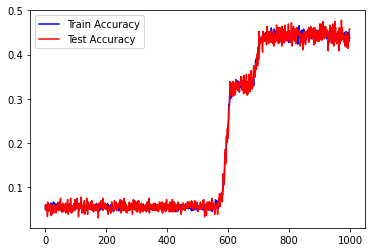

In [11]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()